In [5]:
import pandas as pd ## for linear algebra
import numpy as np ## for computation, and arrays.
from scipy.signal import argrelextrema, find_peaks_cwt ## for finding extrema
import matplotlib.pyplot as plt ## for plotting
import seaborn; seaborn.set() ## for custom plotting
%matplotlib inline 

## Introduction

Analytics surrounding the pandemic, namely time series, were the most  ubiqutious form of data news that Americans had access to: state governing bodies often appearing on regular policy breifings with line graphs of new case or moving averages of new cases. We assume that that similar means were used to make and assess the effectiveness of state policy decisions such as stay at home orders and mask ordinances. 

This notebook details the derivation of scalar score by which each state's time series can be arranged ordinally and thus compared directly. Local regression?

Consider the time series, $T$, of new daily cases for some state over some finite date-range. Having mapped the time series $T$ to a smooth function $T'$ using  series to a smooth function using local polynomial regression, there exists some sets of local minima and local maxima, $V$ and $P$ respectively, collectively defined as $E$, on $T$.

$$ Z = \lambda(V,P,\Delta{t},\Delta{y})) = \sum_{p \in P} \#p (\Delta{t})^{\tan(\frac{\Delta{y}}{\Delta{t}})} + \sum_{v \in V} (\Delta{t})^{\tan(\frac{\Delta{y}}{\Delta{t}})} $$

Thus, $ Z = \lambda(V,P,\Delta{t},\Delta{y})$ is defined below where $\Delta{y}$ is the inter-extrema change in cases and $\Delta{t}$ is the inter-extrema change in time (number of days), and $\#p$ is the cardinality of the maxima. 

This function is useful as undesirable qualities of a state's time series of new cases are penalized with higher scores, as the inclusion of $\#p$ ensures that state's whose time series has several peaks are found as less performant than those with fewer, more decisive relationship with the virus. 

$\Delta{t}$ captures the duration of the inter-extrema times, i.e. how long was the uninterrupted rise in cases leading up to a peak of trough. 

The inclusion of the tangent function serves two purposes is appropriate because the the tangent of the inter-extrema angle is the ratio of the inter-extrema cases and number of days. This is the angle of increase of decrease between points and serves as a notion of the intensity of the rise or fall of cases between peaks that is independent of the population of the state, allow us to forgoe normalizing, or otherwise transforming the data. This also ensures that the influence of an inter-extrema intervals is relative to the ratio of $\Delta{y}$ and $\Delta{t}$ such that a flat interval will have a minor effect on the total score, even if it is, say, the fourth or fifth peak in the time series. Such intervals are not common, but they do occur as part of the local regression polynomial regression.

We postulate that this function $\lambda$ of each time series will yield a unique score $Z \in R$ that will be high for states that had poor performance in containing the virus, and low for states the performed better.

What follows is a class object StateTS, which can load the time serieses for particular state and plot them along with thier extrema. calculate display statistics on the time serie and calculate Z for a given state. The last code block plots this information for all 50 states for easy comparisons.

In [6]:
us_states = ! ls States #saves US states in a list

In [33]:
class StateTS:    
    """Instantiates Time Series Analysis object and charts for State

    Args: 
        state (str): The full name of the state (e.g. "New Jersey" but not "NJ")
        [min_date] (str): first day of analysis window in YYYY-MM-DD format. Jan 22, 2020 by default.
        [max_date] (str): last day of analysis window in YYYY-MM-DD format May 2, 2021 by default.
    
    Attributes:
        attr1 (str): Description of `attr1`.
        attr2 (:obj:`int`, optional): Description of `attr2`.

    """
    def __init__(self, state, min_date="2020-01-22", max_date="2021-05-02"):
        
        # Load State data
        self.state_name = state # collects the name of the state
        self.ts=pd.read_csv(f'./States/{state}/{state}_smooth.csv').transpose() # loads data and takes its transpose
        self.date_range=pd.date_range(start=min_date, end=max_date) # sets date range
        
        # Engineering State data Series
        self.ts.index=self.date_range # assigns date range to index
        self.ts.index.name="Date" # Renames index to "Date"
        self.ts=self.ts.rename(columns={0:"new_cases"}) # Renames Series column to "new_cases"
        
        # Collecting peaks and troughs
        self.minima=list(argrelextrema(self.ts.values, np.less_equal, order=1)[0]) # collects minima from time series.
        self.maxima=list(argrelextrema(self.ts.values, np.greater_equal, order=1)[0]) # collects maxima from time series.
        self.points=np.sort(self.minima+self.maxima) # combines minima and maxima into one list of points of interest.
        self.peak_frame=self.ts.iloc[self.points] # subsets points of interest against main ts.
        #self.peak_frame=self.peak_frame.rename(columns={0:"number_of_new_cases"}) 
        
        # DELTAS
        self.time_delta=[] # list for interpeak times. 
        self.case_delta=[] # list for interpeak volume of new cases.
        self.slopes=[] #  ratio's of interpeak volumes and times.
        
        for i in range(len(self.peak_frame)-1): ## collects lists of interpeak times and new case volumes
            self.time_delta.append(-1*(self.peak_frame.index[i]-self.peak_frame.index[i+1]).days)
            self.case_delta.append(-1*int((self.peak_frame.values[i]-self.peak_frame.values[i+1])))
    
            
        self.df=pd.DataFrame(self.time_delta, self.case_delta)
        self.df=self.df[self.df.iloc[:,[0]]>1]
        self.df.dropna(axis=0, inplace=True)
        self.df=self.df.reset_index()
        self.df=self.df.rename(columns={0:"test",1:"test1"}) # why doesn't this work?
        print(self.df)

        
        self.case_delta=self.df.iloc[:,0]
        self.time_delta=self.df.iloc[:,1]
        
        #for i in range(len(self.time_delta)-1): ## collects list of interpeak volume/time ratio's (slopes)
        #    print(self.time_delta[i])
        #    self.slopes.append((self.case_delta[i])/self.time_delta[i]+1)
        
        self.up_slopes=[]
        

        for slope in self.slopes:
            if slope > 0:
                self.up_slopes.append(slope) 
        
        self.down_slopes=[]

        for slope in self.slopes:
            if slope < 0:
                self.down_slopes.append(slope) 
        
        #np.array(self.slopes).sum()
        #np.array(self.slopes).max()
        #np.array(self.slopes).min()

#    def chart_ts(self):
#        print(self.ts.new_cases)
#        self.ts.new_cases.plot(figsize=(20,8), alpha=.3)
#        plt.show()
        
    def return_statistics(self):
        print(self.ts.values.max())

    def chart_peaks(self):
        self.ts.new_cases.plot(figsize=(30,12), alpha=.3)
        ilocs_max_raw=argrelextrema(self.ts.values, np.greater_equal, order=1)[0]
        ilocs_min_raw=argrelextrema(self.ts.values, np.less_equal, order=1)[0]            
        ilocs_min=np.setdiff1d(ilocs_min_raw, ilocs_max_raw)
        ilocs_max=np.setdiff1d(ilocs_max_raw, ilocs_min_raw)
        print(self.ts.iloc[ilocs_min])
        print(ilocs_min)
        print(self.ts.iloc[ilocs_max])
        print(ilocs_max)
        

        self.ts.iloc[ilocs_max].new_cases.plot(style='.', lw=10, color='red', marker="v")
        self.ts.iloc[ilocs_min].new_cases.plot(style='.', lw=10, color='blue', marker="^")
        plt.title(f"{self.state_name}")
        plt.show()

    def get_extrema(self):
        pass

    def get_points(self):
        return(self.points)
        
    def get_sorted_points(self):
        self.points.npsort()
        
    def get_inc_seq(self):
        points=minima+maxima
        points.sort()
    
    def get_decr_seq(self):
        points=minima+maxima
        points.sort()
        
    def get_all_slopes(self):
        return(self.slopes)
        
    def get_up_slopes(self):
        up_slopes=[]
        for slope in self.slopes:
            if slope>0:
                up_slopes.append(slope) 
        return(up_slopes)
    
    def get_down_slopes(self):
        up_slopes=[]
        for slope in self.slopes:
            if slope>0:
                up_slopes.append(slope) 
        return(up_slopes)
    
    def report(self):
        
        print(f"Time Series Report for {self.state_name}")
        print(f"{self.peak_frame}")
        print("Minima")
        print(self.minima)
        print("Maxima")
        print(self.maxima)
        print("*******ANALYSIS OF DELTAS**********")
        print("Time Deltas")
        print(self.time_delta)
        print("Case Deltas")
        print(self.case_delta)
        print("*******ANALYSIS OF SLOPES**********")
        print(f"Slopes for {self.state_name}")
        print(self.slopes) 
        print(f"Sum of Slopes: {np.array(self.slopes).sum()}")
        #print(f"Maximum of Slopes: {np.array(self.slopes).max()}")
        #print(f"Minimum of Slopes: {np.array(self.slopes).min()}")
        self.chart_peaks()
        

In [34]:
state = StateTS("Alabama")
state.return_statistics()

   index   test
0   1661  157.0
1   -700   57.0
2   2760  101.0
3  -3310  100.0
4     23   26.0
3721.309114426589


   index   test
0   1661  157.0
1   -700   57.0
2   2760  101.0
3  -3310  100.0
4     23   26.0
             new_cases
Date                  
2020-02-16    0.000000
2020-09-17  960.346604
2021-04-06  411.079522
[ 25 239 440]
              new_cases
Date                   
2020-07-22  1661.076521
2020-12-27  3721.309114
2021-05-02   434.156083
[182 340 466]


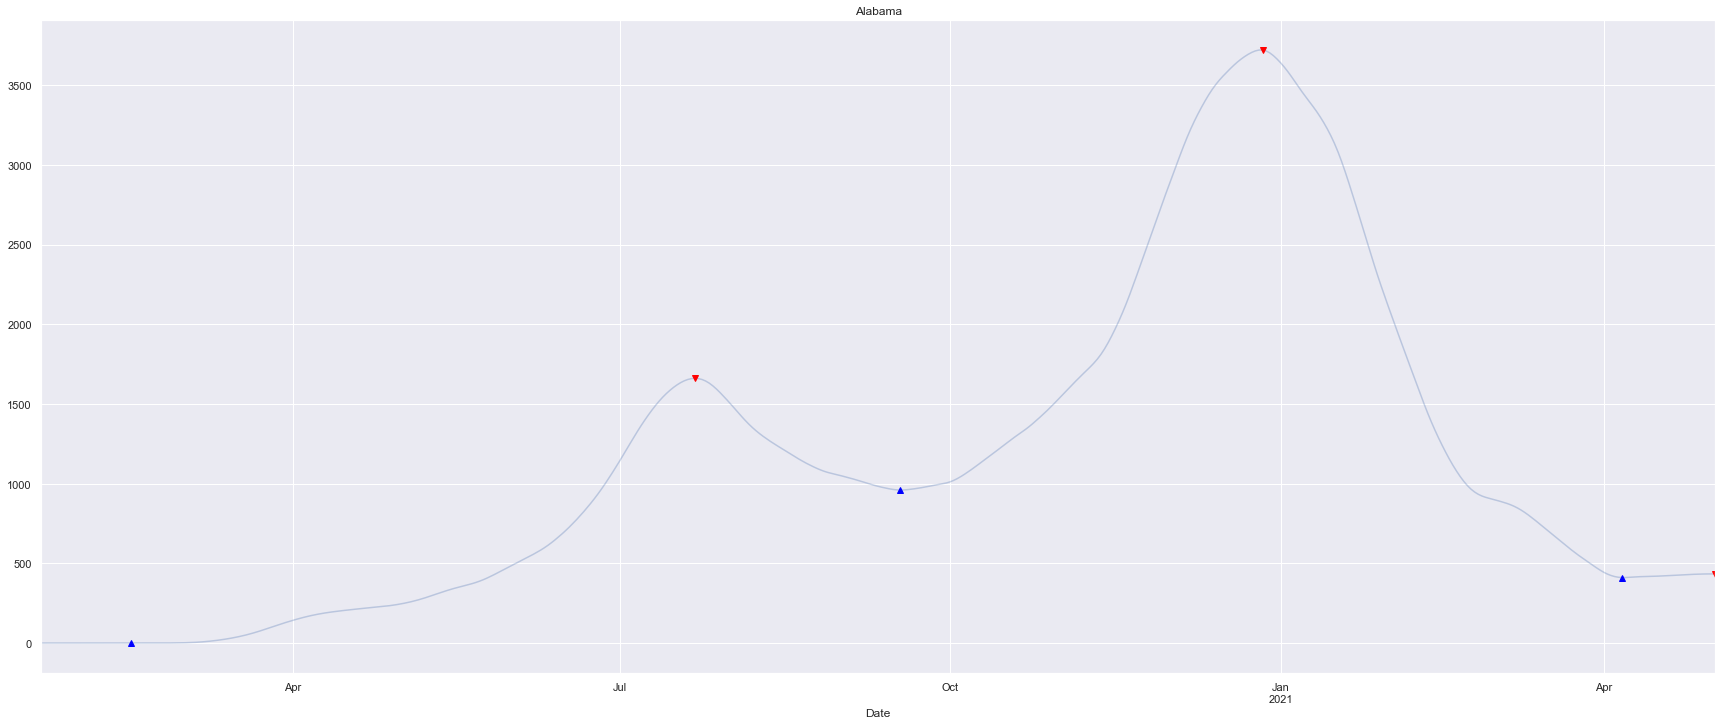

   index  test
0     10  46.0
1     -7  35.0
2     95  81.0
3    -22  31.0
4    537  90.0
5   -474  97.0
6      0   4.0
7     33  31.0
8    -45  23.0
             new_cases
Date                  
2020-02-18    0.000000
2020-05-09    2.800595
2020-08-29   75.326236
2021-03-04  138.524041
2021-03-09  138.013779
2021-05-02  126.792473
[ 27 108 220 407 412 466]
             new_cases
Date                  
2020-04-04   10.118329
2020-07-29   98.120045
2020-11-27  612.609253
2021-03-05  138.558826
2021-04-09  171.845024
[ 73 189 310 408 443]


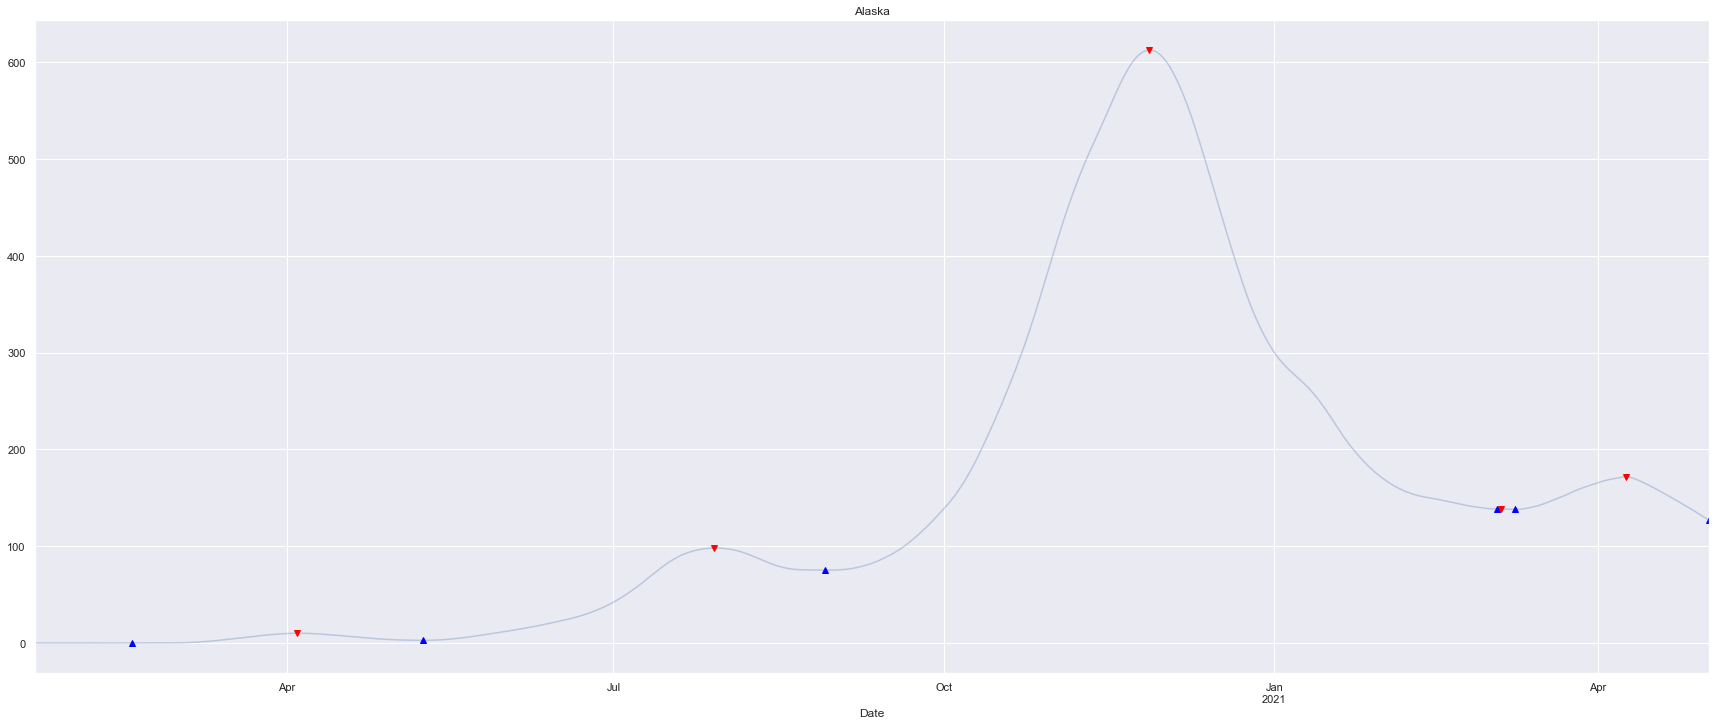

   index   test
0      0   23.0
1   3212  142.0
2  -2659   61.0
3      3    7.0
4      0    4.0
5   7322  115.0
6  -7266   80.0
7    128   33.0
             new_cases
Date                  
2020-01-22    0.000000
2020-02-15    0.007975
2020-09-05  552.624390
2020-09-16  555.045581
2021-03-30  611.060947
[  0  24 227 238 433]
              new_cases
Date                   
2020-01-23     0.096993
2020-07-06  3212.010703
2020-09-12   556.038576
2021-01-09  7877.822560
2021-05-02   740.023160
[  1 166 234 353 466]


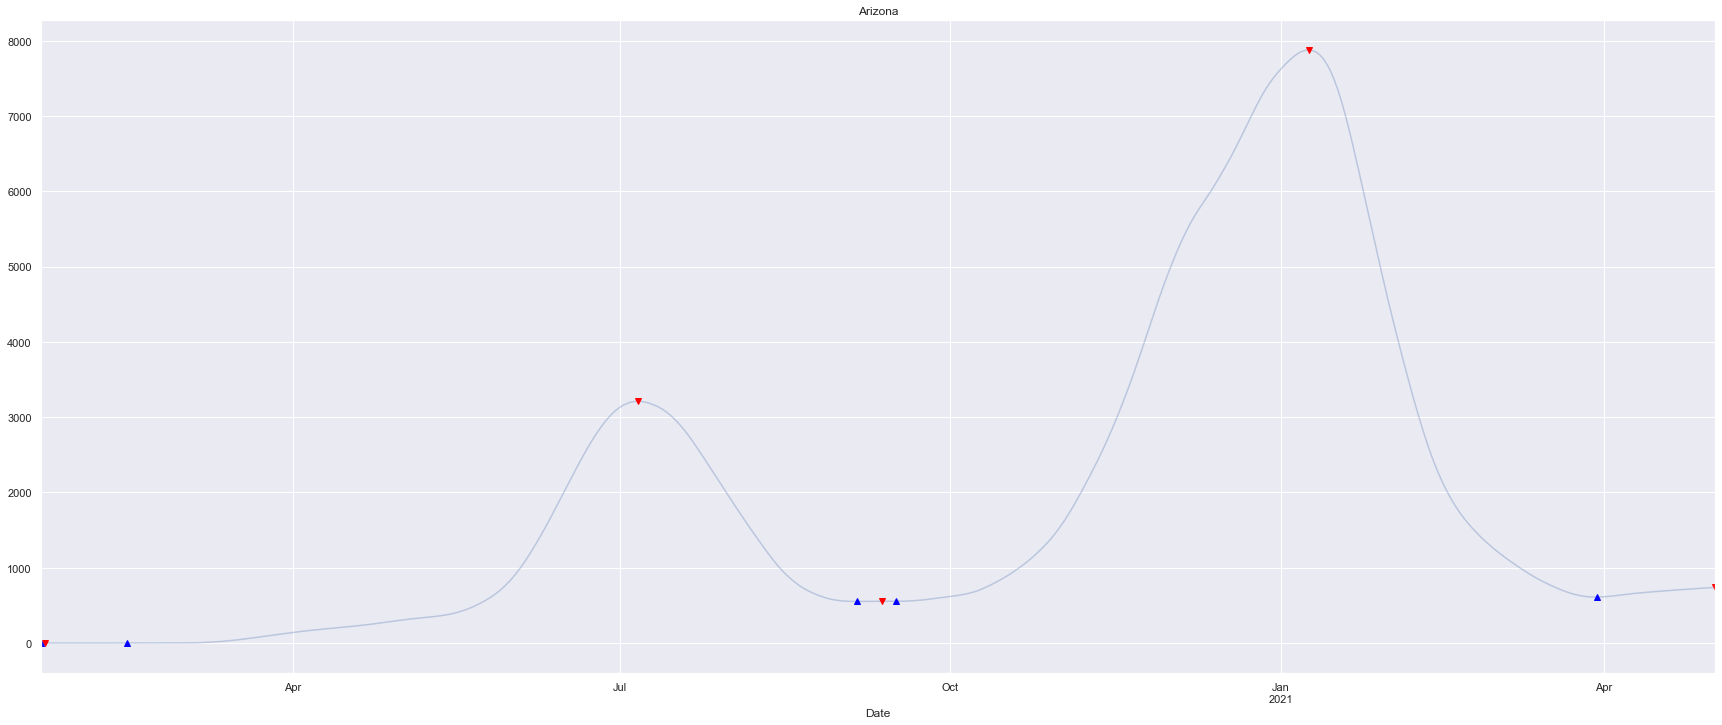

   index   test
0    739  158.0
1   -165   29.0
2   1899  133.0
3  -2302   95.0
4     25   24.0
             new_cases
Date                  
2020-02-18    0.000000
2020-08-23  574.554804
2021-04-08  171.947481
[ 27 214 442]
              new_cases
Date                   
2020-07-25   739.809903
2021-01-03  2474.039149
2021-05-02   197.843261
[185 347 466]


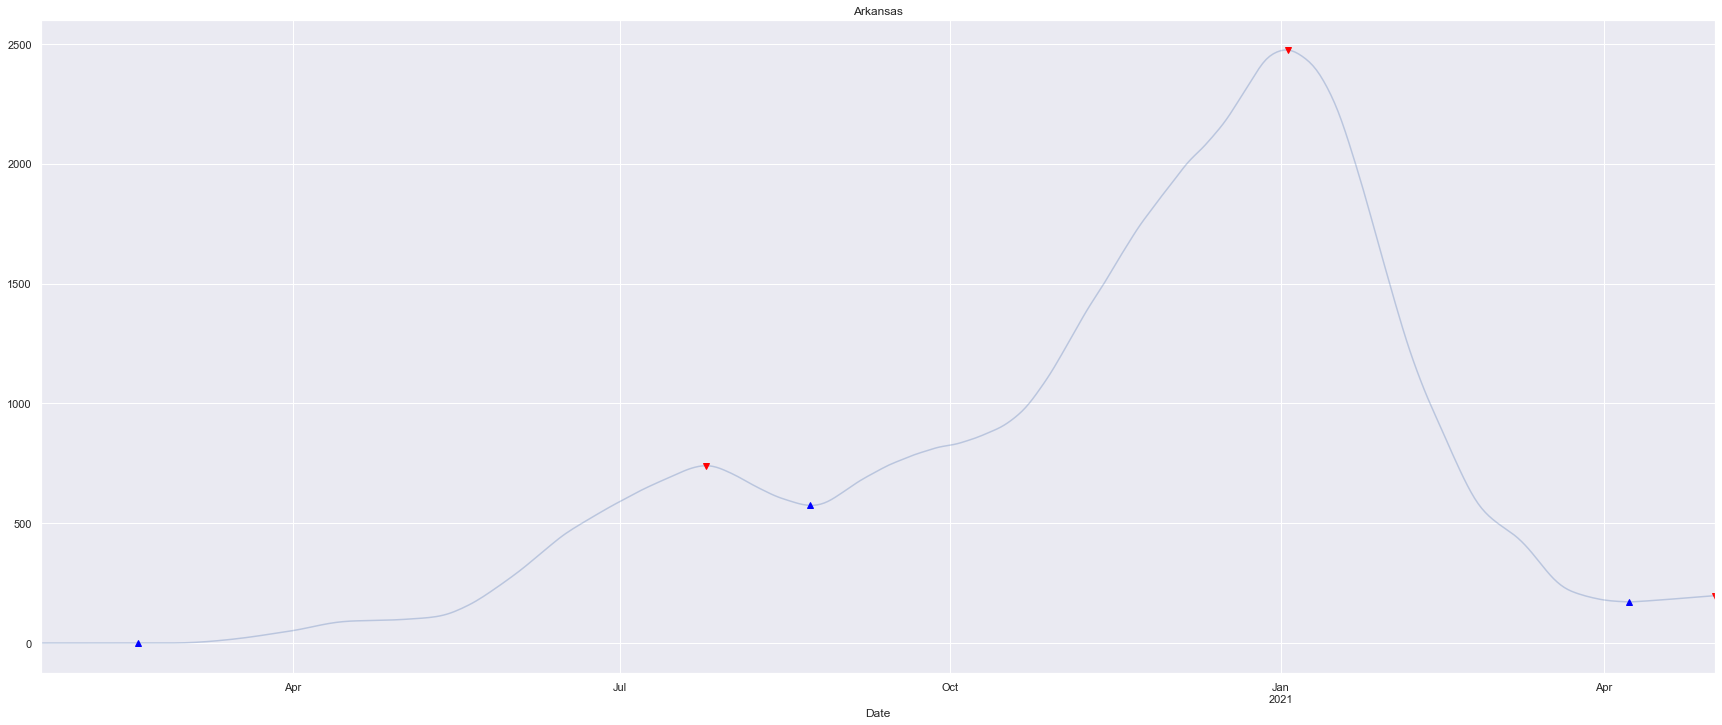

   index  test
0   8591   179
1  -5252    75
2  36612    88
3 -38273   124
              new_cases
Date                   
2020-01-22     0.000000
2020-10-02  3338.807269
2021-05-02  1677.392108
[  0 254 466]
               new_cases
Date                    
2020-07-19   8591.047599
2020-12-29  39951.266779
[179 342]


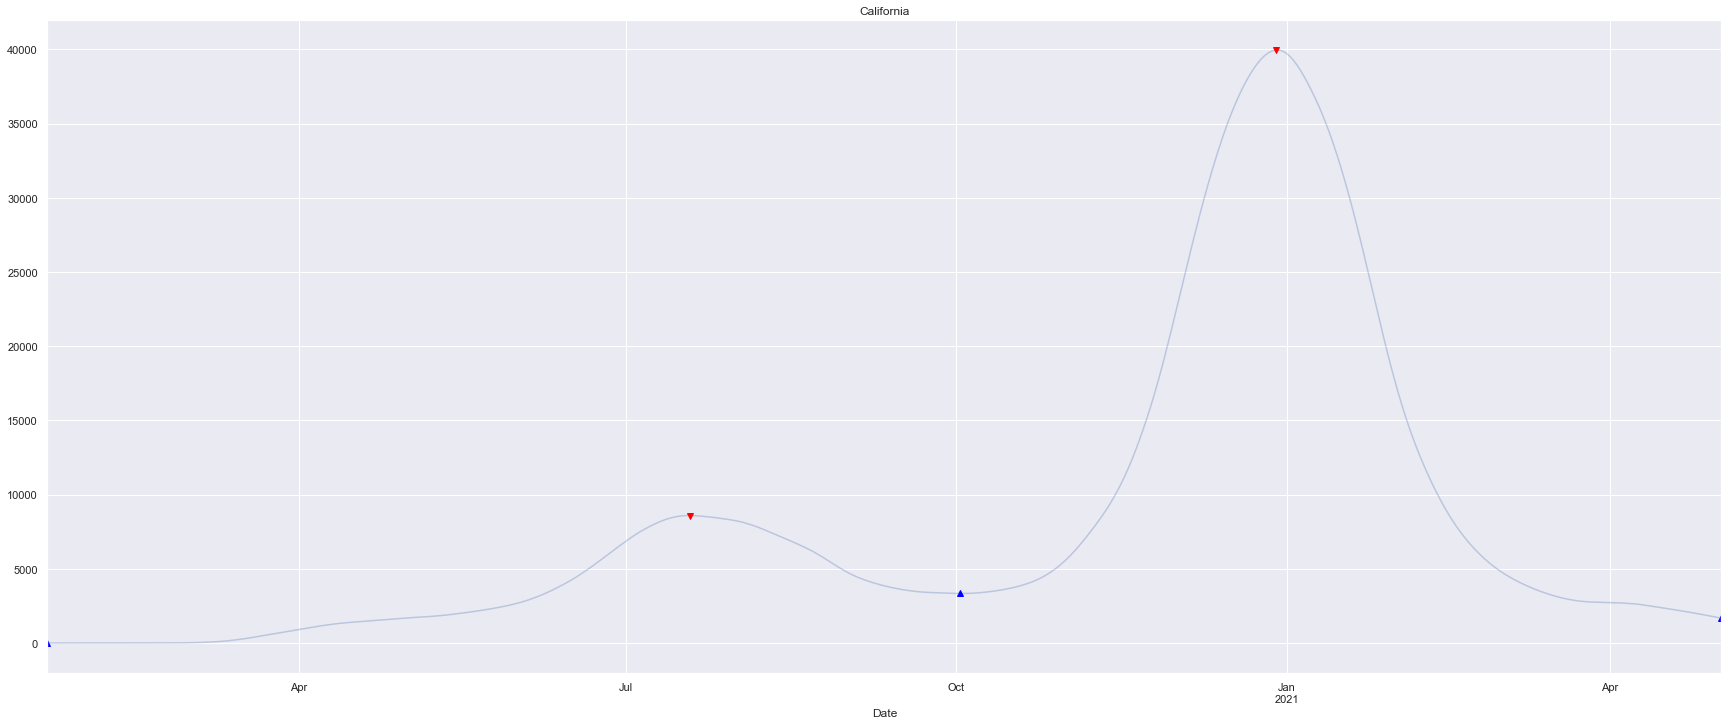

   index   test
0    435   96.0
1   -217   50.0
2    269   38.0
3   -188   33.0
4   4241   89.0
5  -3476  101.0
6    704   58.0
              new_cases
Date                   
2020-01-23    -0.014621
2020-06-17   217.594515
2020-08-27   299.299784
2021-03-05  1063.852749
[  1 147 218 408]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-28   435.136756
2020-07-25   487.526102
2020-11-24  4540.603417
2021-05-02  1768.391277
[  0  97 185 307 466]


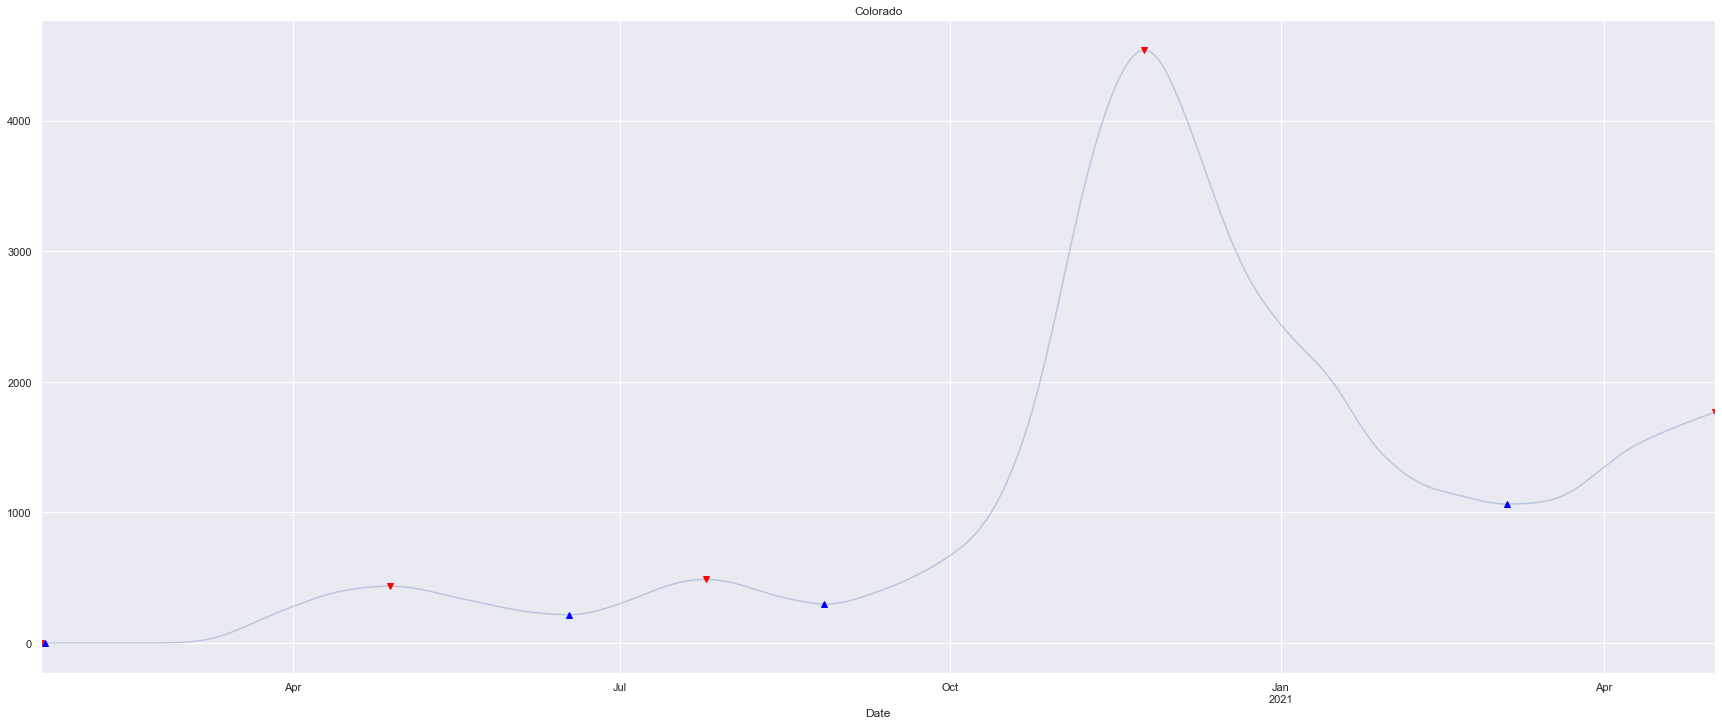

   index   test
0    826   62.0
1   -745   78.0
2     27   23.0
3     -8   19.0
4   2090  119.0
5    -45   11.0
6    111   17.0
7  -1423   52.0
8    296   31.0
9   -653   30.0
              new_cases
Date                   
2020-02-15     0.000000
2020-07-04    81.563789
2020-08-15   100.916963
2020-12-23  2145.409212
2021-03-02   833.147037
2021-05-02   476.536230
[ 24 164 206 336 405 466]
              new_cases
Date                   
2020-04-17   826.675402
2020-07-27   109.449065
2020-12-12  2191.383326
2021-01-09  2256.742097
2021-04-02  1130.009144
[ 86 187 325 353 436]


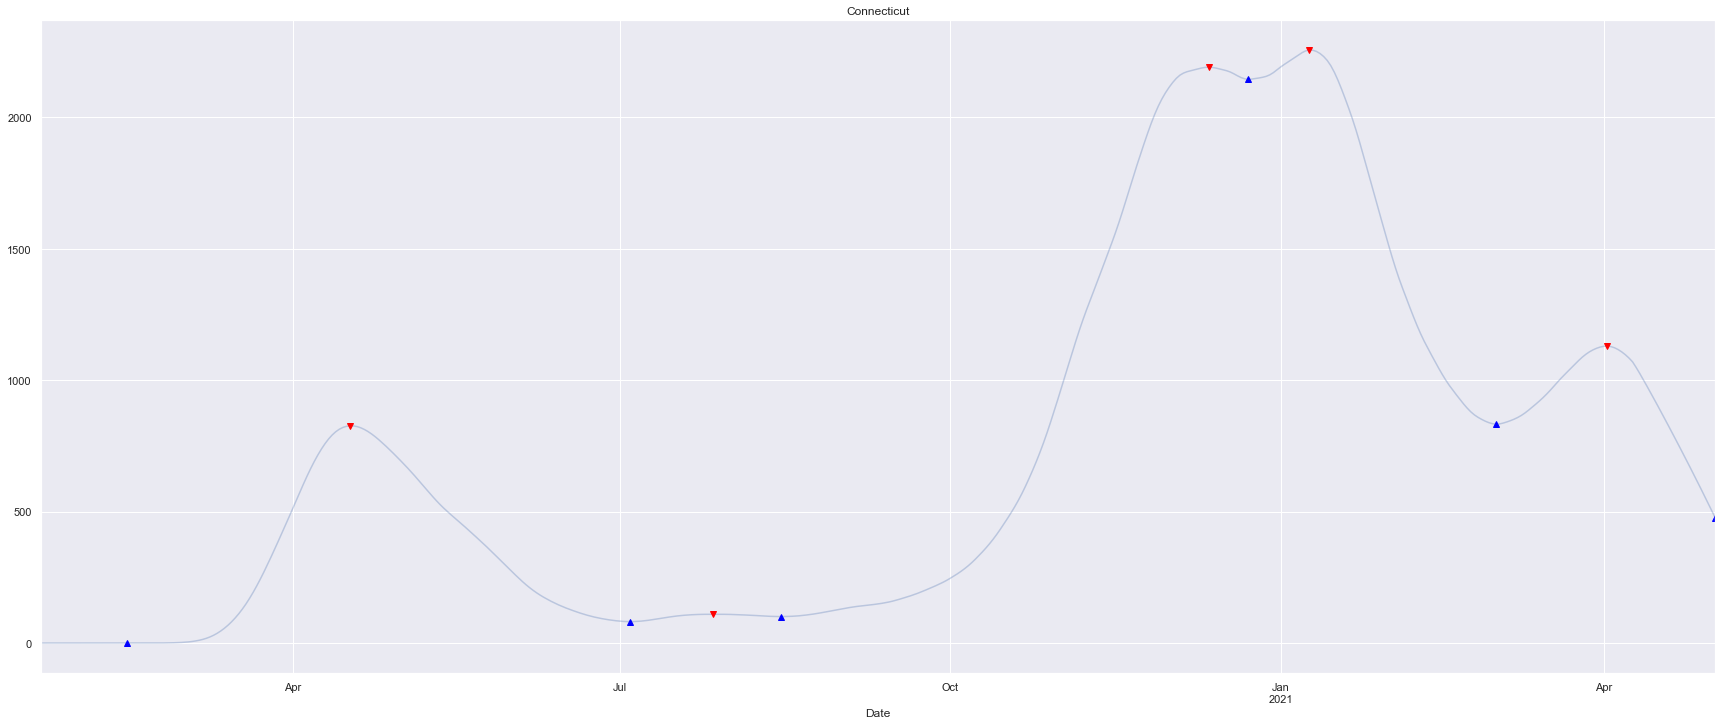

    index   test
0     178   78.0
1    -111   40.0
2      39   30.0
3      -6   12.0
4       1    6.0
5     -15   19.0
6     619  123.0
7      -7   13.0
8       0    3.0
9    -433   65.0
10     59   29.0
11    -50   23.0
             new_cases
Date                  
2020-02-16    0.000000
2020-06-13   66.306466
2020-07-25   99.900589
2020-08-19   85.400087
2021-01-02  696.686448
2021-03-11  263.105771
2021-05-02  271.612558
[ 25 143 185 210 346 414 466]
             new_cases
Date                  
2020-05-04  178.248507
2020-07-13  105.948368
2020-07-31  101.323734
2020-12-20  704.408242
2021-01-05  697.099904
2021-04-09  322.253425
[103 173 191 333 349 443]


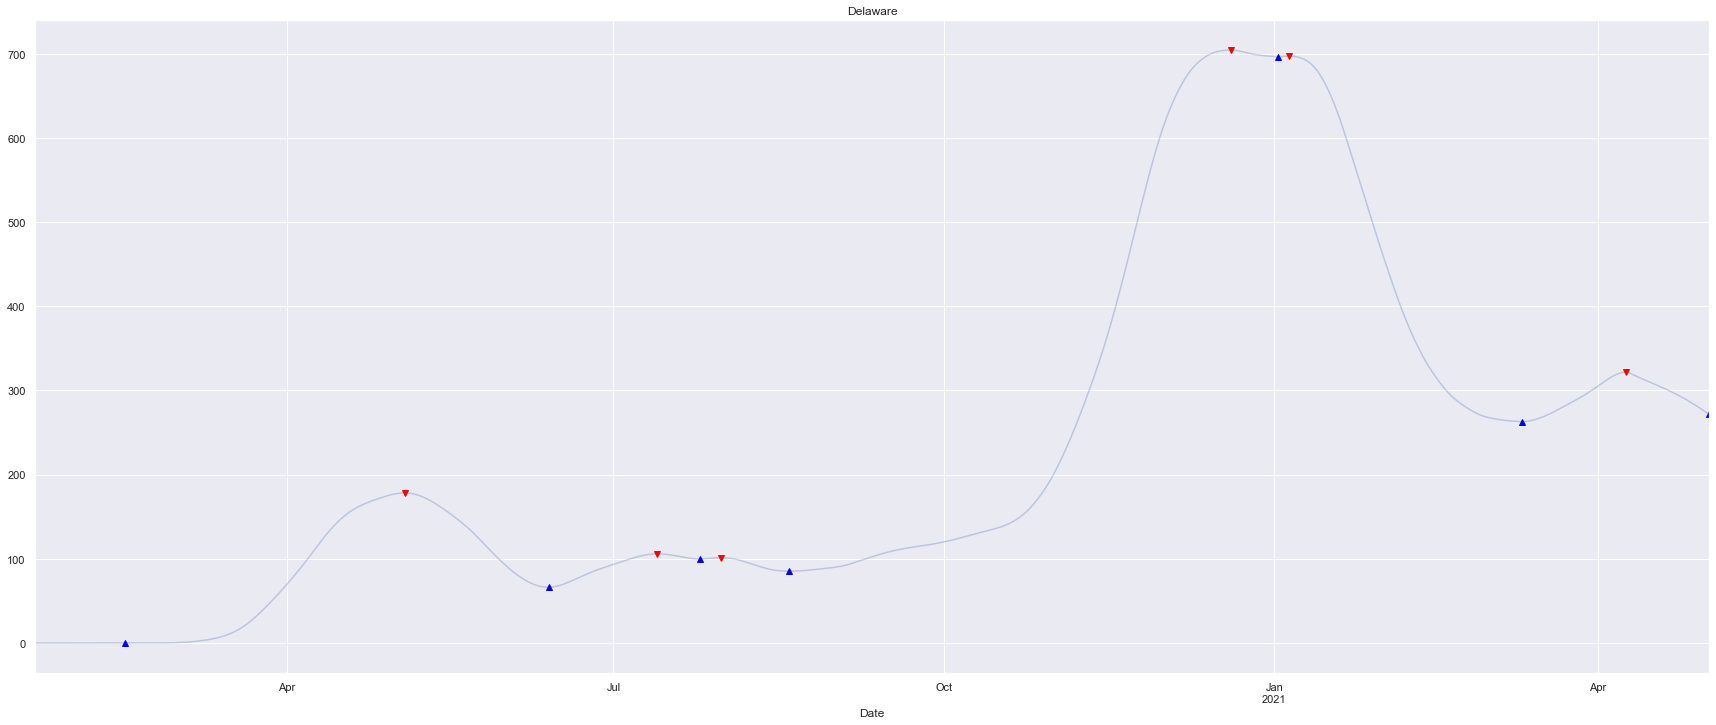

   index   test
0    933   79.0
1   -243   27.0
2   9499   70.0
3  -7681   71.0
4  10721  105.0
5  -8381   66.0
6    949   24.0
7   -427   23.0
              new_cases
Date                   
2020-01-23    -0.019772
2020-05-08   689.918652
2020-09-26  2508.029344
2021-03-16  4847.797987
2021-05-02  5370.438511
[  1 107 248 419 466]
               new_cases
Date                    
2020-01-22      0.000000
2020-04-11    933.063541
2020-07-17  10189.559688
2021-01-09  13229.044769
2021-04-09   5797.786017
[  0  80 177 353 443]


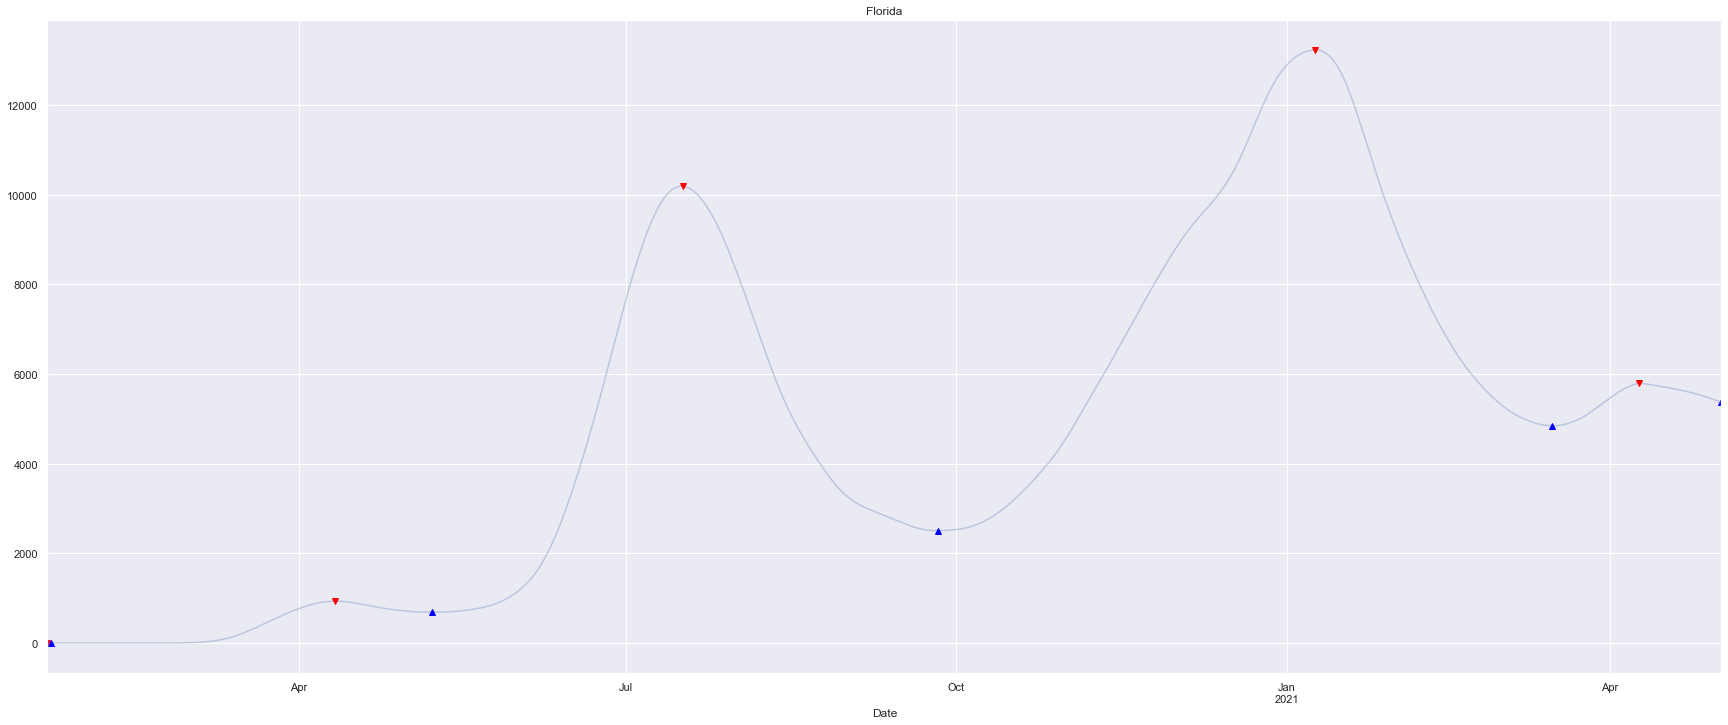

   index   test
0    761   87.0
1   -102   32.0
2   2837   65.0
3  -2245   73.0
4   2291   39.0
5    -34    5.0
6   4673   51.0
7  -6834  113.0
              new_cases
Date                   
2020-01-23    -0.014693
2020-05-21   659.017398
2020-10-06  1251.061626
2020-11-19  3507.918783
2021-05-02  1346.602026
[  1 120 258 302 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-19   761.323718
2020-07-25  3496.614028
2020-11-14  3542.610115
2021-01-09  8180.945246
[  0  88 185 297 353]


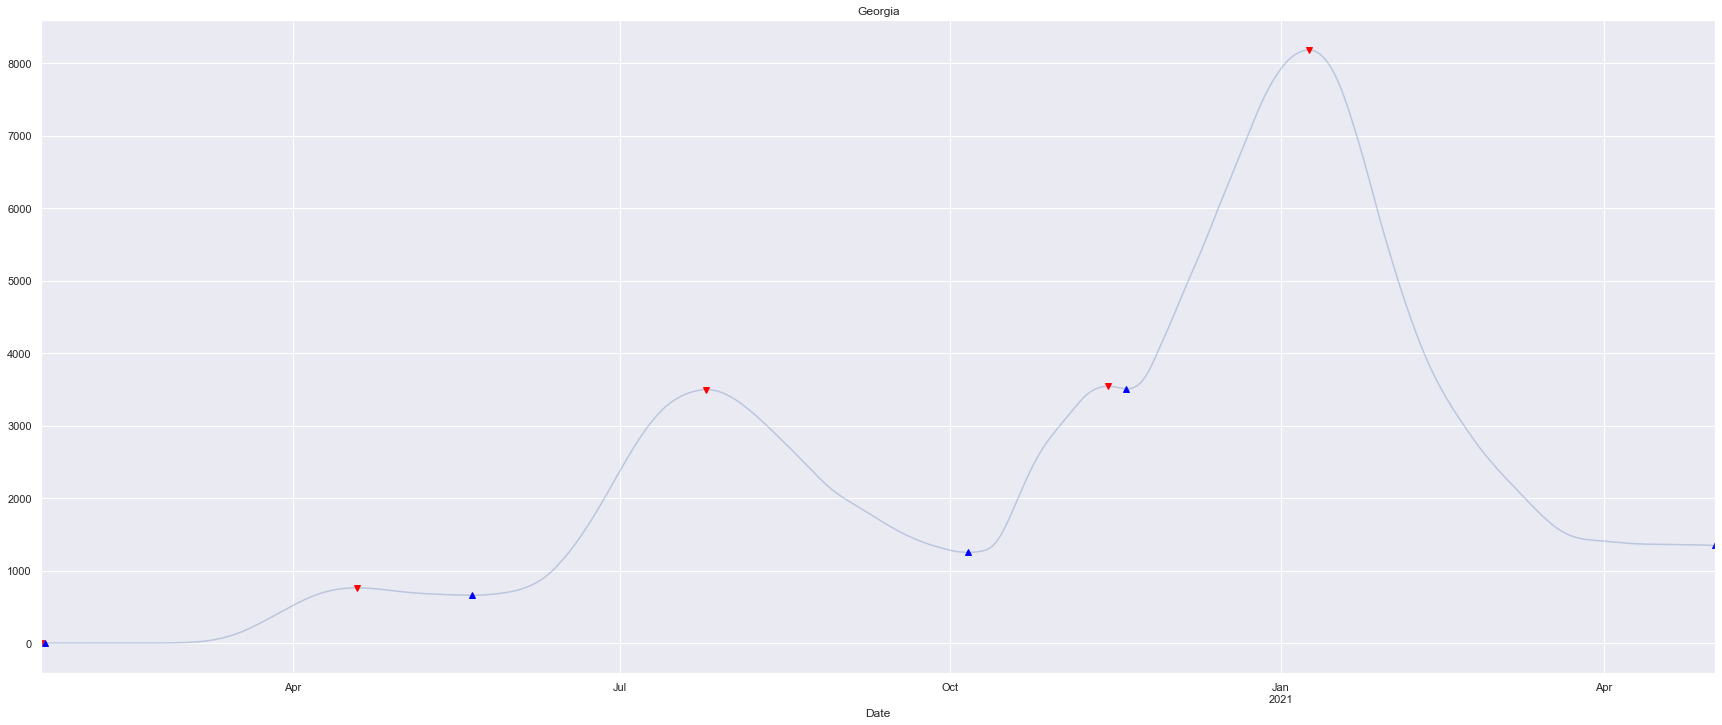

   index  test
0     17  72.0
1    -16  43.0
2    218  98.0
3   -132  56.0
4      9  30.0
5      0   3.0
6     57  46.0
7    -98  49.0
8     46  41.0
9     -4  27.0
            new_cases
Date                 
2020-01-23  -0.000719
2020-05-17   1.152637
2020-10-18  87.291571
2020-11-20  96.794099
2021-02-23  56.543970
2021-05-02  98.846608
[  1 116 270 303 398 466]
             new_cases
Date                  
2020-01-22    0.000000
2020-04-04   17.919307
2020-08-23  220.143027
2020-11-17   97.093789
2021-01-05  154.652478
2021-04-05  103.148637
[  0  73 214 300 349 439]


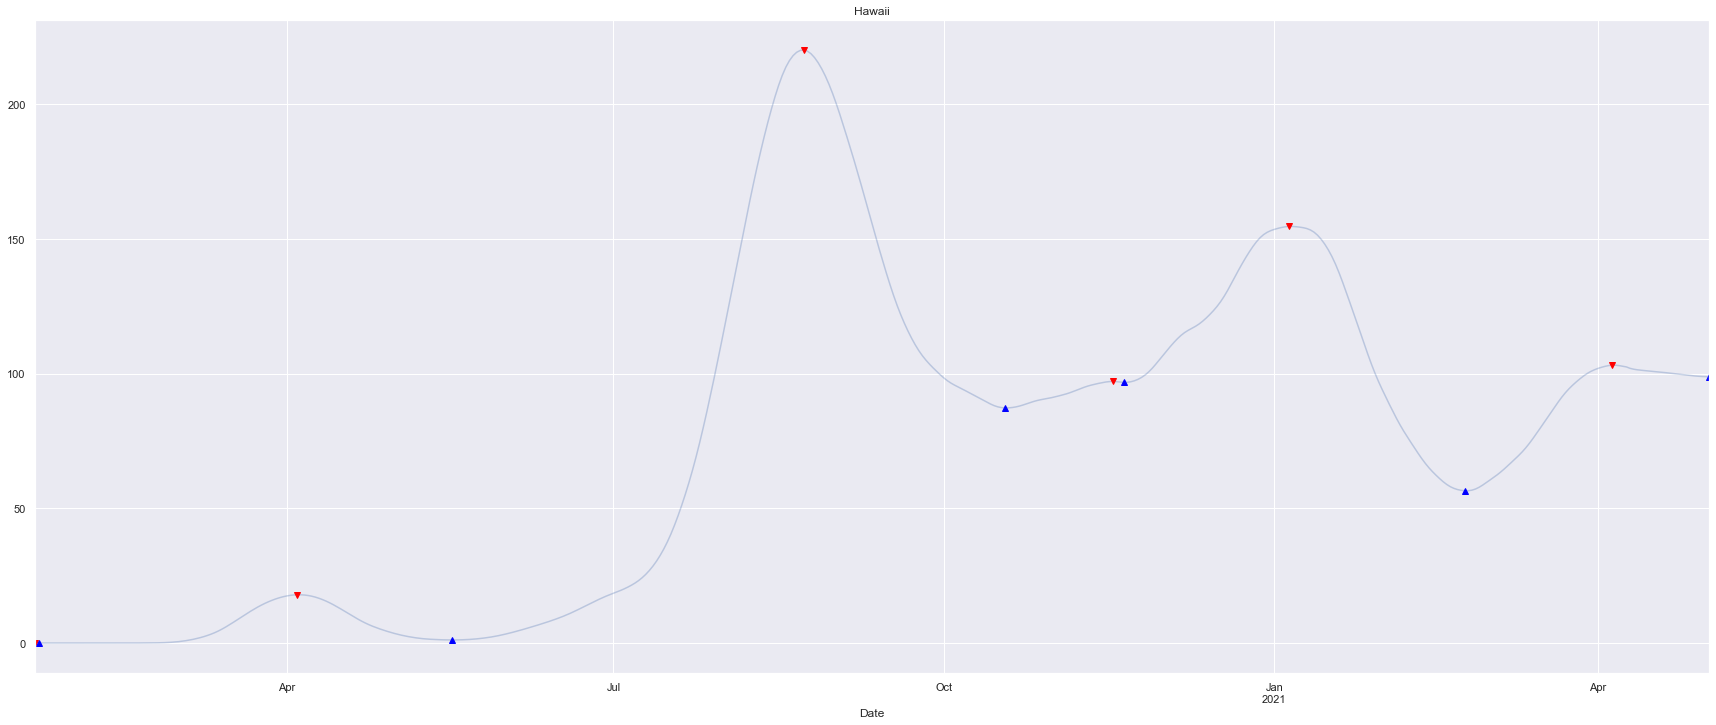

   index  test
0     56  49.0
1    -30  33.0
2    464  75.0
3   -215  41.0
4   1111  88.0
5  -1105  86.0
6     15  19.0
7      0   3.0
8   -141  44.0
             new_cases
Date                  
2020-02-18    0.000000
2020-05-10   26.094892
2020-09-03  274.598949
2021-02-24  279.842678
2021-03-16  295.769651
2021-05-02  154.154849
[ 27 109 225 399 419 466]
              new_cases
Date                   
2020-04-07    56.723294
2020-07-24   490.394038
2020-11-30  1385.814057
2021-03-15   295.800811
2021-03-19   296.075529
[ 76 184 313 418 422]


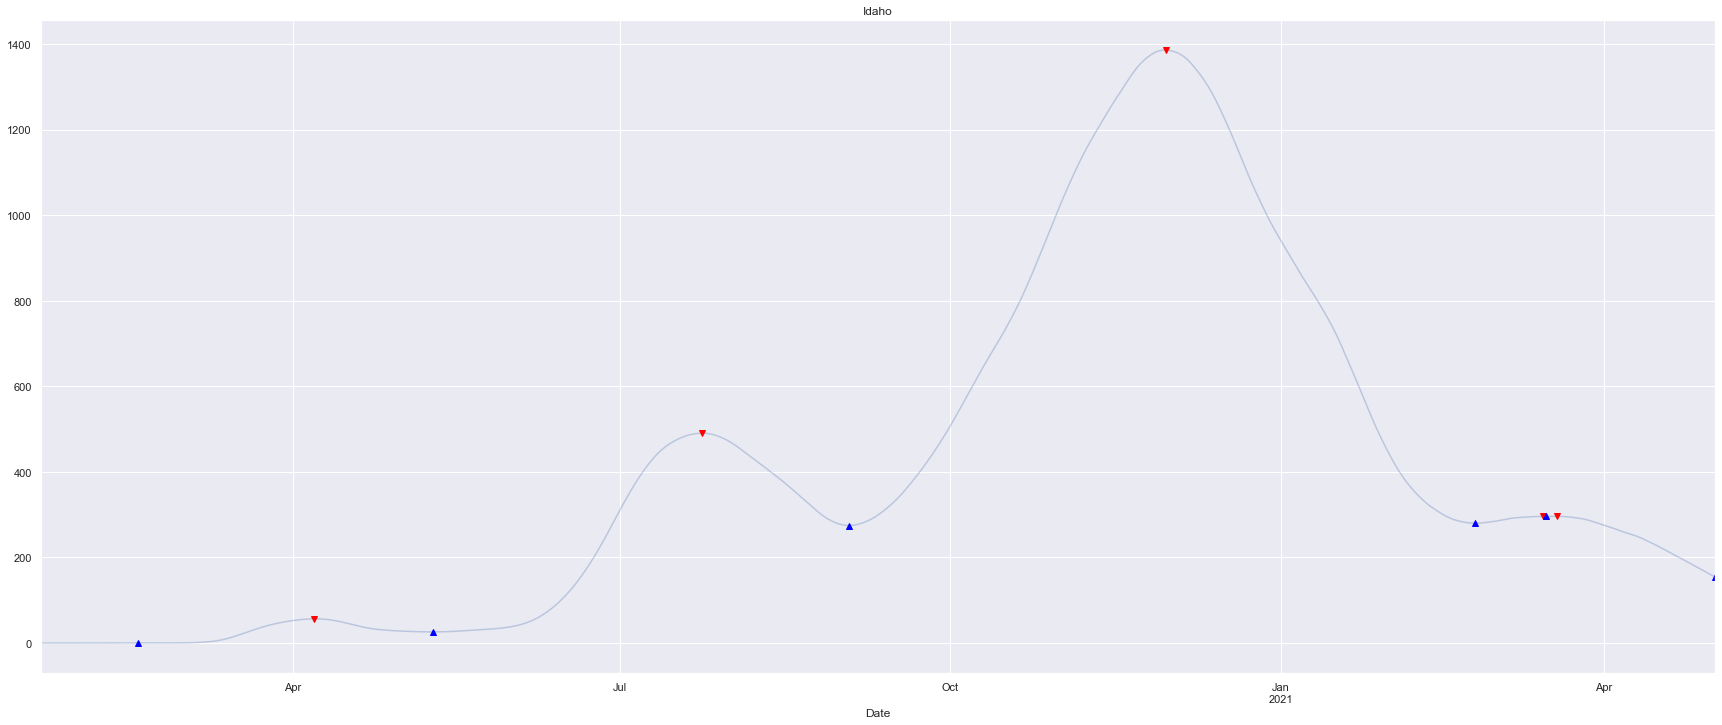

   index   test
0      0   23.0
1   2309   83.0
2  -1574   44.0
3   1250   70.0
4    -35   19.0
5   8704   62.0
6  -8958  105.0
7   1231   36.0
8   -173   23.0
              new_cases
Date                   
2020-01-22     0.000000
2020-02-15     0.050421
2020-06-21   735.129019
2020-09-18  1950.652656
2021-03-04  1697.072360
2021-05-02  2754.741997
[  0  24 151 240 407 466]
               new_cases
Date                    
2020-01-23      0.161736
2020-05-08   2309.982515
2020-08-30   1985.715381
2020-11-19  10655.651326
2021-04-09   2928.633590
[  1 107 221 302 443]


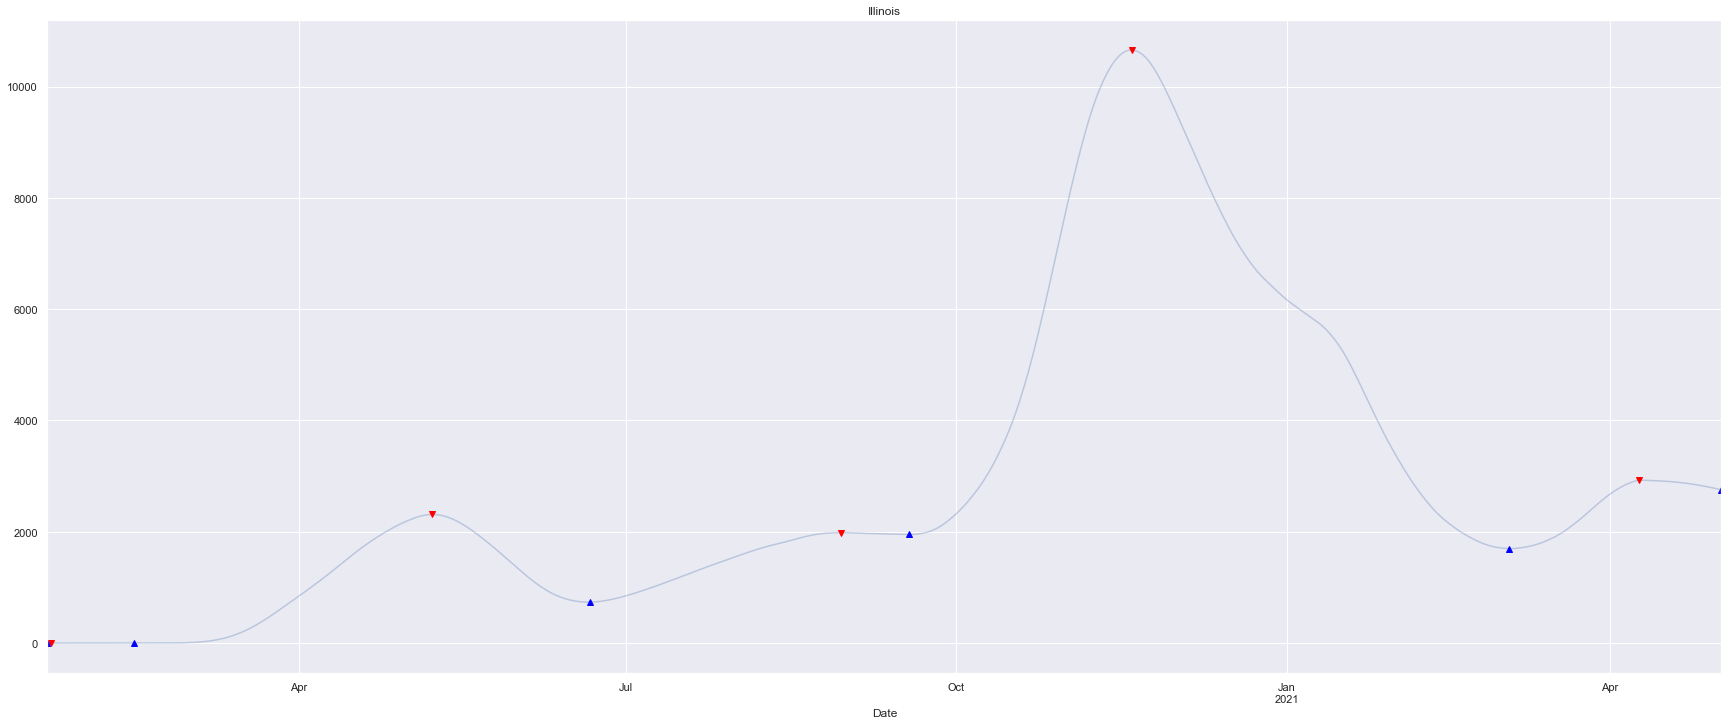

   index   test
0    590  101.0
1   -215   45.0
2    533   64.0
3    -37   23.0
4   5295   78.0
5  -5366  102.0
6    357   52.0
             new_cases
Date                  
2020-01-23   -0.001797
2020-06-17  375.062179
2020-09-12  870.858564
2021-03-11  799.880213
[  1 147 234 414]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-03   590.632582
2020-08-20   908.726025
2020-11-29  6166.193838
2021-05-02  1156.901583
[  0 102 211 312 466]


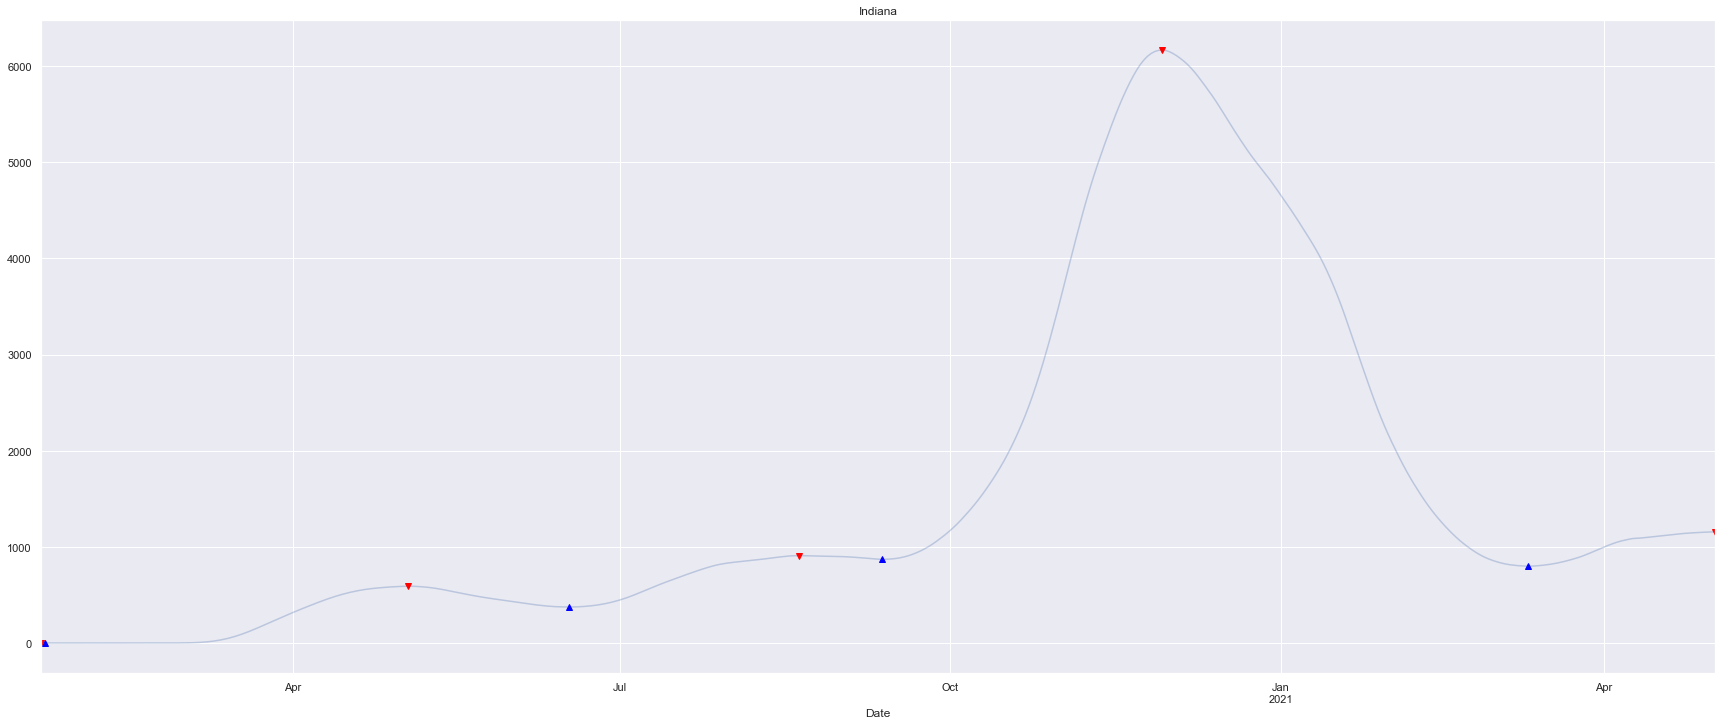

   index   test
0    418  105.0
1   -105   33.0
2    188   40.0
3    -17   12.0
4    342   38.0
5    -17    9.0
6   2671   59.0
7  -3007  117.0
8     23   21.0
9   -144   31.0
             new_cases
Date                  
2020-01-23   -0.000099
2020-06-09  313.337421
2020-07-31  484.639637
2020-09-16  809.571414
2021-03-11  473.559184
2021-05-02  352.958920
[  1 139 191 238 414 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-07   418.824007
2020-07-19   501.752476
2020-09-07   827.538318
2020-11-14  3480.745170
2021-04-01   497.368699
[  0 106 179 229 297 435]


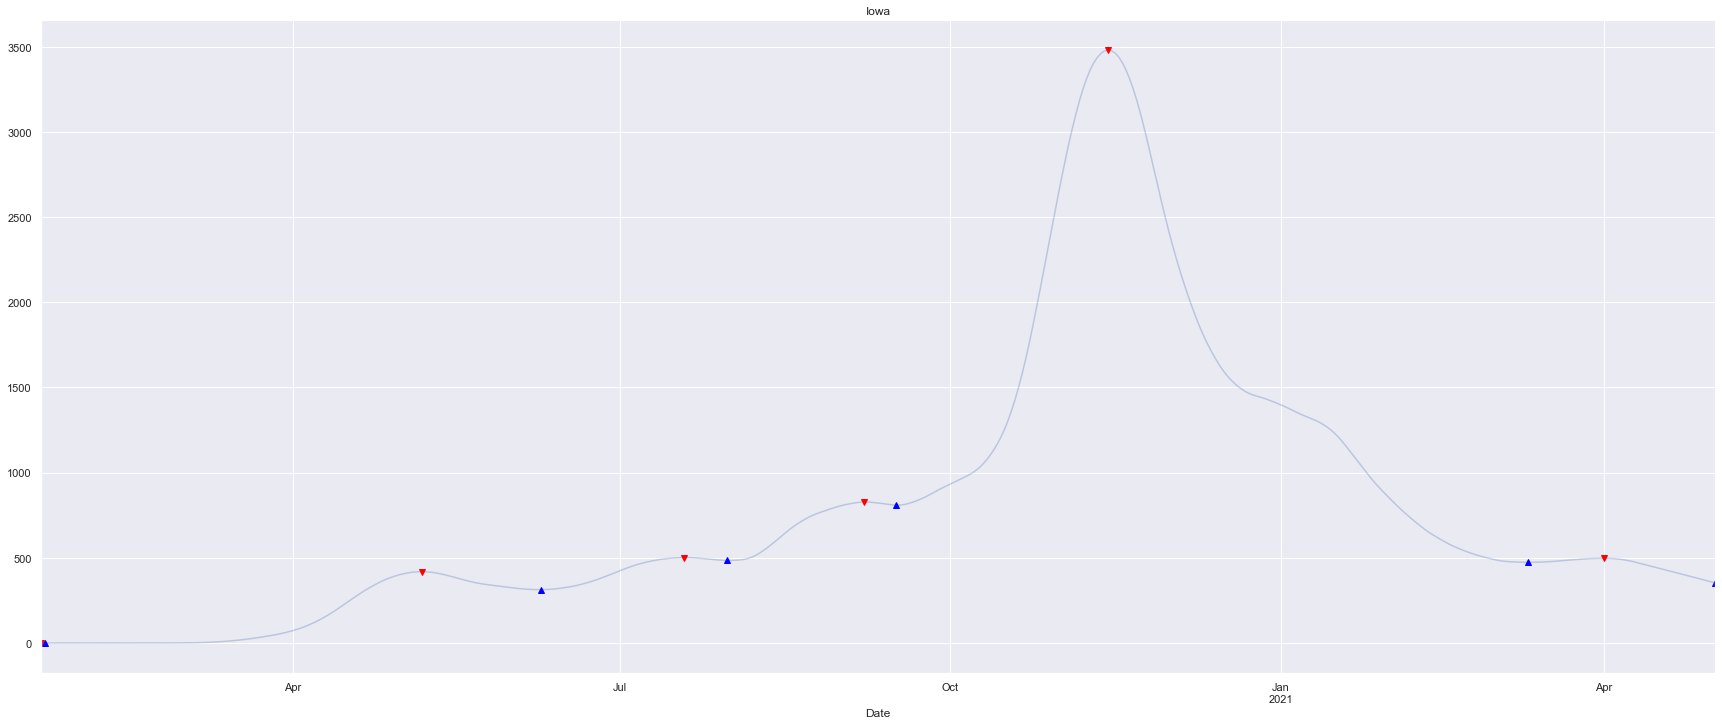

   index   test
0    214  102.0
1   -101   29.0
2    307   50.0
3      0    3.0
4   2080  122.0
5  -2291  127.0
6      6   30.0
7      0    2.0
             new_cases
Date                  
2020-01-23   -0.000237
2020-06-02  112.958621
2020-07-25  419.978702
2021-03-31  208.548092
2021-05-02  215.196051
[  1 132 185 434 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-04   214.169765
2020-07-22   420.262868
2020-11-24  2499.982984
2021-04-30   215.246761
[  0 103 182 307 464]


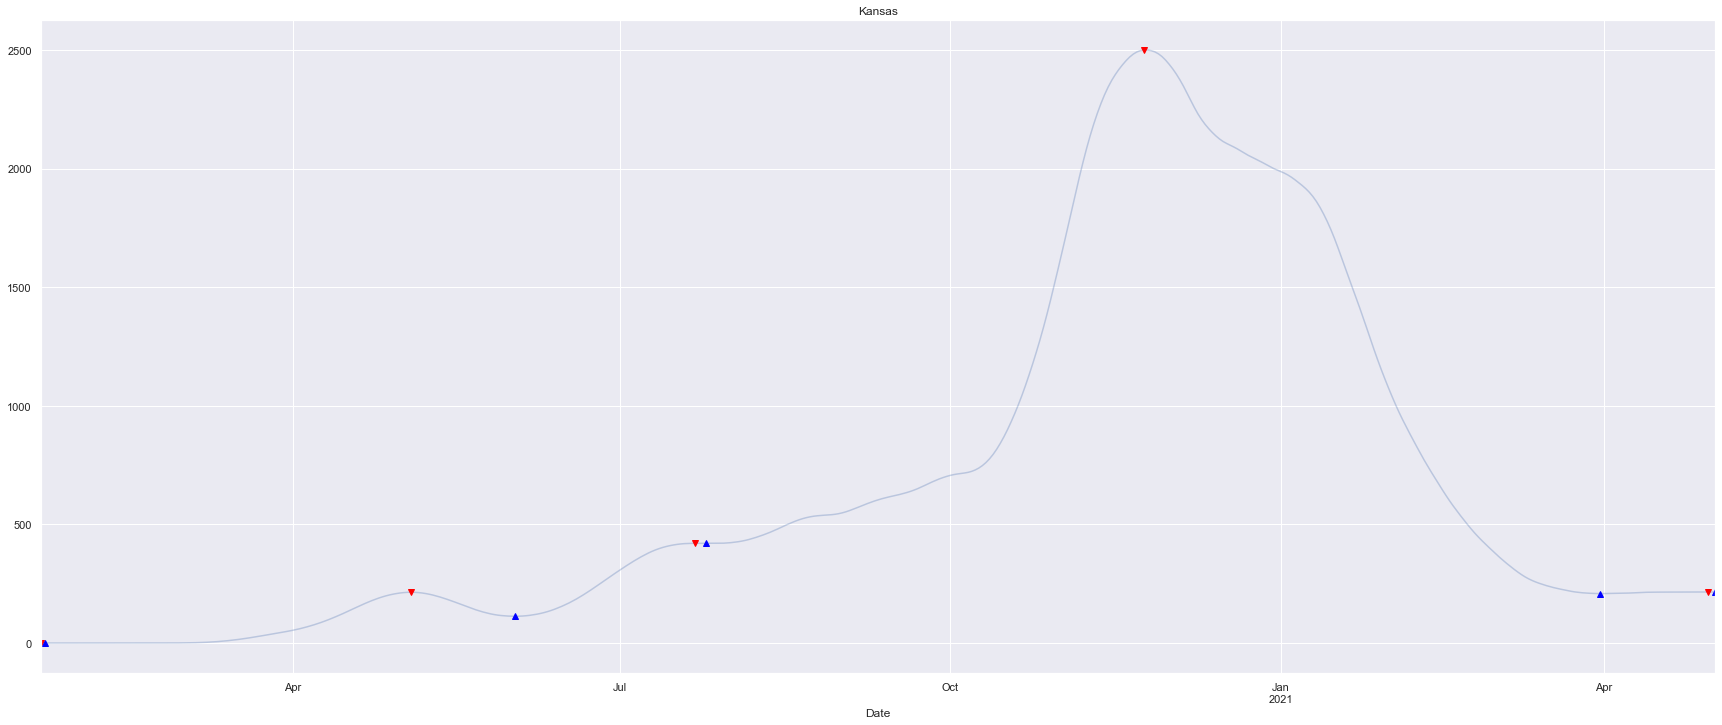

   index   test
0    170  100.0
1     -6   12.0
2   2862  203.0
3   -270   17.0
4    386   23.0
5  -2575  110.0
              new_cases
Date                   
2020-01-23    -0.001626
2020-05-14   164.117602
2020-12-20  2756.300920
2021-05-02   567.000309
[  1 113 333 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-02   170.554192
2020-12-03  3026.350233
2021-01-12  3142.899930
[  0 101 316 356]


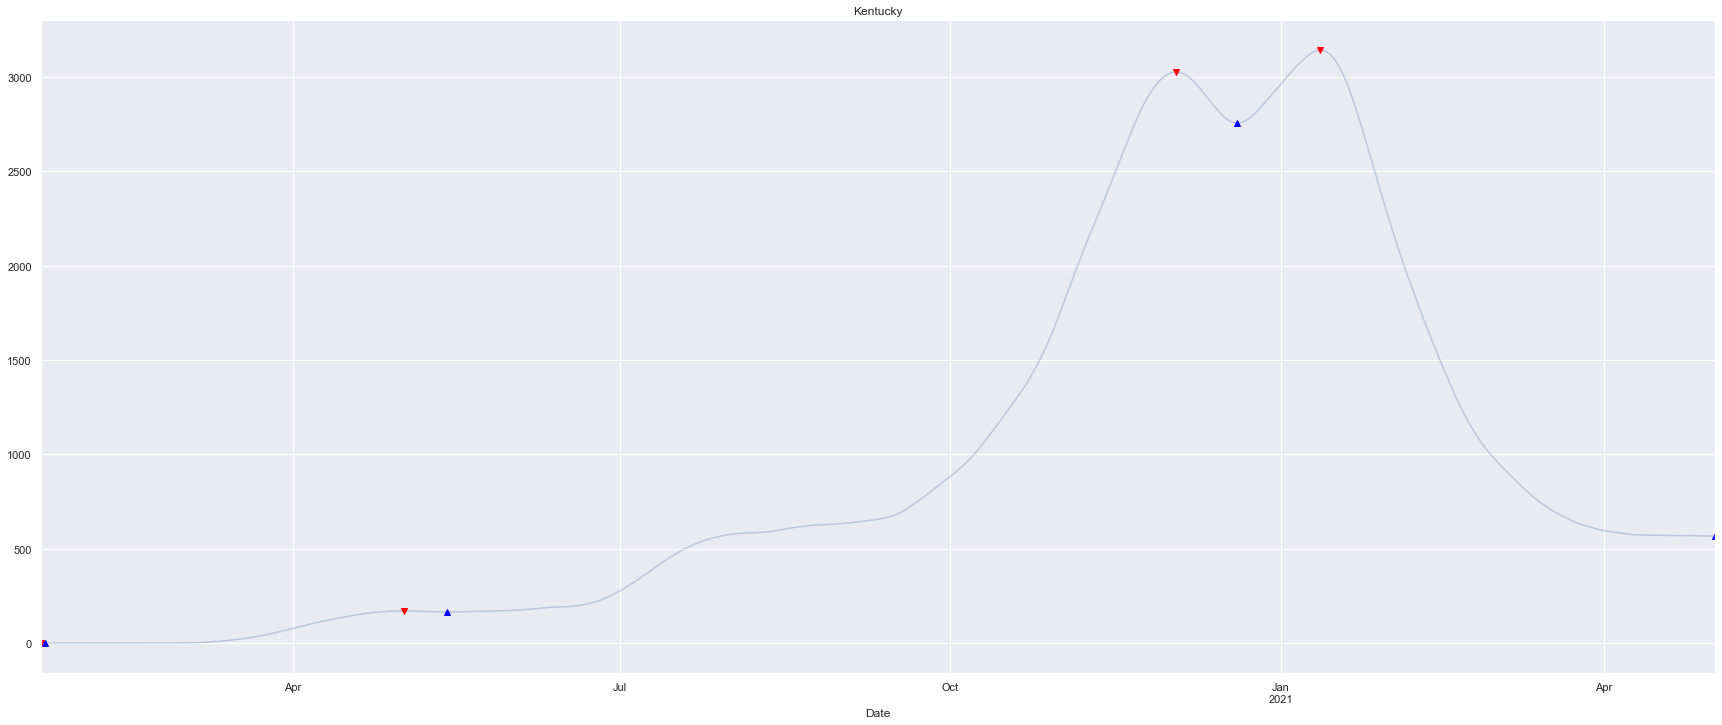

   index   test
0    813   52.0
1   -437   30.0
2   1543   74.0
3  -1336   68.0
4   2364  104.0
5  -2516   80.0
6     13   12.0
7    -35   21.0
             new_cases
Date                  
2020-02-16    0.000000
2020-05-08  375.524700
2020-09-27  582.316609
2021-03-30  429.814064
2021-05-02  407.701435
[ 25 107 249 433 466]
              new_cases
Date                   
2020-04-08   813.011323
2020-07-21  1919.296634
2021-01-09  2946.729450
2021-04-11   442.893029
[ 77 181 353 445]


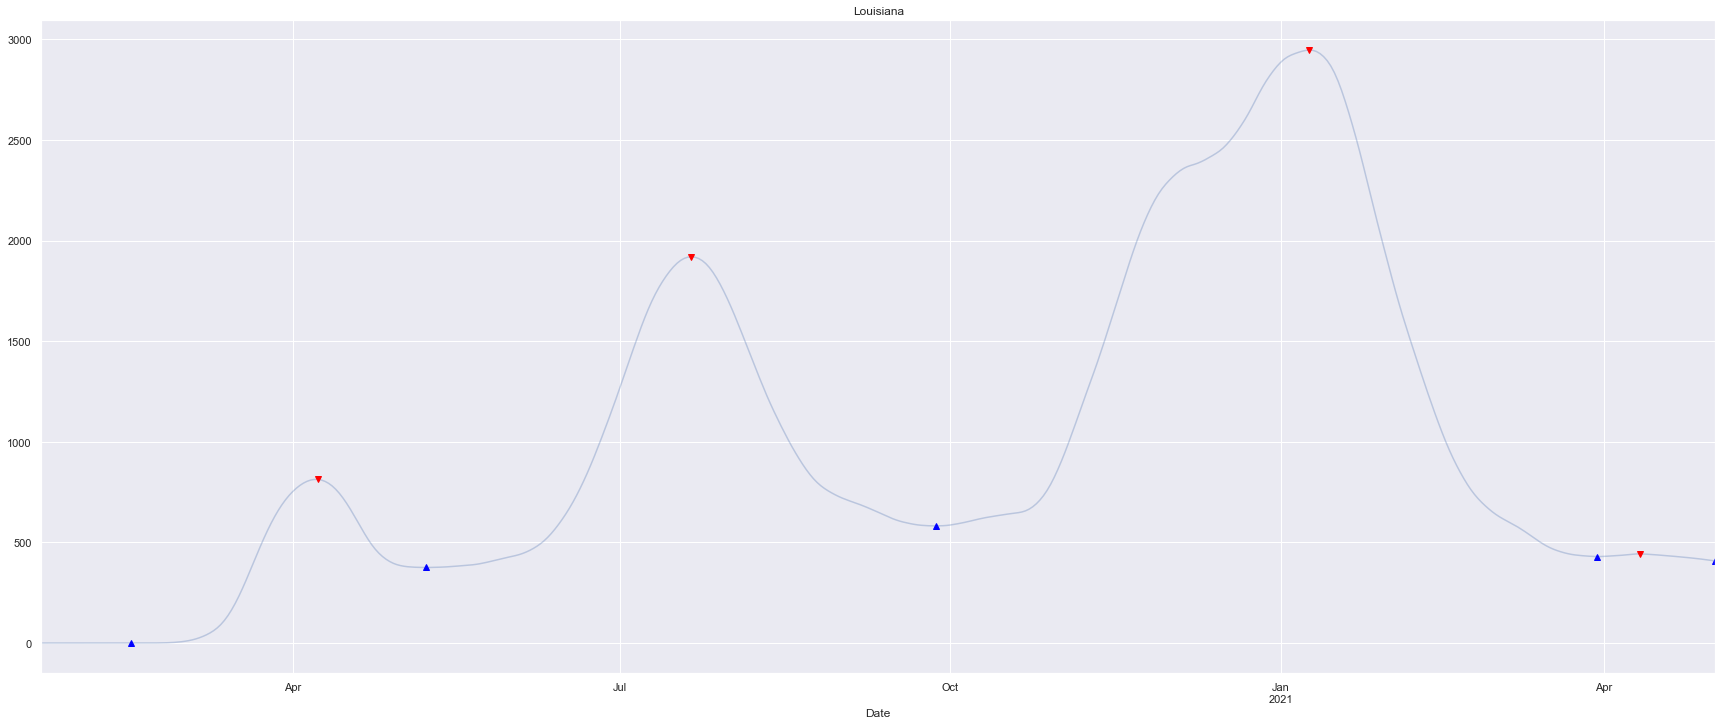

   index  test
0     27  52.0
1      0  10.0
2     14  33.0
3    -22  70.0
4     13  60.0
5      0   3.0
6    488  99.0
7   -357  48.0
8    192  59.0
9     -3   6.0
             new_cases
Date                  
2020-02-17    0.000000
2020-04-19   26.183165
2020-07-31   17.796815
2020-10-02   30.807682
2021-02-26  162.004320
2021-05-02  350.701231
[ 26  88 191 254 401 466]
             new_cases
Date                  
2020-04-09   27.144201
2020-05-22   40.248020
2020-09-29   30.847275
2021-01-09  519.509180
2021-04-26  354.203008
[ 78 121 251 353 460]


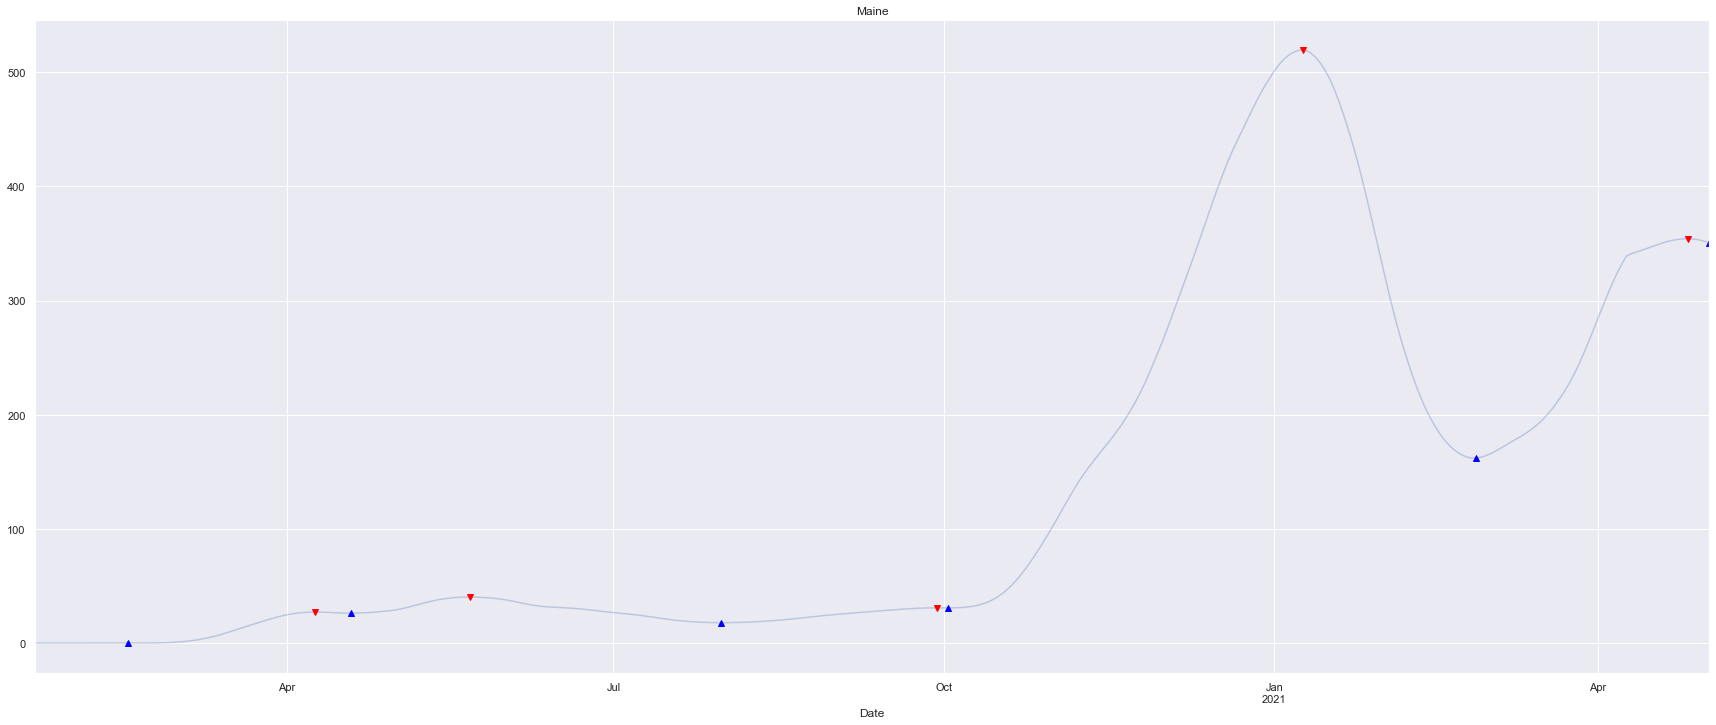

   index   test
0    981  110.0
1   -564   45.0
2    374   33.0
3   -250   58.0
4   2106  102.0
5  -1832   55.0
6    450   37.0
7   -383   25.0
             new_cases
Date                  
2020-01-23   -0.005056
2020-06-26  417.469578
2020-09-25  542.378115
2021-03-01  816.159673
2021-05-02  882.707966
[  1 156 247 404 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-12   981.832554
2020-07-29   792.425925
2021-01-05  2648.871321
2021-04-07  1266.641591
[  0 111 189 349 441]


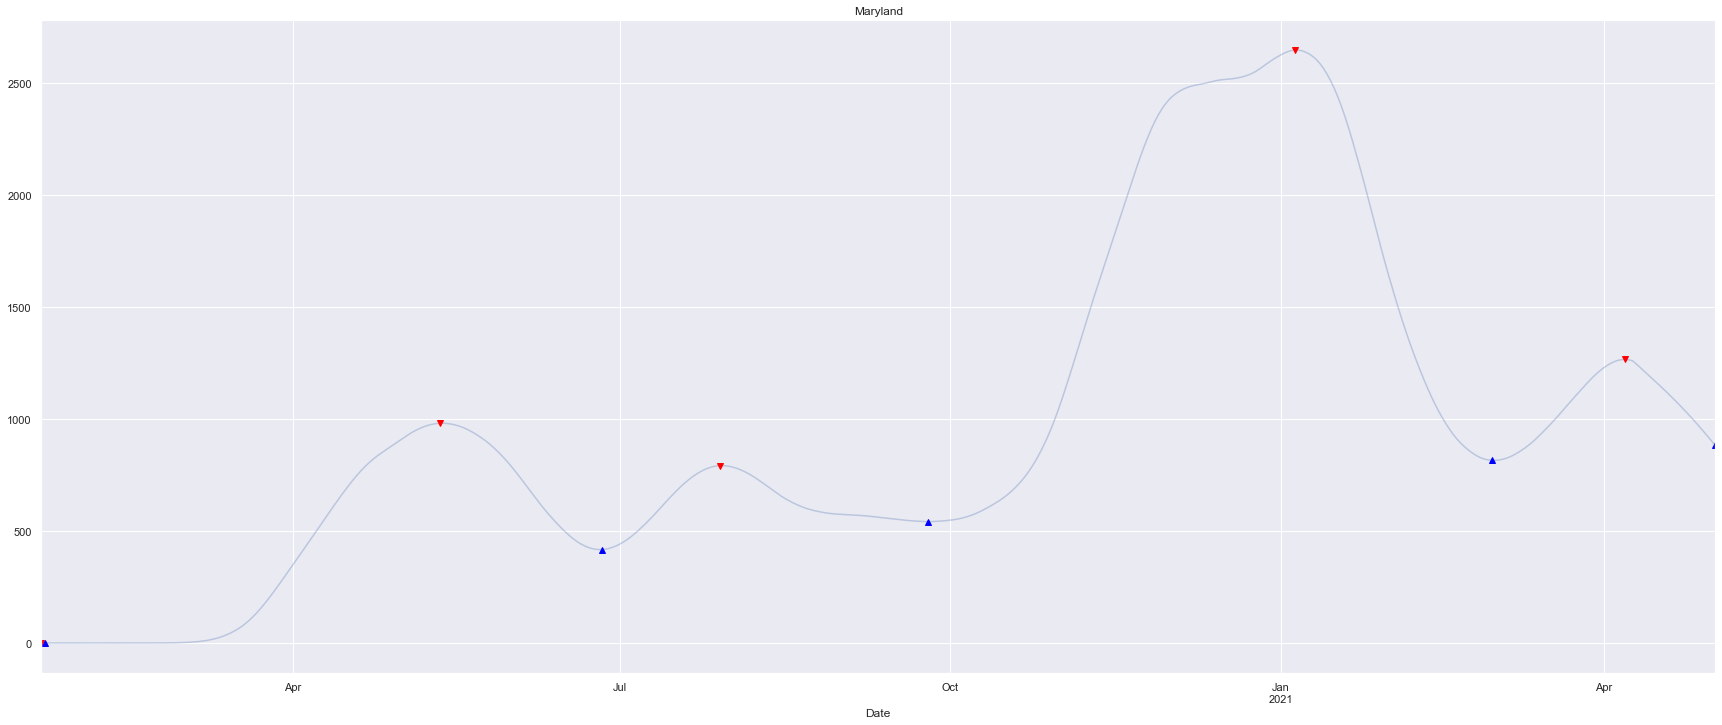

   index  test
0   1913    89
1  -1721    69
2    107    48
3     -3     9
4   4905   135
5  -3594    57
6    450    29
7   -902    30
              new_cases
Date                   
2020-01-22     0.000000
2020-06-28   191.291934
2020-08-24   294.670782
2021-03-04  1605.386676
2021-05-02  1153.359595
[  0 158 215 407 466]
              new_cases
Date                   
2020-04-20  1913.107593
2020-08-15   298.381588
2021-01-06  5199.728346
2021-04-02  2055.781138
[ 89 206 350 436]


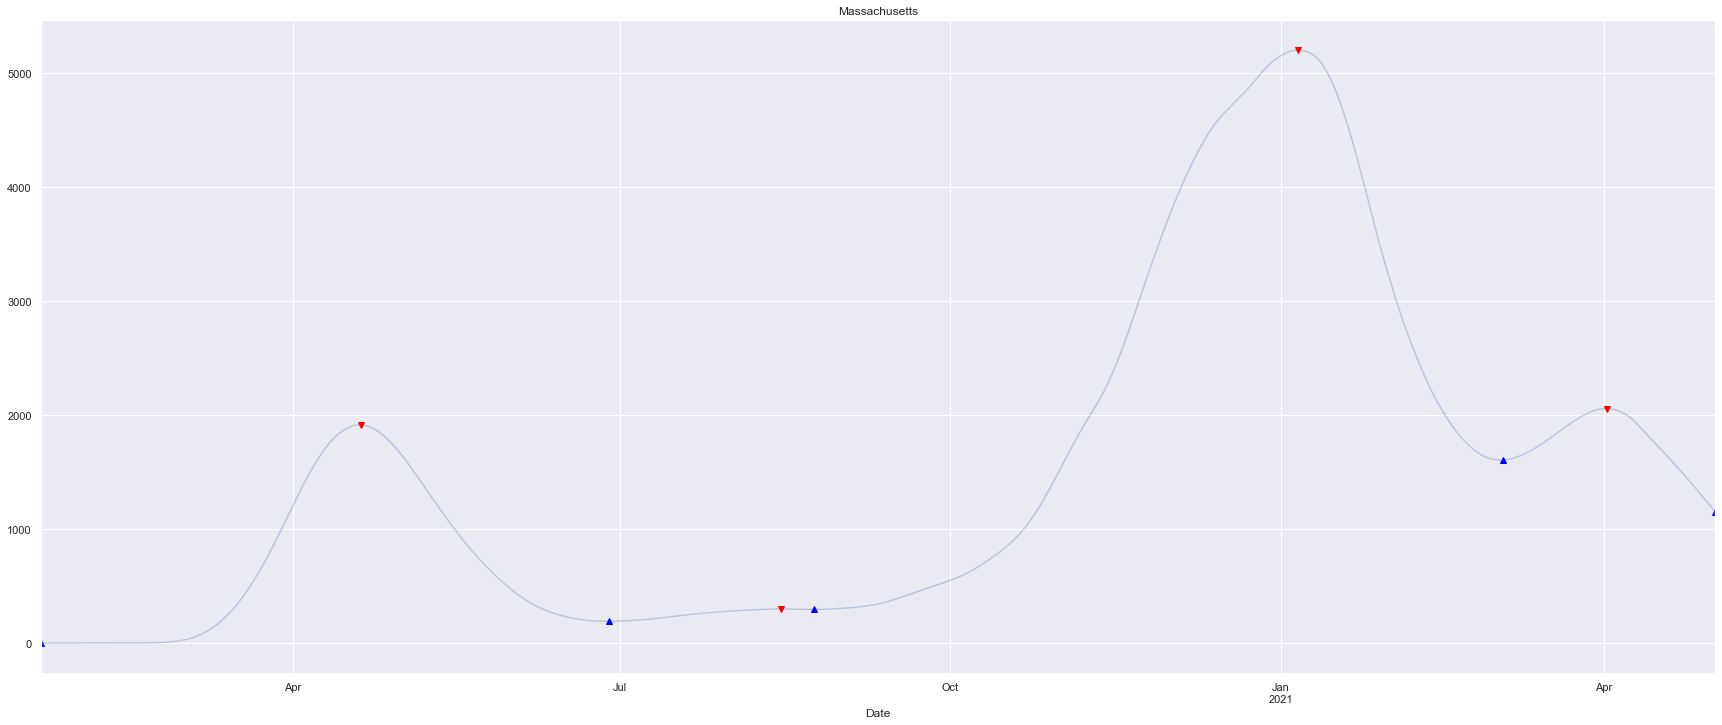

   index   test
0   1167   55.0
1   -891   65.0
2   6619  161.0
3  -5624   86.0
4   5324   51.0
5  -2578   23.0
              new_cases
Date                   
2020-02-16     0.000000
2020-06-15   275.384429
2021-02-17  1269.528866
2021-05-02  4015.242621
[ 25 145 392 466]
              new_cases
Date                   
2020-04-11  1167.268068
2020-11-23  6894.464248
2021-04-09  6594.081851
[ 80 306 443]


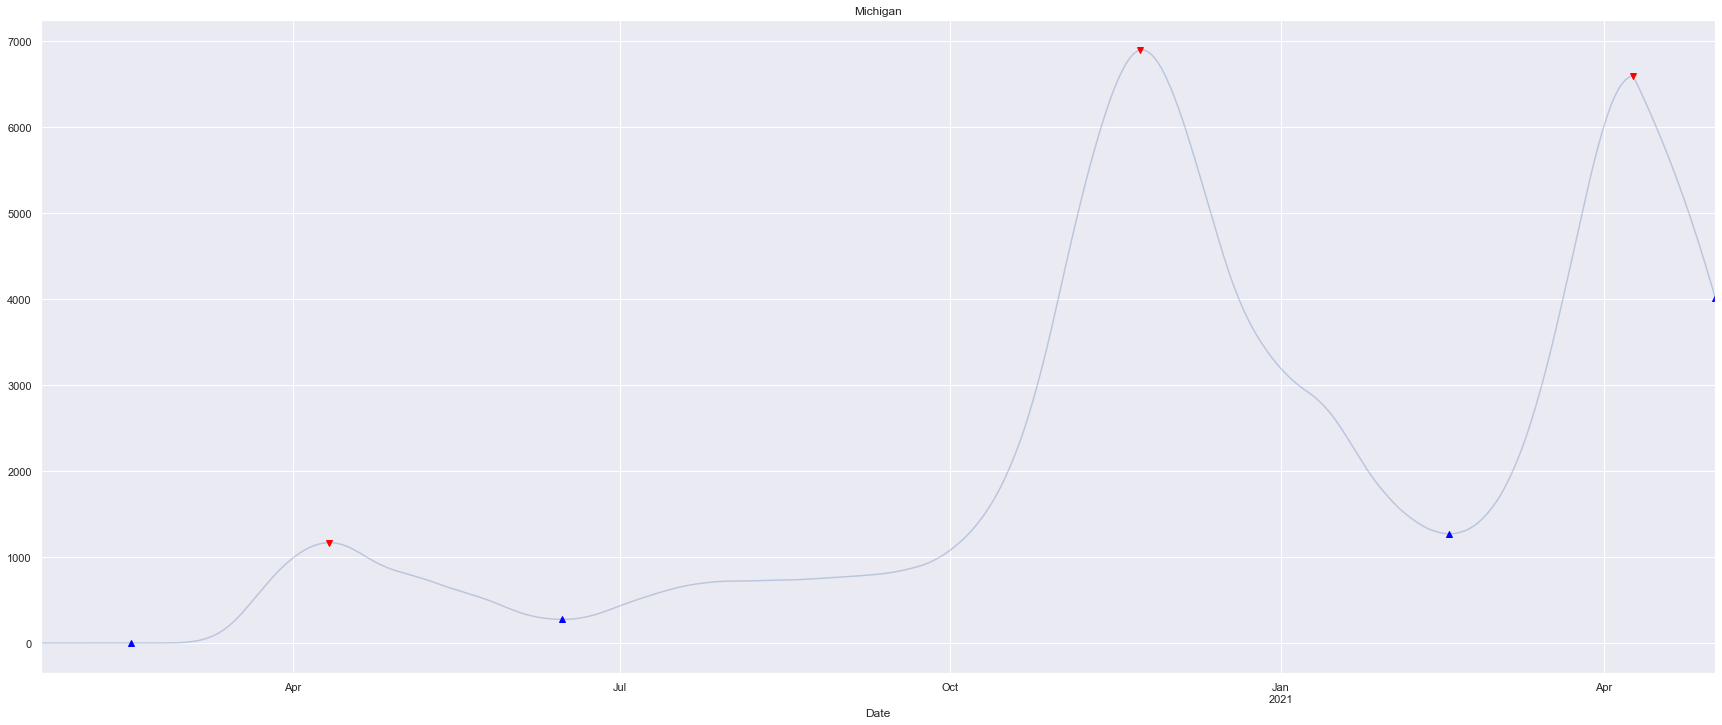

   index   test
0    624  115.0
1   -242   33.0
2    284   45.0
3     -1    4.0
4     29   17.0
5     -2    4.0
6   5240   86.0
7  -5127   89.0
8   1044   49.0
9   -149   23.0
              new_cases
Date                   
2020-01-23    -0.001560
2020-06-19   381.696920
2020-08-07   665.123716
2020-08-28   692.271442
2021-02-19   804.899253
2021-05-02  1699.564807
[  1 149 198 219 394 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-17   624.451519
2020-08-03   666.572856
2020-08-24   694.613105
2020-11-22  5932.281676
2021-04-09  1849.217806
[  0 116 194 215 305 443]


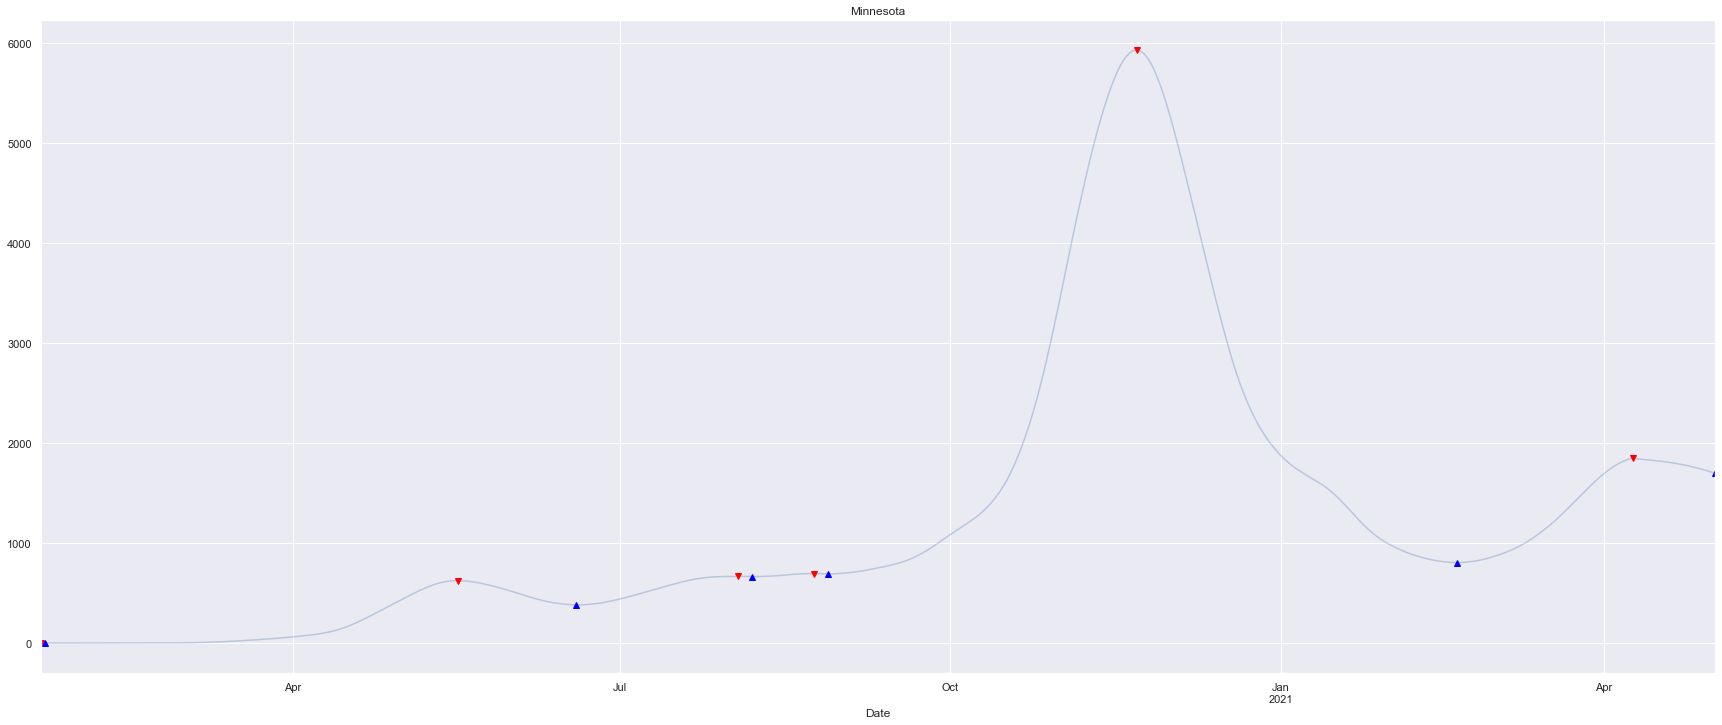

   index   test
0   1086  160.0
1   -584   54.0
2   1576  102.0
3  -1893  124.0
             new_cases
Date                  
2020-02-17    0.000000
2020-09-18  501.898885
2021-05-02  185.350247
[ 26 240 466]
              new_cases
Date                   
2020-07-26  1086.369400
2020-12-29  2078.734296
[186 342]


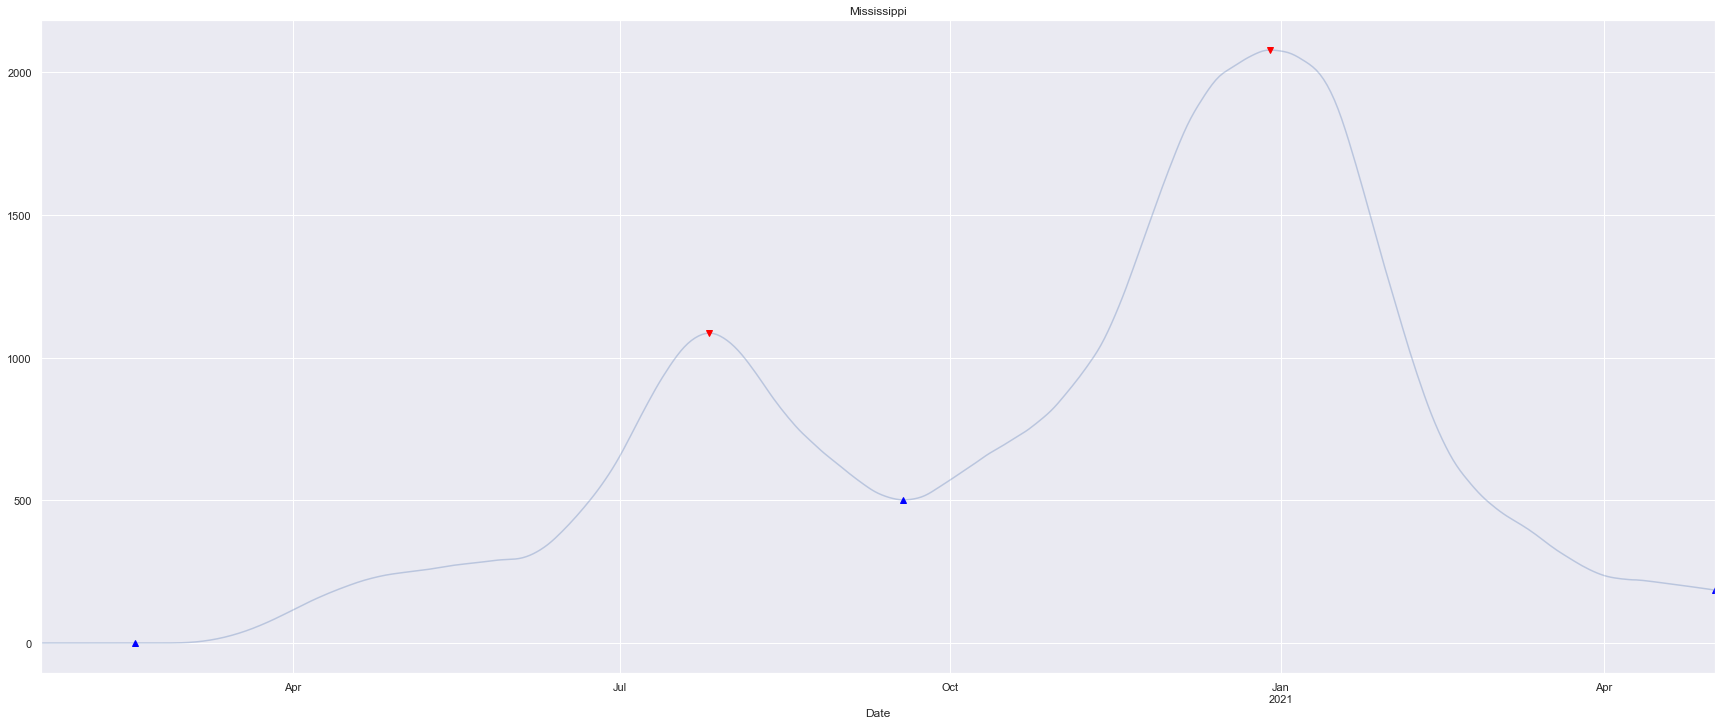

   index   test
0    216   82.0
1    -41   34.0
2   1041   79.0
3    -37    9.0
4   3273  100.0
5  -3847  115.0
6     12    8.0
7   -279   16.0
8     89   22.0
              new_cases
Date                   
2020-01-23    -0.006019
2020-05-18   175.037585
2020-08-14  1178.887719
2021-03-17   604.614504
2021-04-10   337.752265
[  1 117 205 420 444]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-14   216.046448
2020-08-05  1216.192207
2020-11-22  4452.472570
2021-03-25   617.185570
2021-05-02   427.155648
[  0  83 196 305 428 466]


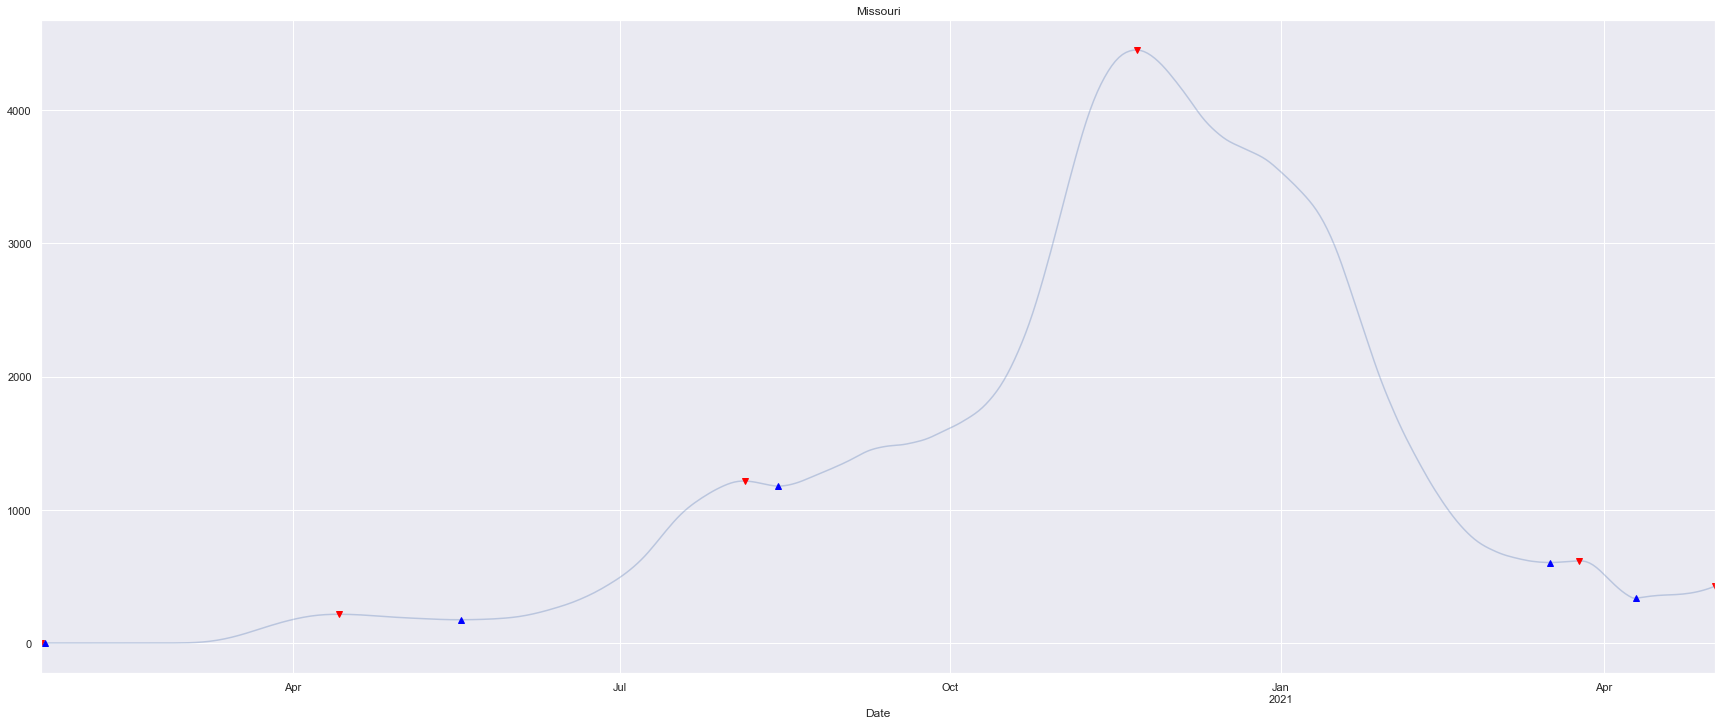

   index   test
0     13   45.0
1    -12   36.0
2    111   83.0
3      0    8.0
4    895  102.0
5   -856  120.0
6      1    8.0
7    -21   37.0
             new_cases
Date                  
2020-02-18    0.000000
2020-05-09    1.259665
2020-08-08  112.250400
2021-03-18  151.505425
2021-05-02  130.964214
[ 27 108 199 421 466]
              new_cases
Date                   
2020-04-03    13.681789
2020-07-31   113.196360
2020-11-18  1008.127848
2021-03-26   152.782398
[ 72 191 301 429]


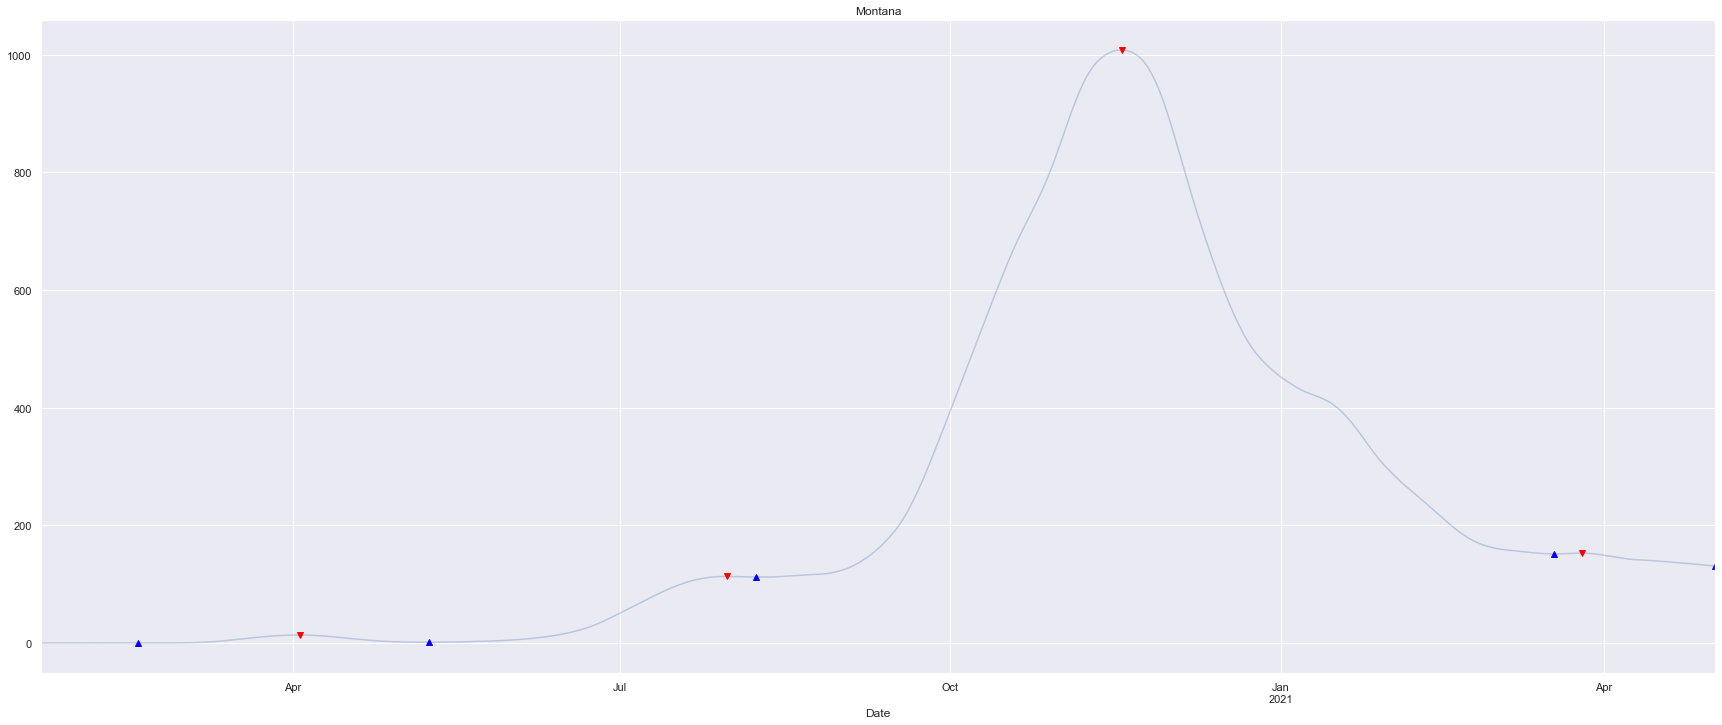

   index   test
0    322  107.0
1   -166   45.0
2    112   41.0
3     -5   10.0
4   1710   98.0
5  -1709  110.0
6    100   29.0
7   -151   25.0
             new_cases
Date                  
2020-01-23   -0.001593
2020-06-23  155.645542
2020-08-13  262.694674
2021-03-09  264.380962
2021-05-02  212.967194
[  1 153 204 412 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-09   322.113056
2020-08-03   268.408396
2020-11-19  1973.418574
2021-04-07   364.455817
[  0 108 194 302 441]


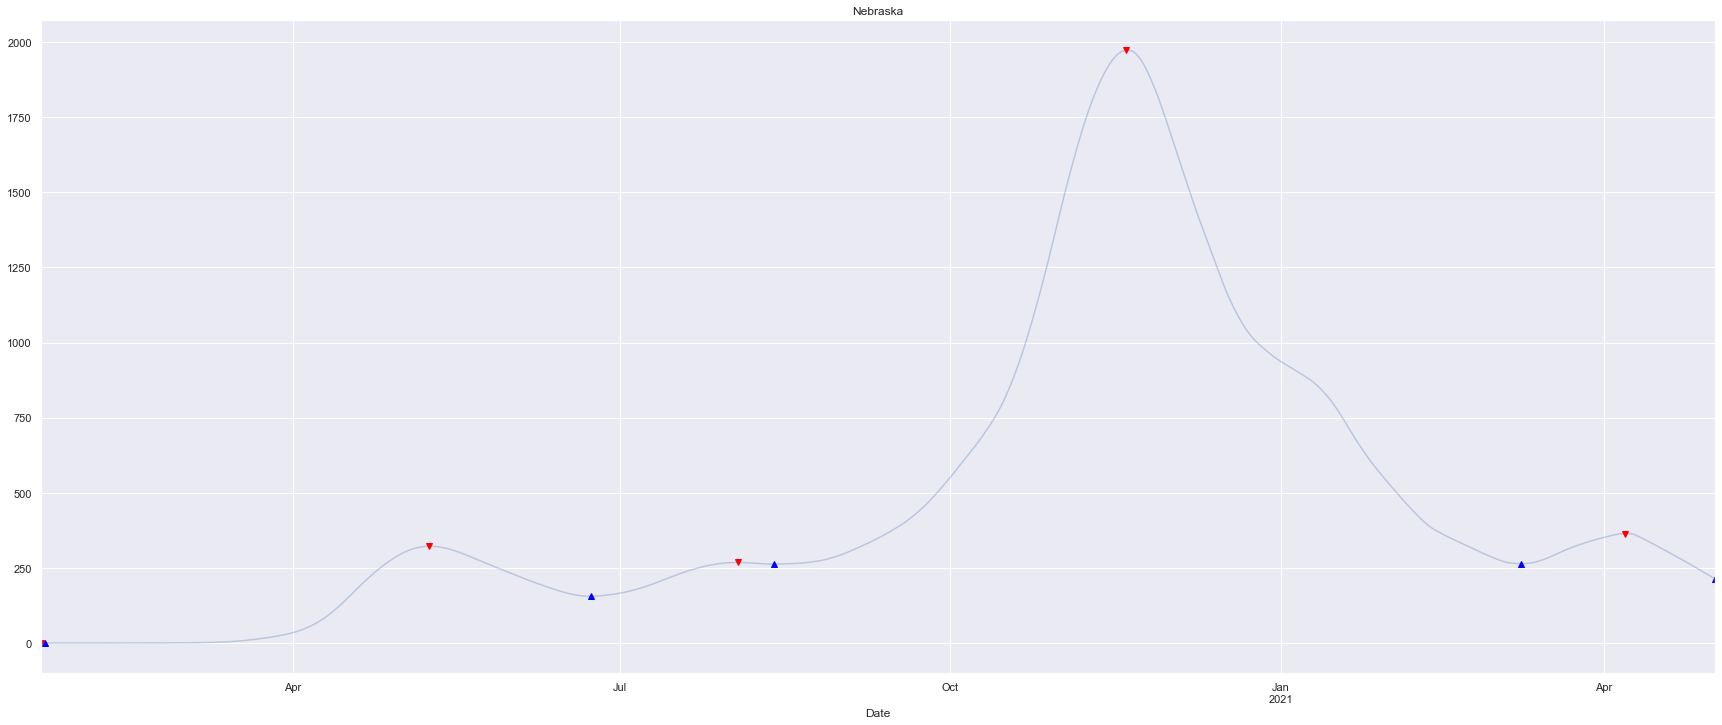

   index   test
0    132   81.0
1    -19   30.0
2    886   71.0
3   -639   51.0
4   2078   86.0
5  -2122  108.0
6     44   19.0
7    -22   19.0
             new_cases
Date                  
2020-01-23   -0.004666
2020-05-13  113.271550
2020-09-12  360.368263
2021-03-25  316.629607
2021-05-02  338.589067
[  1 112 234 428 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-13   132.705266
2020-07-23  1000.160466
2020-12-07  2438.939396
2021-04-13   360.777834
[  0  82 183 320 447]


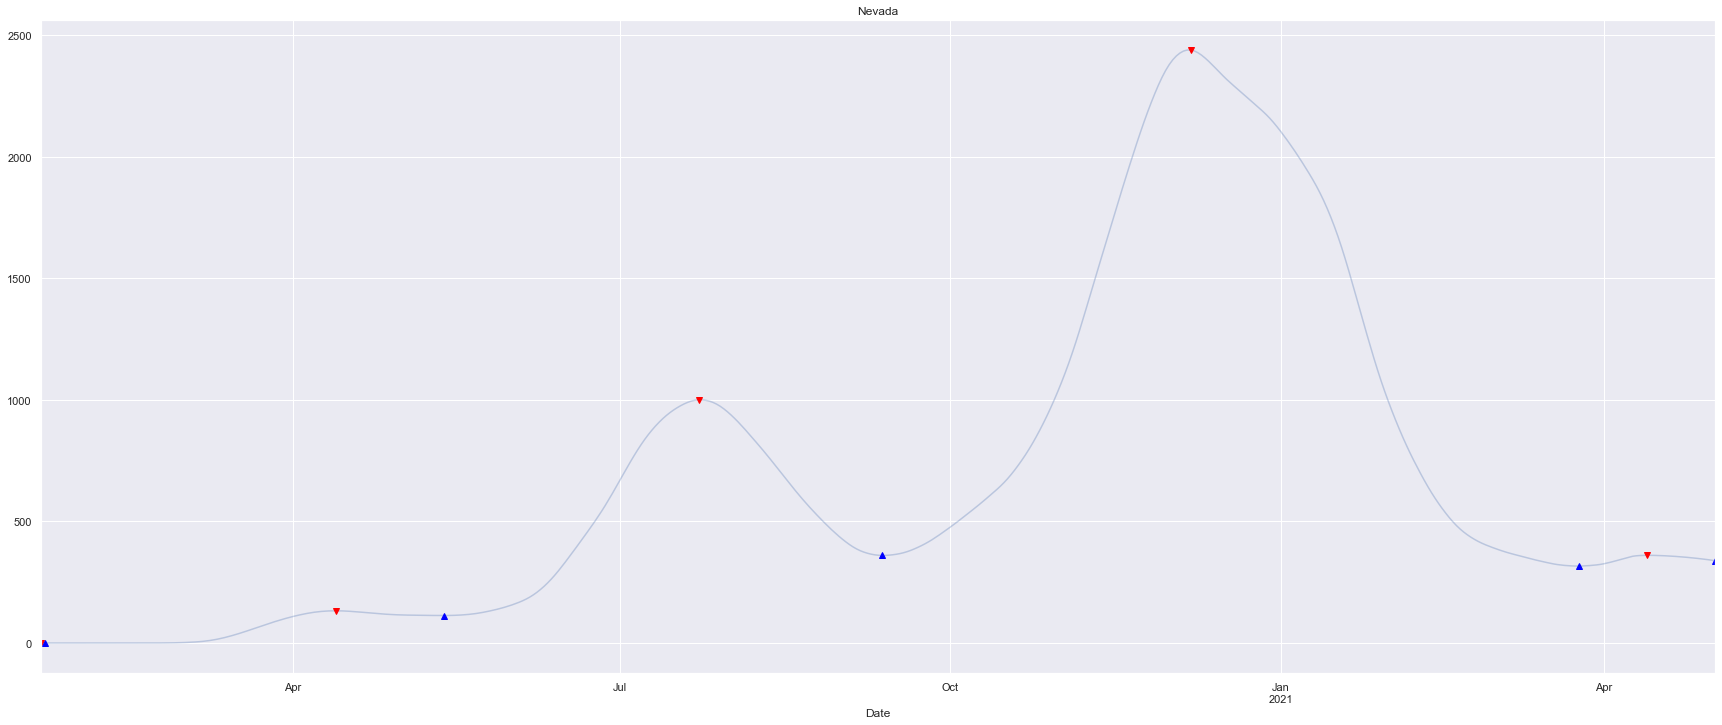

   index   test
0     80  105.0
1    -55   61.0
2      3   21.0
3     -5   23.0
4    736  122.0
5     -1    5.0
6      0    2.0
7   -494   70.0
8    123   30.0
9   -139   26.0
             new_cases
Date                  
2020-01-23   -0.013894
2020-07-07   24.645214
2020-08-20   22.041000
2020-12-25  757.151292
2021-03-07  262.584170
2021-05-02  246.204598
[  1 167 211 338 410 466]
             new_cases
Date                  
2020-01-22    0.000000
2020-05-07   80.027655
2020-07-28   27.709093
2020-12-20  758.419679
2020-12-27  757.223434
2021-04-06  386.089096
[  0 106 188 333 340 440]


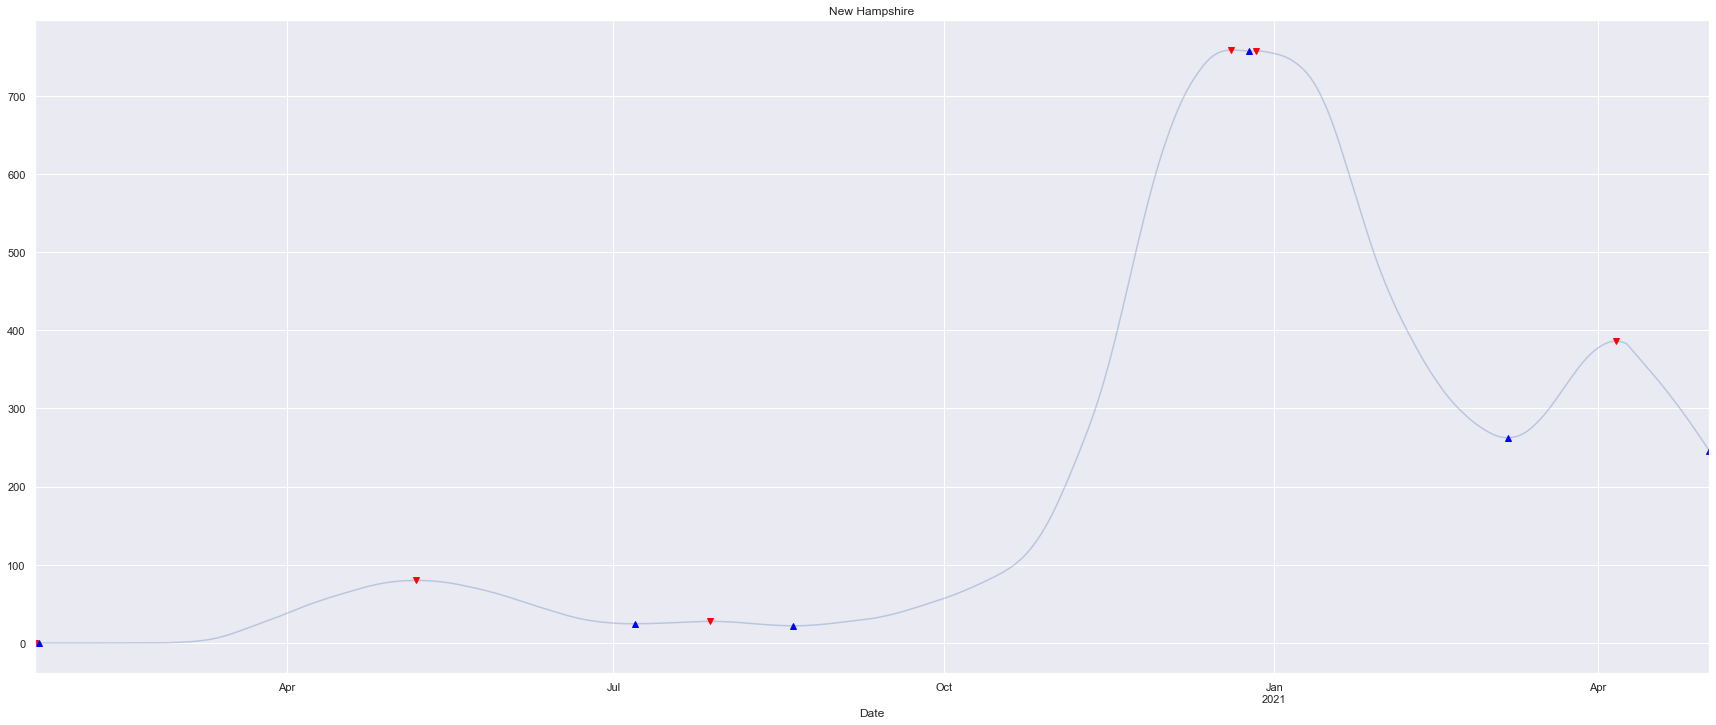

   index   test
0   3286   82.0
1  -2964   83.0
2     89   30.0
3    -40   20.0
4   4820  108.0
5    -76   12.0
6    298   20.0
7  -2139   43.0
8    828   32.0
9  -3182   35.0
              new_cases
Date                   
2020-01-23    -0.007004
2020-07-06   322.404251
2020-08-25   370.936831
2020-12-23  5114.348072
2021-02-24  3273.093701
2021-05-02   918.901168
[  1 166 216 336 399 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-14  3286.886211
2020-08-05   411.825734
2020-12-11  5191.280133
2021-01-12  5412.759899
2021-03-28  4101.740147
[  0  83 196 324 356 431]


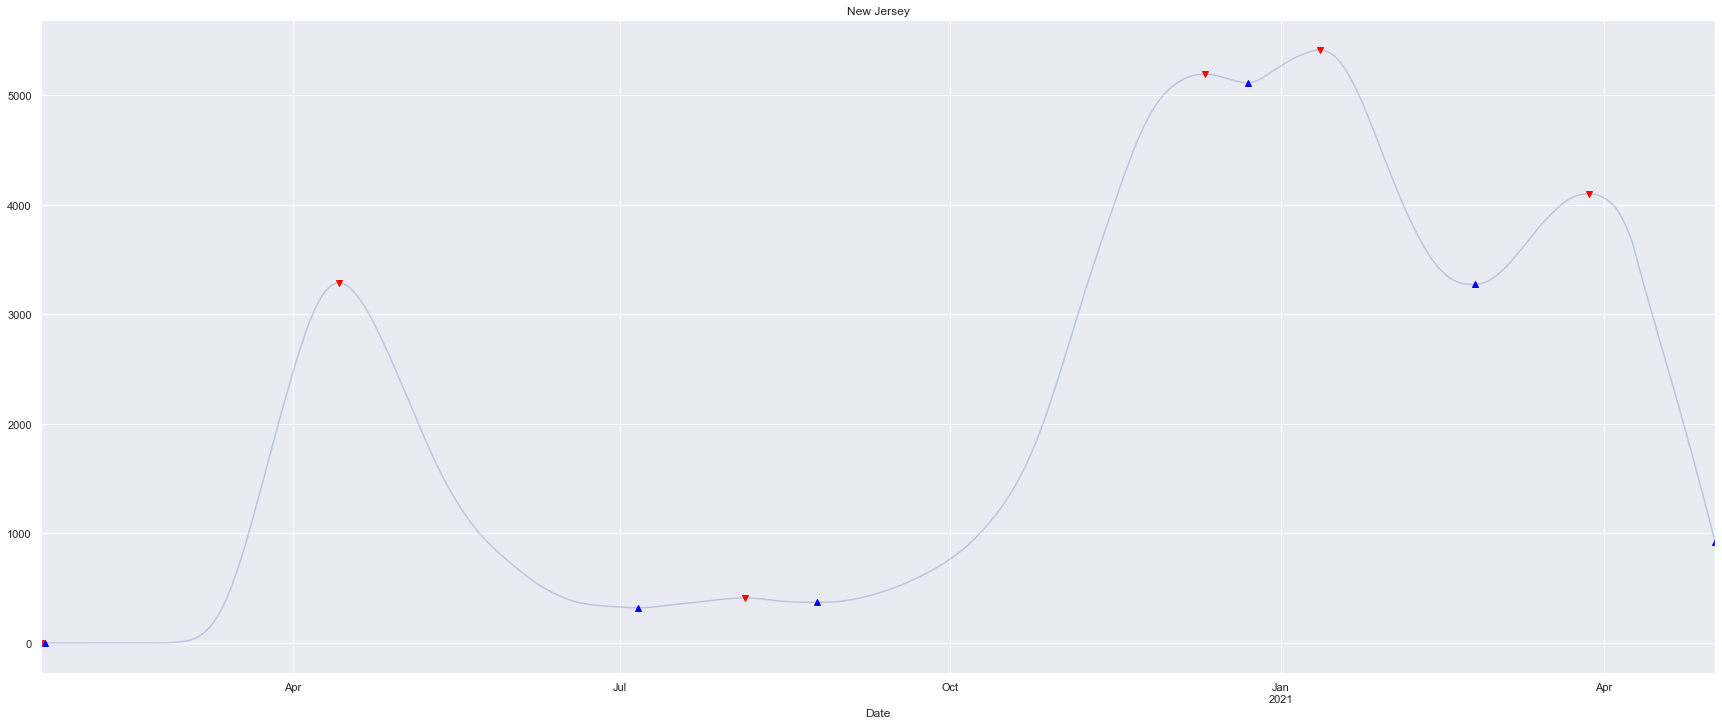

   index   test
0    146   82.0
1    -12   28.0
2    137   44.0
3   -153   48.0
4   1798   83.0
5  -1722  123.0
6      2   11.0
7    -17   22.0
             new_cases
Date                  
2020-02-16    0.000000
2020-06-05  133.835220
2020-09-05  117.326946
2021-03-30  193.030960
2021-05-02  178.145077
[ 25 135 227 433 466]
              new_cases
Date                   
2020-05-08   146.091508
2020-07-19   271.221637
2020-11-27  1915.964524
2021-04-10   195.473116
[107 179 310 444]


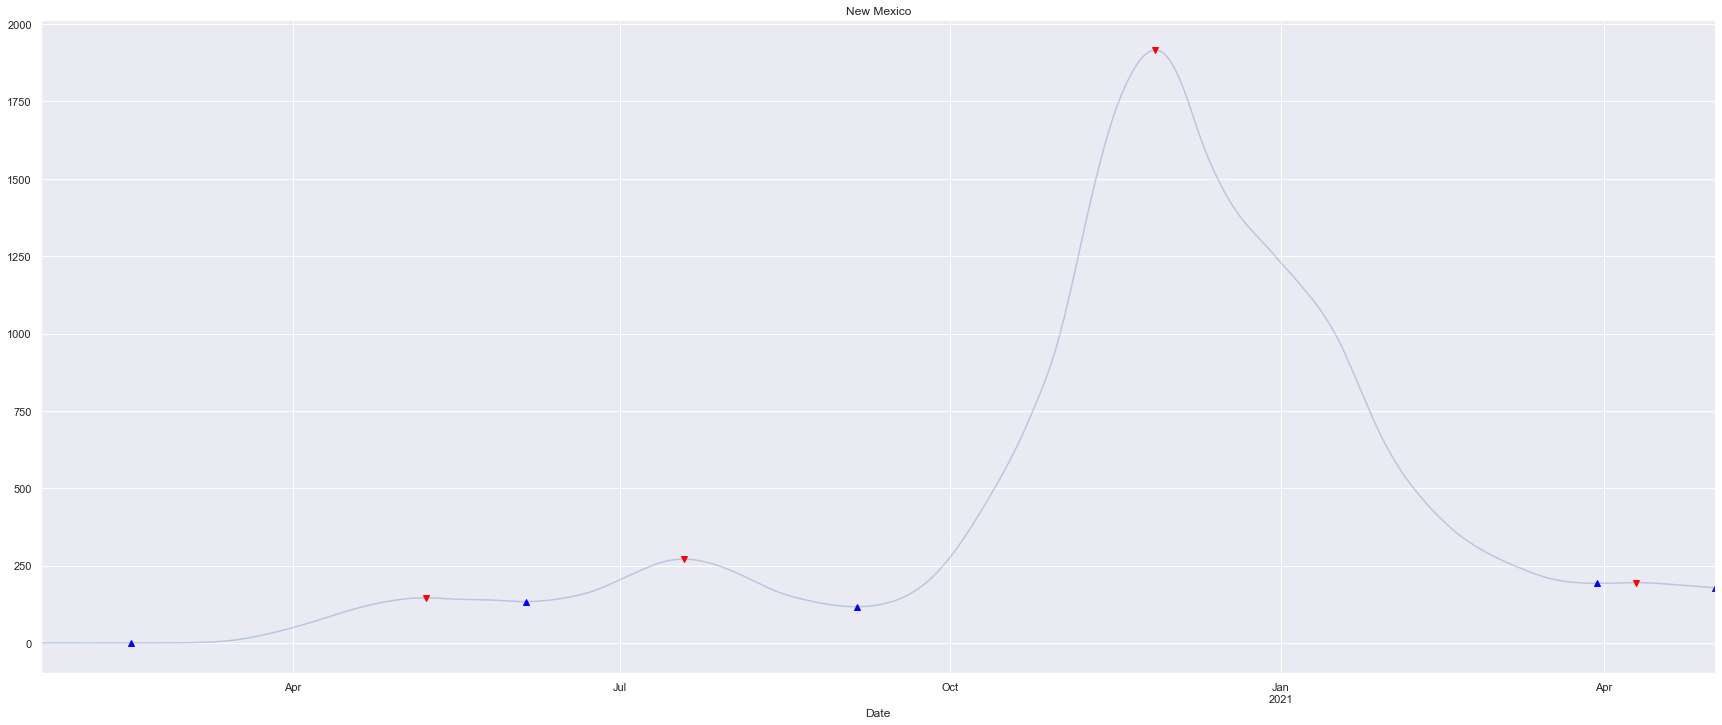

   index   test
0   8243   76.0
1  -7568   79.0
2     40   17.0
3   -104   31.0
4  13640  152.0
5  -7183   53.0
6    569   22.0
7  -4601   35.0
              new_cases
Date                   
2020-01-23    -0.121946
2020-06-26   674.916891
2020-08-13   610.344543
2021-03-06  7066.813835
2021-05-02  3035.015665
[  1 156 204 409 466]
               new_cases
Date                    
2020-01-22      0.000000
2020-04-08   8243.325406
2020-07-13    715.104326
2021-01-12  14250.698232
2021-03-28   7636.100649
[  0  77 173 356 431]


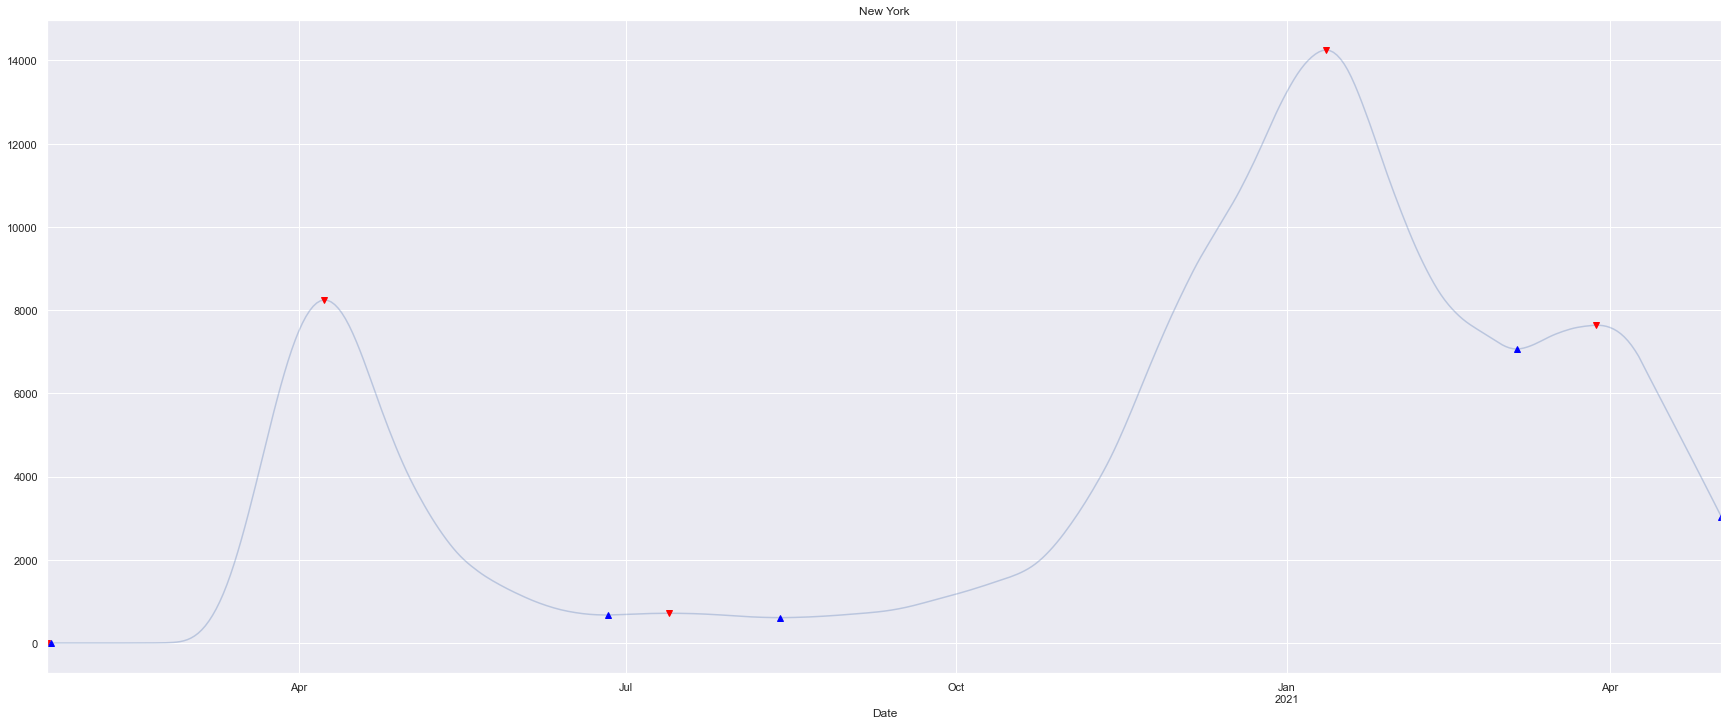

   index   test
0   1879  178.0
1   -570   60.0
2   5835  116.0
3  -5467   70.0
4    152   19.0
5   -224   22.0
              new_cases
Date                   
2020-01-23    -0.009330
2020-09-17  1308.559229
2021-03-22  1676.519435
2021-05-02  1604.643359
[  1 239 425 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-07-19  1879.462105
2021-01-11  7144.152890
2021-04-10  1828.712043
[  0 179 355 444]


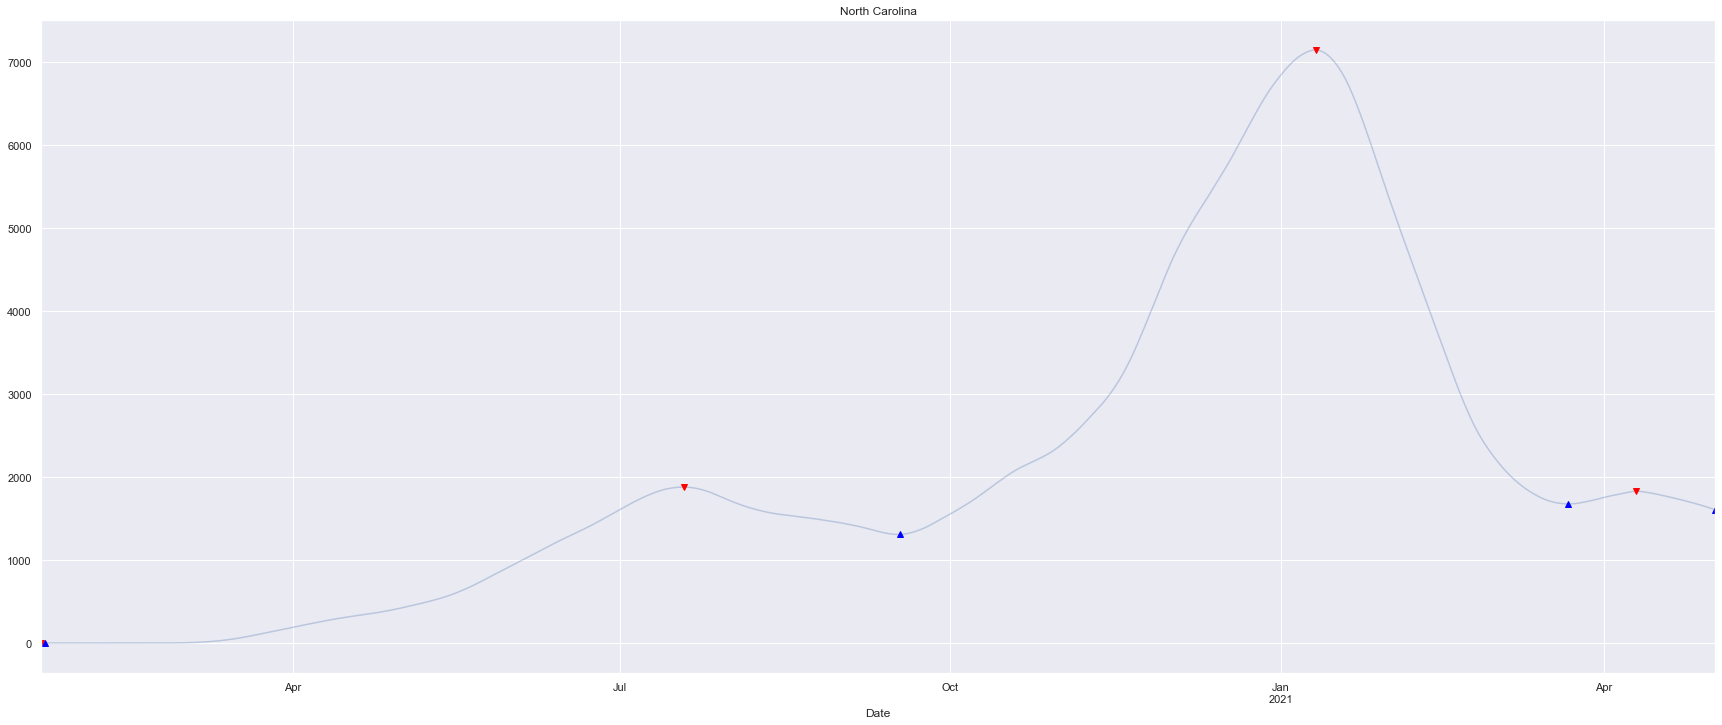

   index   test
0     51   84.0
1    -19   32.0
2   1189  151.0
3  -1142  100.0
4     67   50.0
5    -12   23.0
             new_cases
Date                  
2020-02-17    0.000000
2020-06-12   32.533649
2021-02-18   79.606952
2021-05-02  134.878565
[ 26 142 393 466]
              new_cases
Date                   
2020-05-11    51.763917
2020-11-10  1222.514887
2021-04-09   147.052778
[110 293 443]


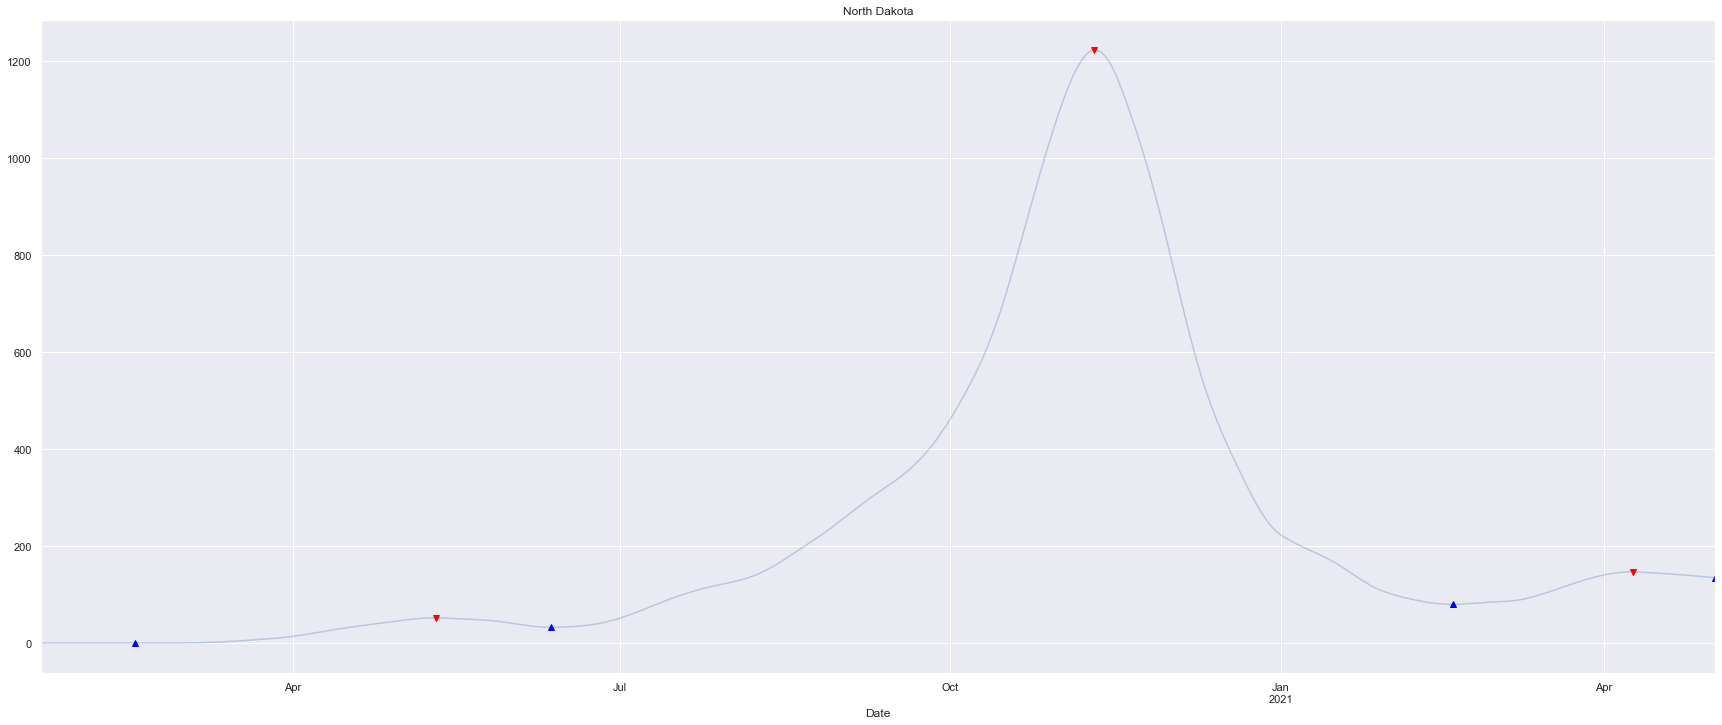

   index  test
0    611  73.0
1   -140  37.0
2    801  48.0
3   -227  37.0
4      1   5.0
5    -22  14.0
6   8479  80.0
7  -7895  99.0
8    281  24.0
9   -407  25.0
              new_cases
Date                   
2020-02-15     0.000000
2020-06-04   470.759819
2020-08-28  1044.947516
2020-09-16  1023.846094
2021-03-14  1608.118561
2021-05-02  1482.541509
[ 24 134 219 238 417 466]
              new_cases
Date                   
2020-04-28   611.275292
2020-07-22  1272.344301
2020-09-02  1046.381521
2020-12-05  9503.817067
2021-04-07  1889.564871
[ 97 182 224 318 441]


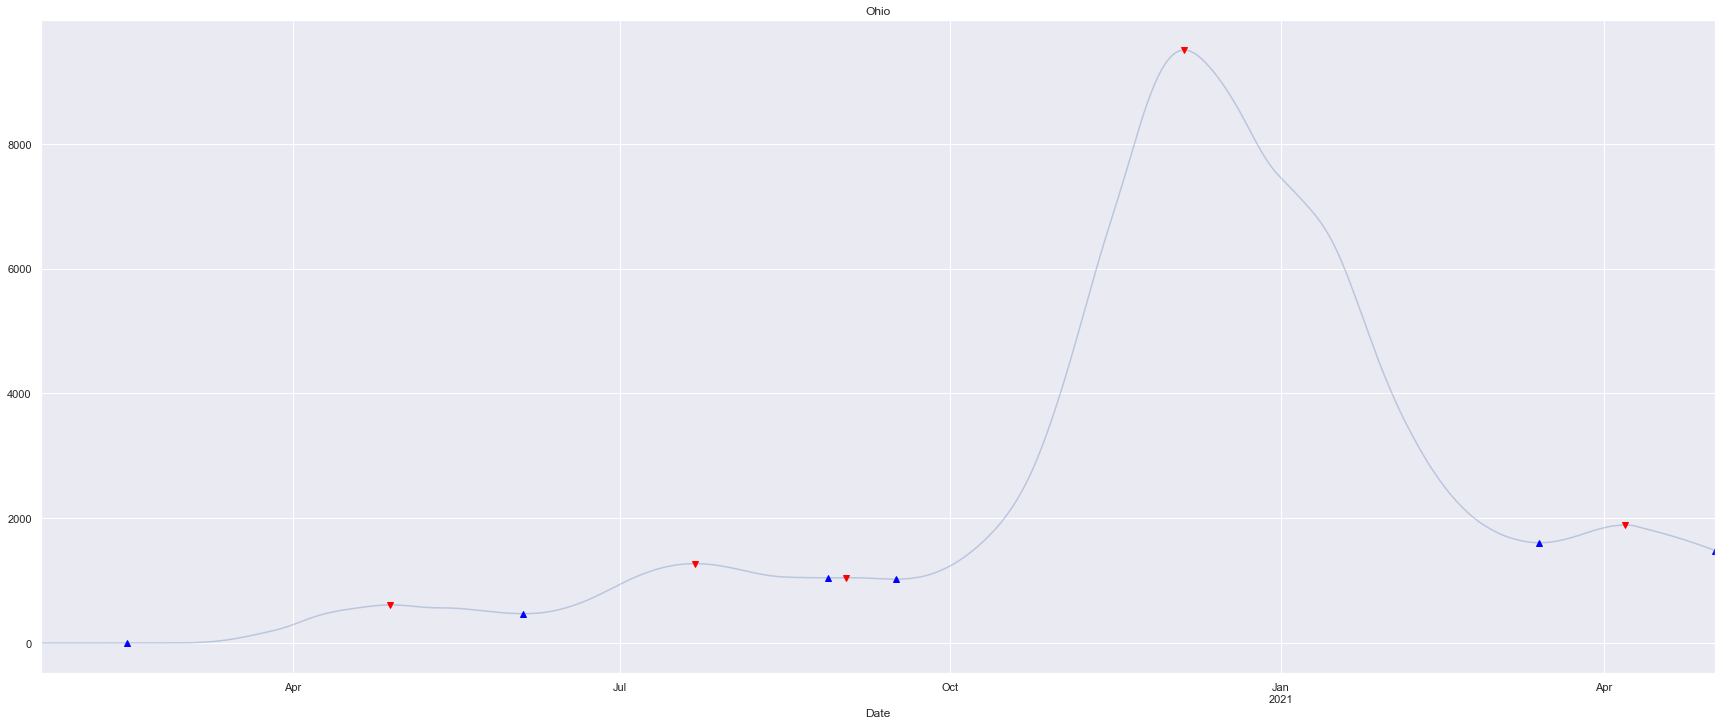

   index   test
0     98   83.0
1     -4   12.0
2      2   11.0
3     -4   13.0
4    726   69.0
5   -105   21.0
6   2324  112.0
7     -5    3.0
8    340   21.0
9  -3182  120.0
              new_cases
Date                   
2020-01-23    -0.000719
2020-04-27    94.101703
2020-05-21    92.342270
2020-08-19   713.530587
2020-12-12  3033.014470
2021-05-02   191.074106
[  1  96 120 210 325 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-15    98.415992
2020-05-08    96.684762
2020-07-29   818.915612
2020-12-09  3038.173108
2021-01-02  3373.761405
[  0  84 107 189 322 346]


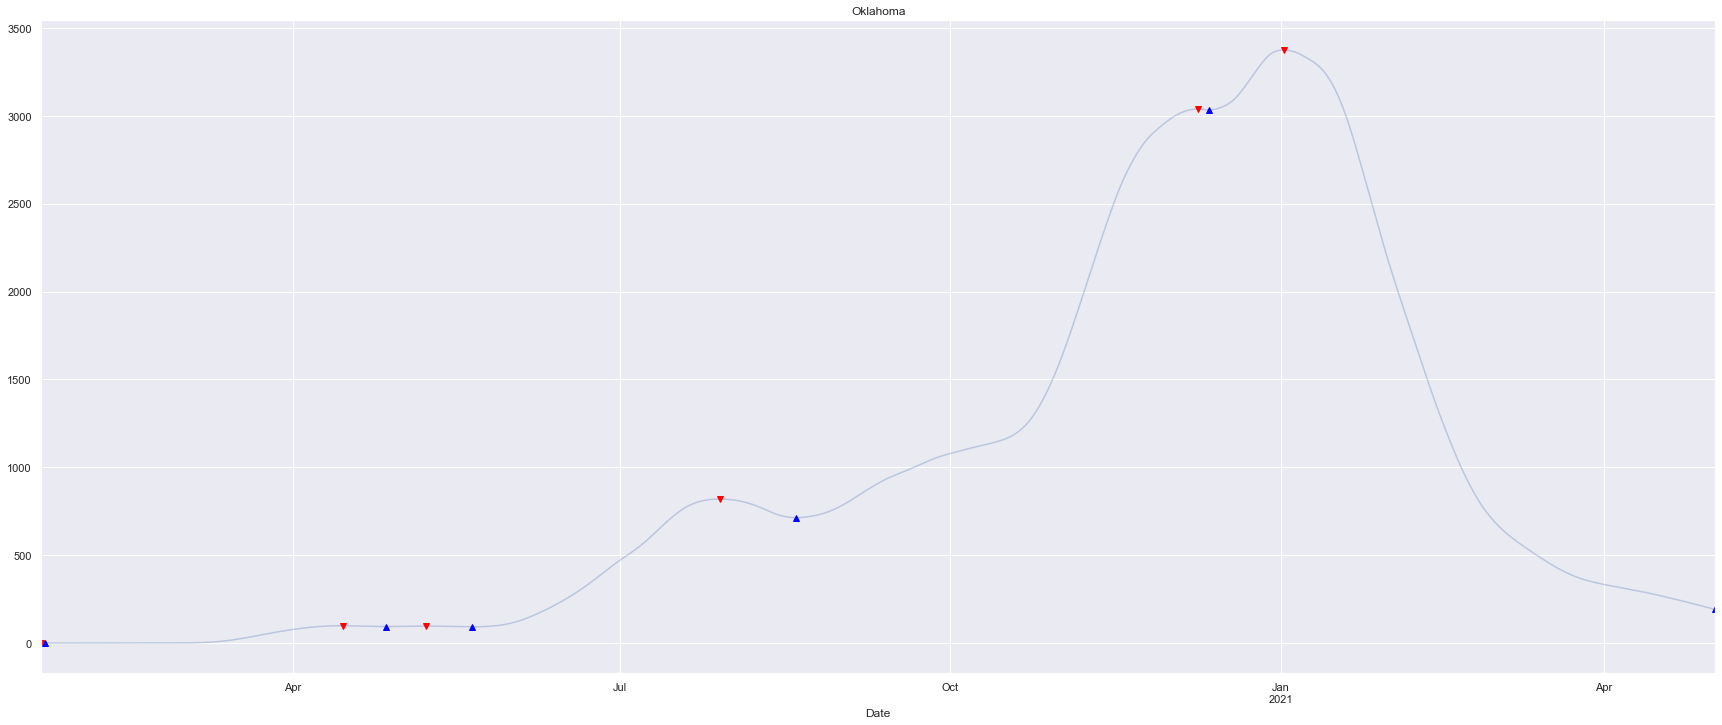

   index  test
0     62  79.0
1     -1   9.0
2      0   9.0
3     -7  20.0
4    266  67.0
5   -107  42.0
6   1125  91.0
7  -1034  97.0
8    596  51.0
             new_cases
Date                  
2020-01-23   -0.030888
2020-04-20   60.964449
2020-05-19   54.772599
2020-09-05  213.751616
2021-03-12  305.346184
[  1  89 118 227 415]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-11    62.397470
2020-04-29    61.803977
2020-07-25   321.620634
2020-12-05  1339.441404
2021-05-02   902.117380
[  0  80  98 185 318 466]


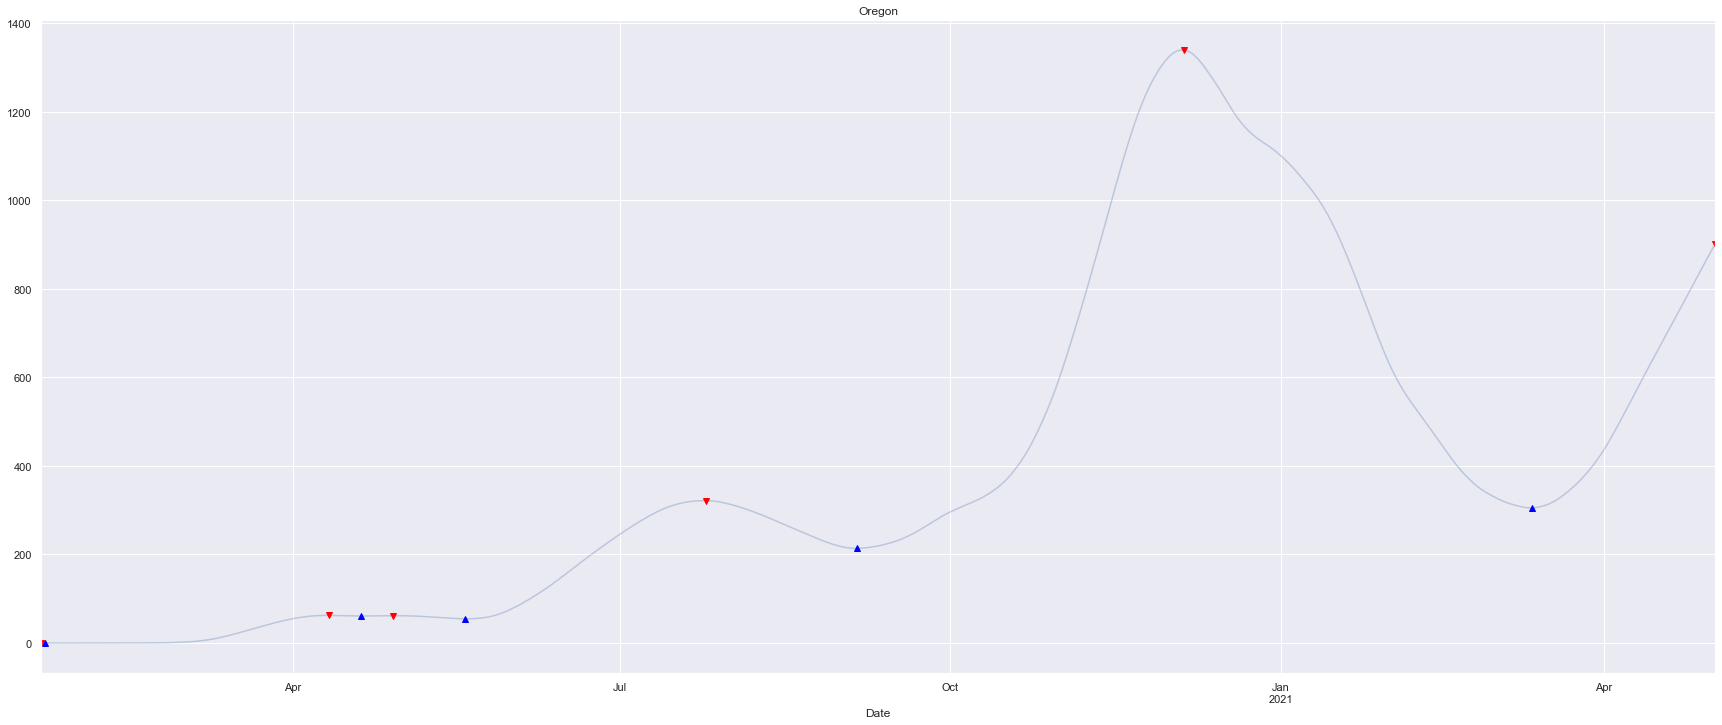

   index   test
0   1404   86.0
1   -899   57.0
2    340   42.0
3   -124   26.0
4   8237  114.0
5  -6367   80.0
6   1667   37.0
7   -868   23.0
              new_cases
Date                   
2020-01-23    -0.004037
2020-06-14   504.874113
2020-08-21   721.192702
2021-03-03  2591.251292
2021-05-02  3389.884618
[  1 144 212 406 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-18  1404.227483
2020-07-26   845.432192
2020-12-13  8958.556403
2021-04-09  4258.410031
[  0  87 186 326 443]


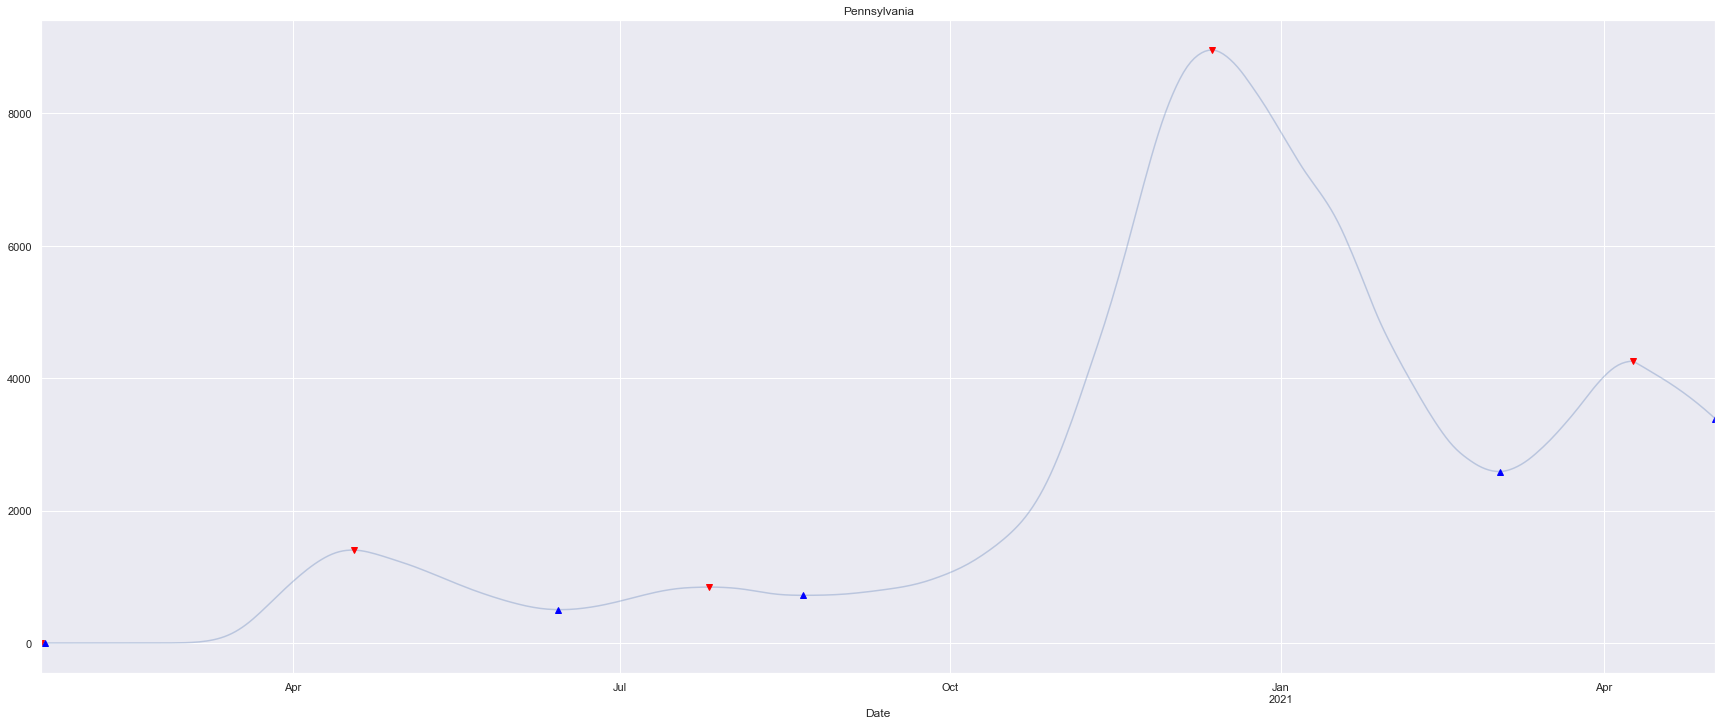

    index  test
0     306  92.0
1    -255  67.0
2      46  41.0
3      -6  16.0
4       2  10.0
5       0   4.0
6     971  86.0
7    -124  31.0
8       3   4.0
9    -593  53.0
10     38  33.0
11   -160  28.0
             new_cases
Date                  
2020-01-23   -0.017947
2020-06-30   50.687848
2020-08-26   90.367642
2020-09-09   92.810712
2021-01-04  939.475553
2021-03-02  349.308710
2021-05-02  227.301826
[  1 160 217 231 348 405 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-24   306.618217
2020-08-10    96.763647
2020-09-05    93.043852
2020-12-04  1063.855461
2021-01-08   942.743826
2021-04-04   387.720634
[  0  93 201 227 317 352 438]


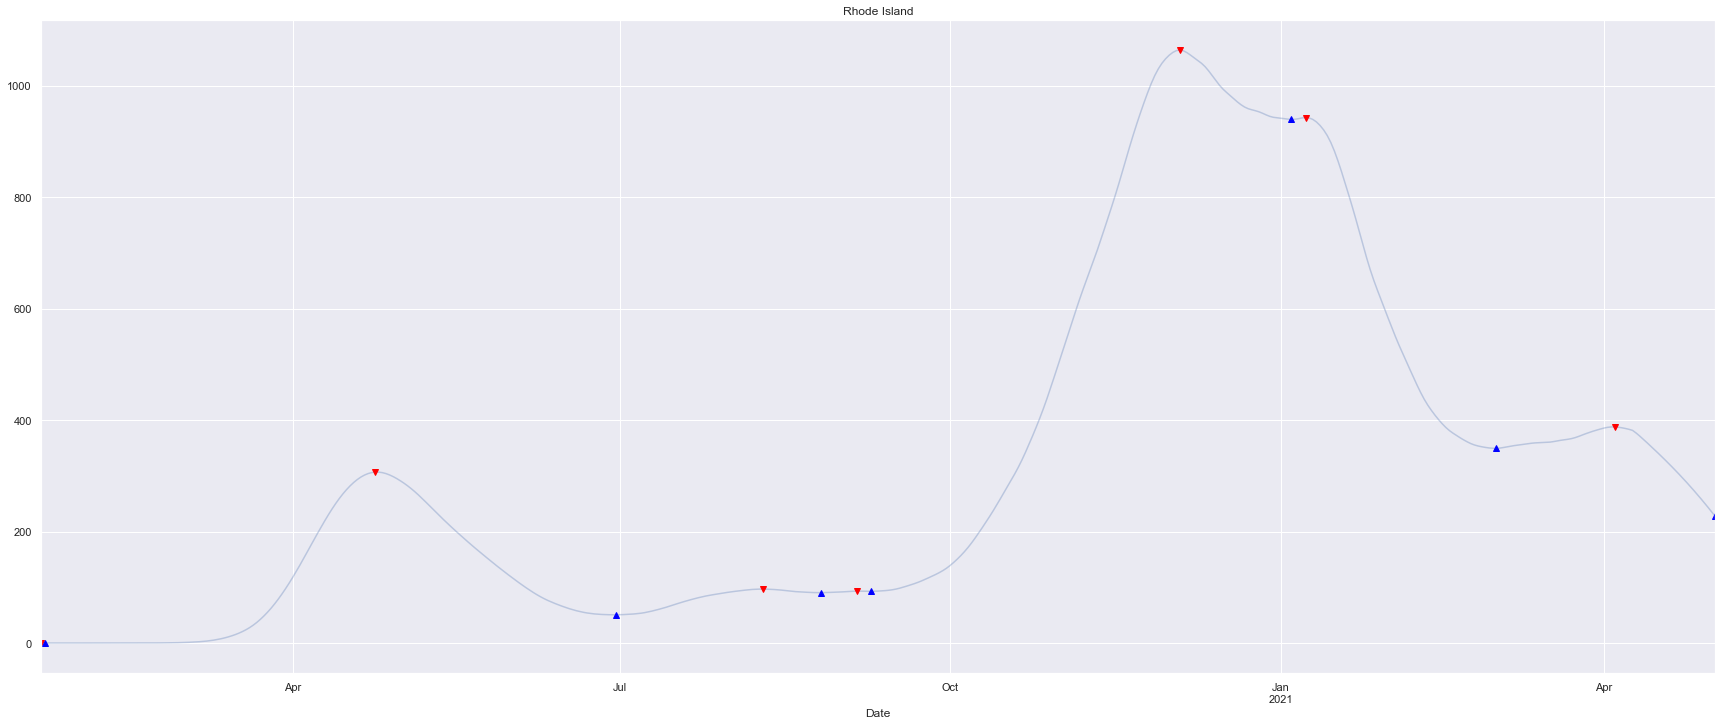

   index   test
0    162   84.0
1     -6   13.0
2   1539   77.0
3   -821   42.0
4     98   19.0
5    -71   26.0
6   3473   95.0
7  -3610  109.0
             new_cases
Date                  
2020-01-23   -0.001472
2020-04-29  156.612348
2020-08-26  875.033432
2020-10-10  901.840020
2021-05-02  764.511460
[  1  98 217 262 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-16   162.728707
2020-07-15  1696.459085
2020-09-14   973.088546
2021-01-13  4375.423128
[  0  85 175 236 357]


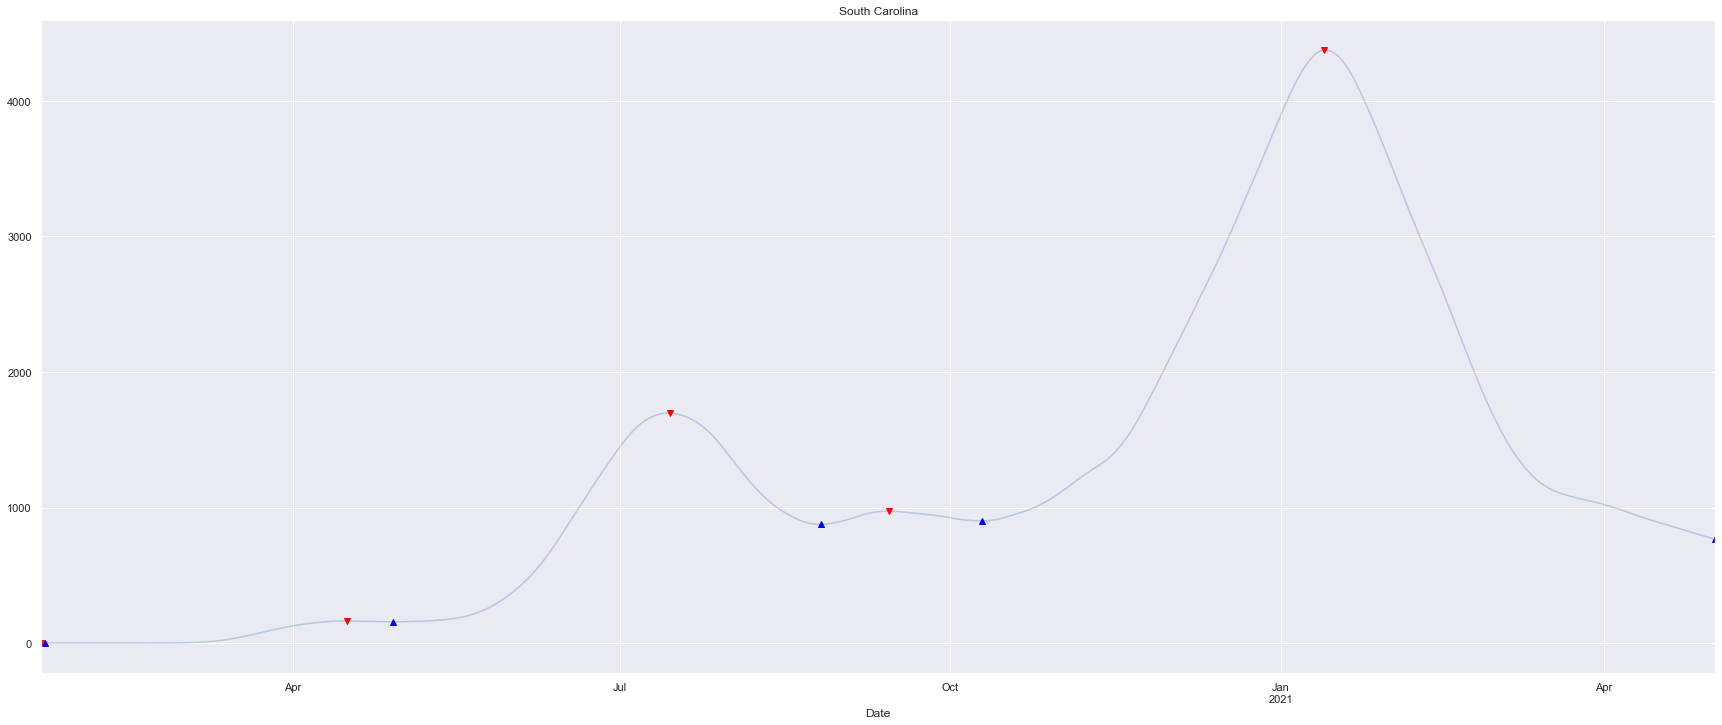

   index   test
0     91   71.0
1    -33   65.0
2   1139  132.0
3  -1047   95.0
4     36   48.0
5    -94   30.0
             new_cases
Date                  
2020-02-16    0.000000
2020-07-01   57.917222
2021-02-13  150.106503
2021-05-02   92.381707
[ 25 161 388 466]
              new_cases
Date                   
2020-04-27    91.392304
2020-11-10  1197.300282
2021-04-02   186.971452
[ 96 293 436]


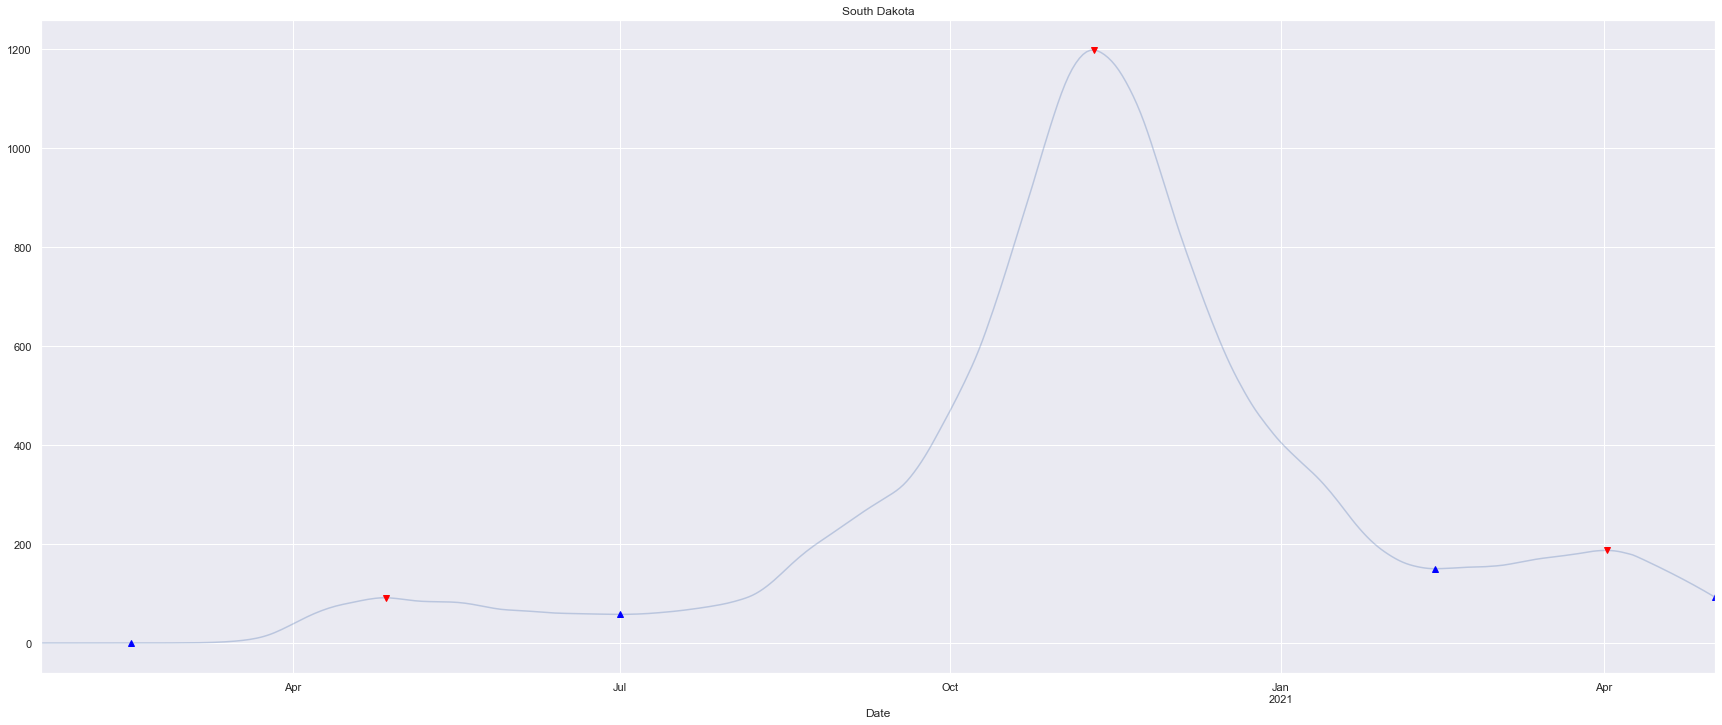

   index   test
0    381  105.0
1     -7    8.0
2   1710   70.0
3   -706   54.0
4   5783   96.0
5  -6008   98.0
6     40   11.0
7   -249   23.0
              new_cases
Date                   
2020-01-23    -0.003139
2020-05-15   373.920033
2020-09-16  1378.580854
2021-03-29  1154.281614
2021-05-02   945.111500
[  1 114 238 432 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-07   381.070720
2020-07-24  2084.887641
2020-12-21  7162.373710
2021-04-09  1195.017957
[  0 106 184 334 443]


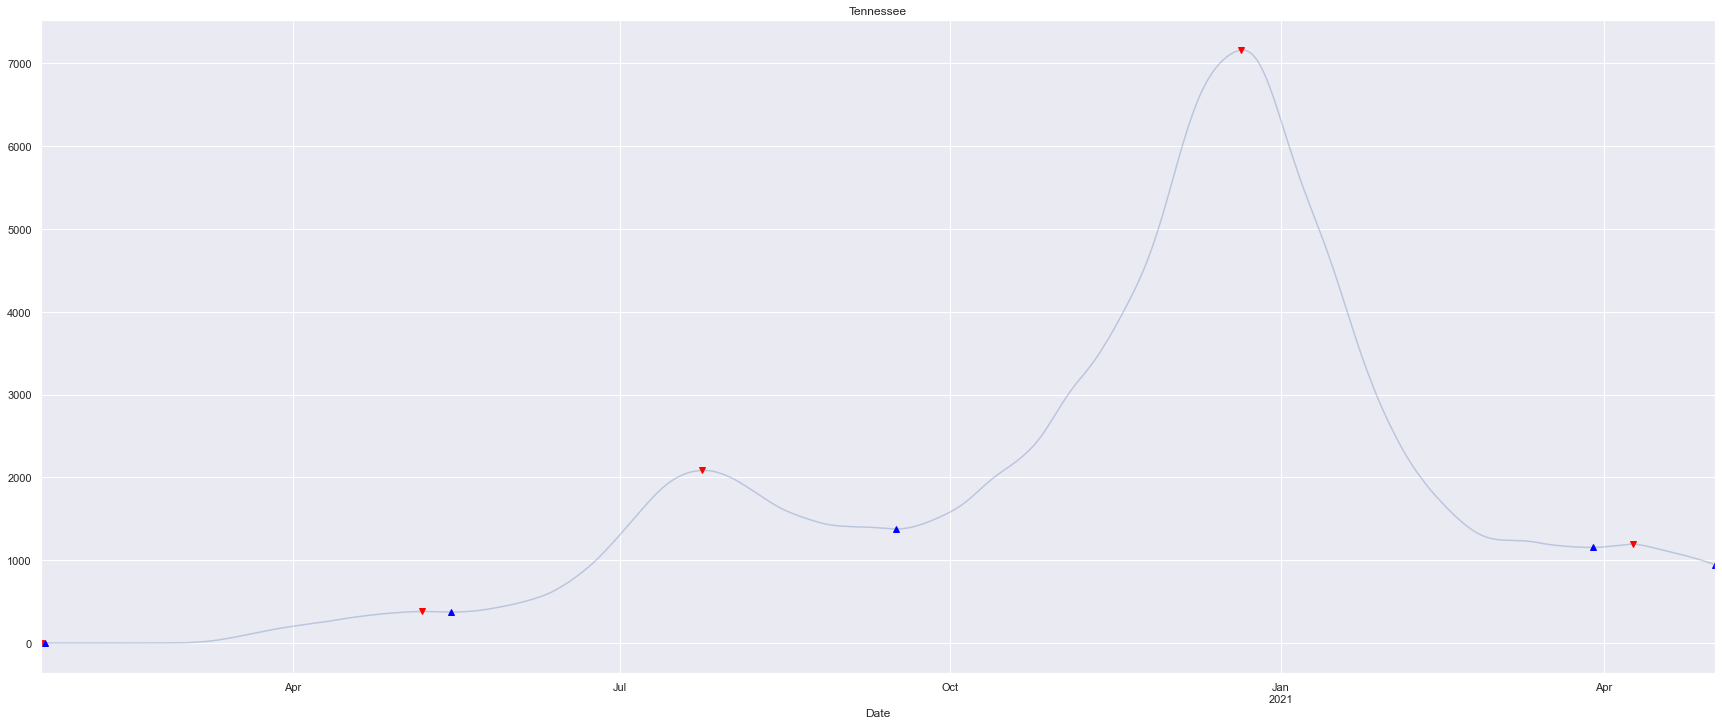

   index   test
0   8920  179.0
1  -4402   46.0
2    455   24.0
3   -119    9.0
4  15157  100.0
5 -16983  107.0
              new_cases
Date                   
2020-01-23    -0.013174
2020-09-04  4517.603952
2020-10-07  4853.391187
2021-05-02  3027.791483
[  1 226 259 466]
               new_cases
Date                    
2020-01-22      0.000000
2020-07-20   8920.387039
2020-09-28   4973.036912
2021-01-15  20010.904828
[  0 180 250 359]


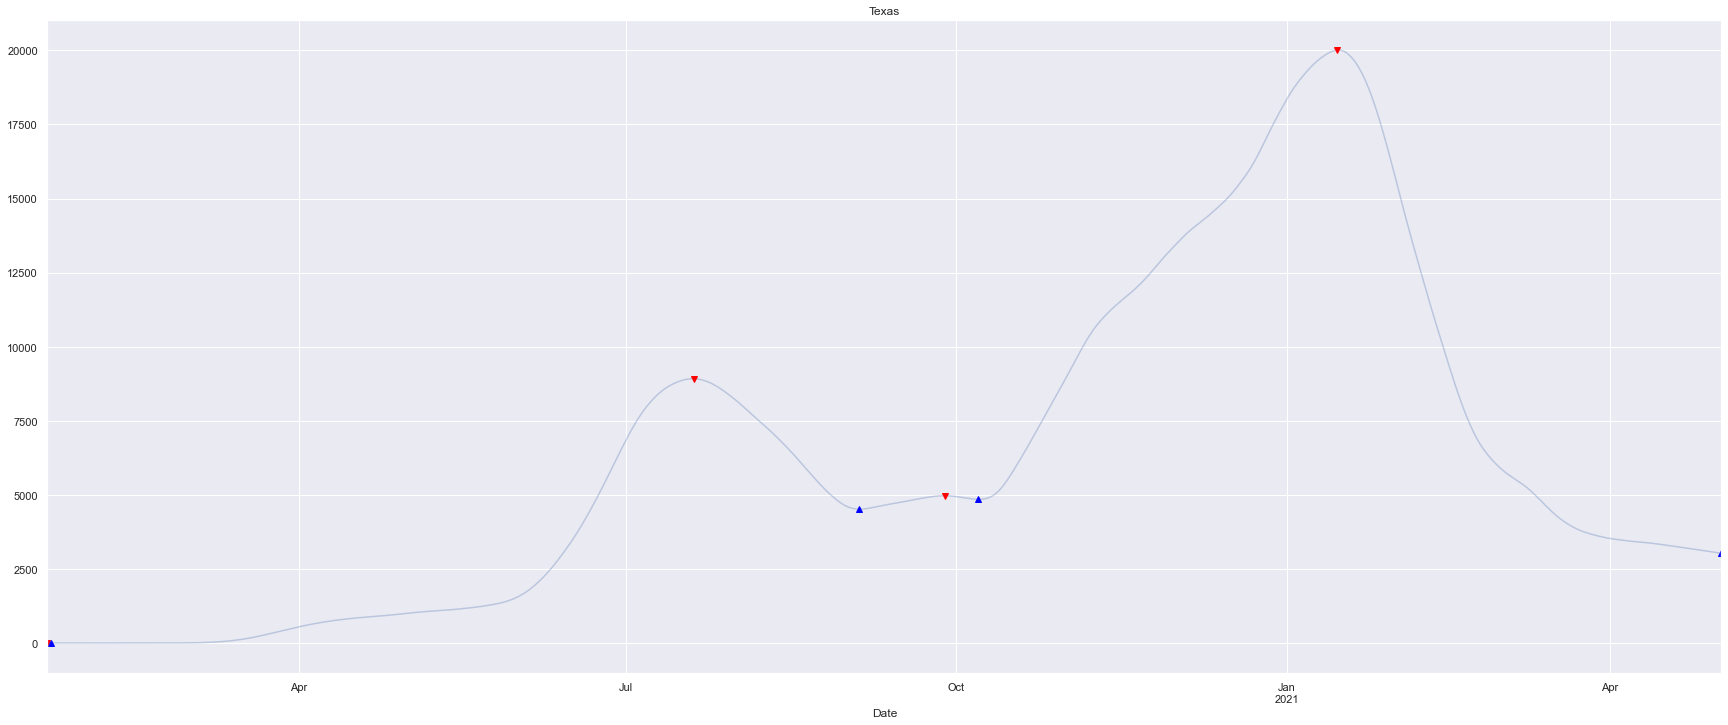

   index   test
0    594  170.0
1   -216   41.0
2   2533   95.0
3   -408   26.0
4     80   12.0
5  -2214  121.0
              new_cases
Date                   
2020-01-23    -0.000719
2020-08-21   378.101612
2020-12-20  2503.228238
2021-05-02   369.350115
[  1 212 333 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-07-11   594.312438
2020-11-24  2911.381128
2021-01-01  2583.391727
[  0 171 307 345]


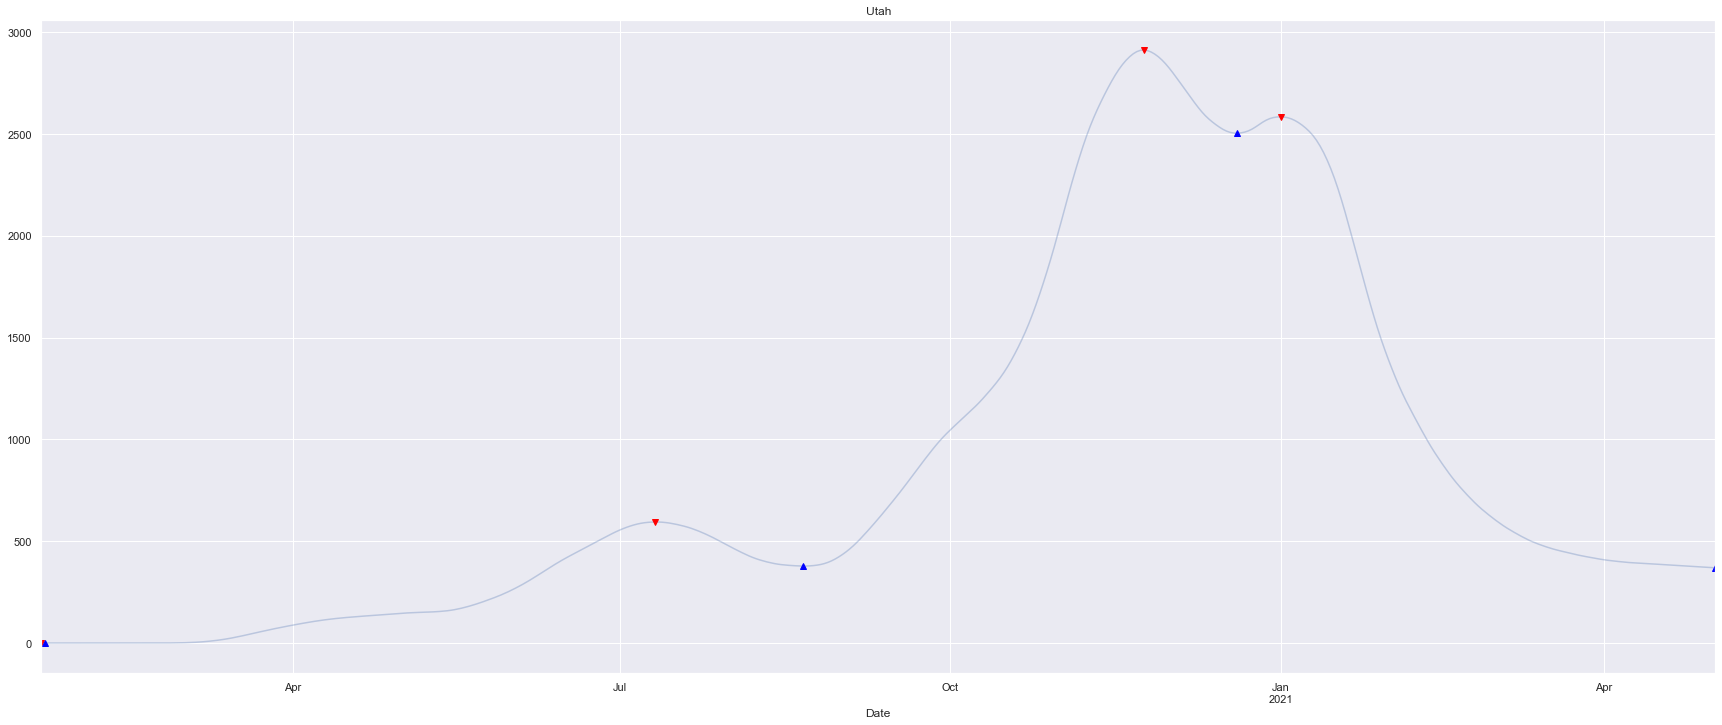

    index  test
0      25  71.0
1     -22  43.0
2       3  29.0
3      -1  13.0
4       0  12.0
5       0  27.0
6       0  15.0
7      -1  26.0
8      97  90.0
9       0   2.0
10     44  32.0
11    -33  41.0
12     39  32.0
13    -89  32.0
             new_cases
Date                  
2020-01-23   -0.000237
2020-05-16    3.560964
2020-06-27    6.226734
2020-08-05    5.845050
2020-09-15    4.758623
2020-12-16  101.803684
2021-02-27  113.337915
2021-05-02   63.623099
[  1 115 157 196 237 329 402 466]
             new_cases
Date                  
2020-01-22    0.000000
2020-04-03   25.774587
2020-06-14    7.511330
2020-07-09    6.839328
2020-08-20    6.730568
2020-12-14  101.823136
2021-01-17  146.679322
2021-03-31  152.891785
[  0  72 144 169 211 327 361 434]


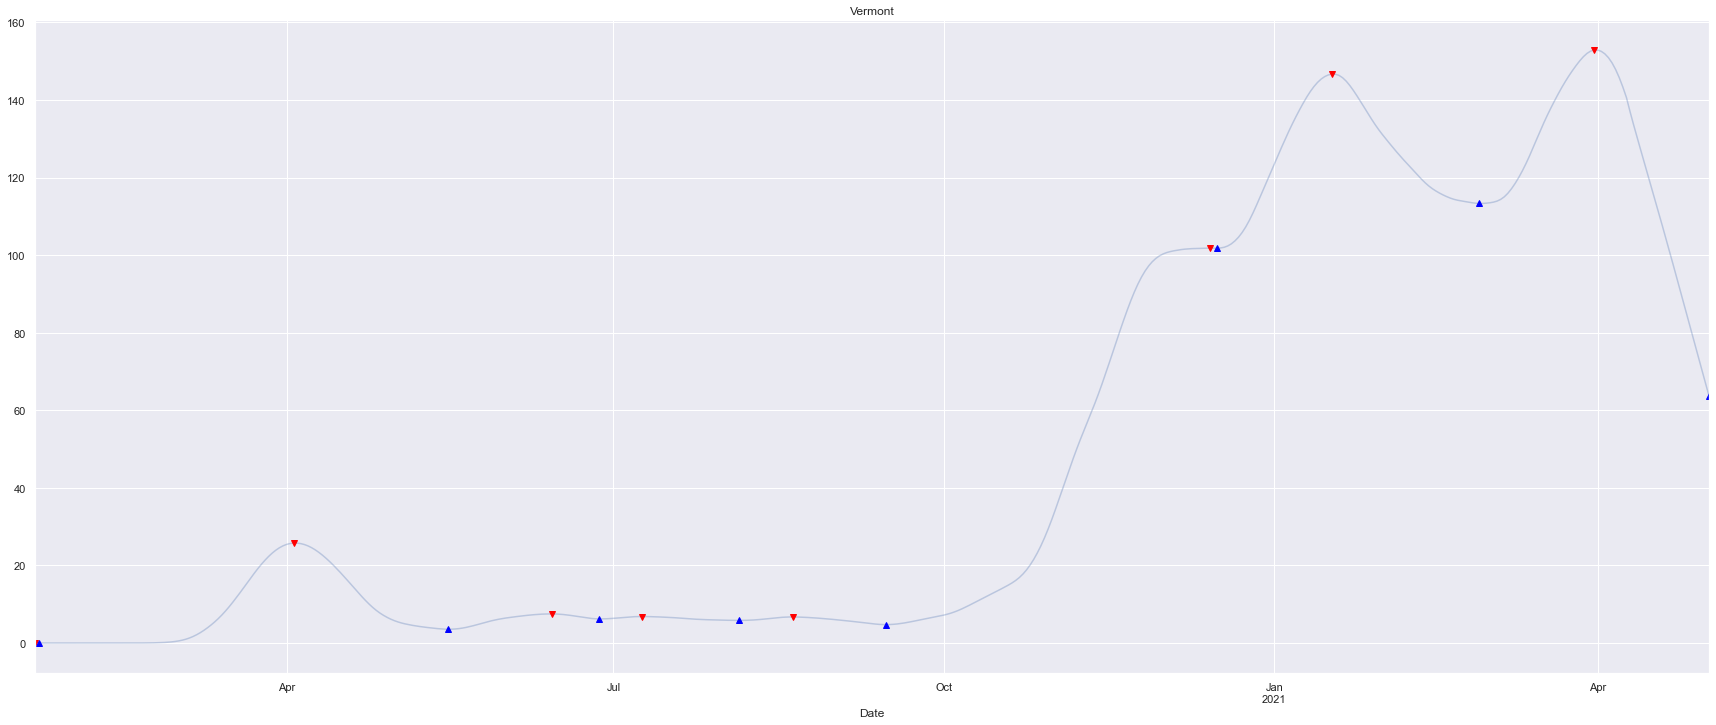

   index   test
0    924  119.0
1   -361   33.0
2    474   38.0
3    -72   26.0
4     10    9.0
5    -81   20.0
6   4125  112.0
7  -3610   63.0
8     56   15.0
9   -442   30.0
              new_cases
Date                   
2020-01-23    -0.000475
2020-06-23   562.776427
2020-08-26   964.184295
2020-09-24   893.762212
2021-03-18  1408.268471
2021-05-02  1021.463940
[  1 153 217 246 421 466]
              new_cases
Date                   
2020-01-22     0.000000
2020-05-21   924.391638
2020-07-31  1036.947738
2020-09-04   974.784022
2021-01-14  5018.804367
2021-04-02  1464.379650
[  0 120 191 226 358 436]


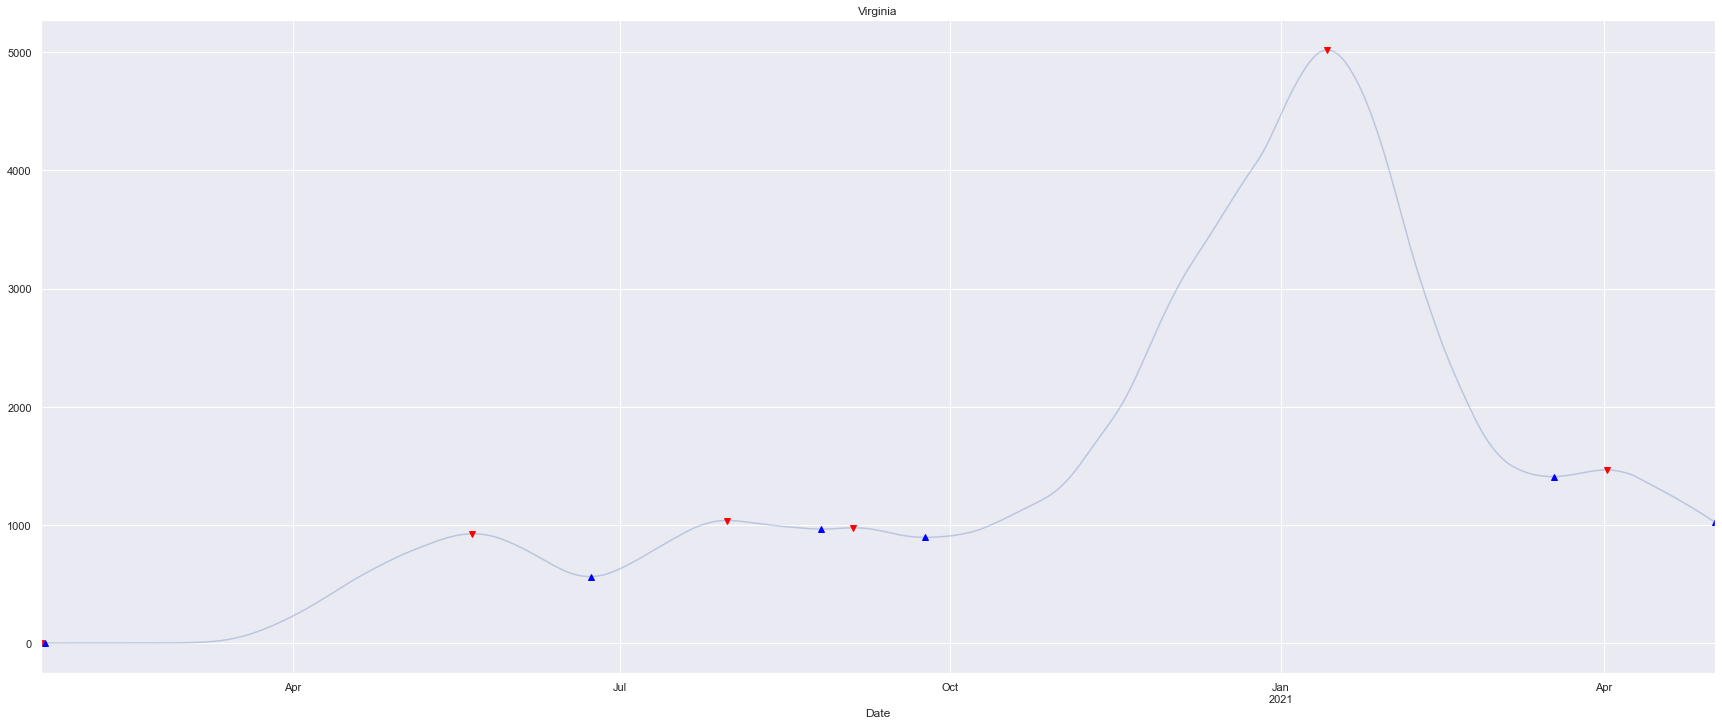

   index  test
0    350  72.0
1   -123  35.0
2    562  74.0
3   -344  48.0
4   2178  85.0
5   -347  25.0
6     27   8.0
7  -1548  63.0
8    615  55.0
              new_cases
Date                   
2020-01-23    -0.379186
2020-05-09   226.696201
2020-09-08   444.779924
2020-12-27  2275.039170
2021-03-08   754.776643
[  1 108 230 340 411]
              new_cases
Date                   
2020-01-22     0.000000
2020-04-04   350.546895
2020-07-22   789.075983
2020-12-02  2622.980783
2021-01-04  2302.785041
2021-05-02  1370.350874
[  0  73 182 315 348 466]


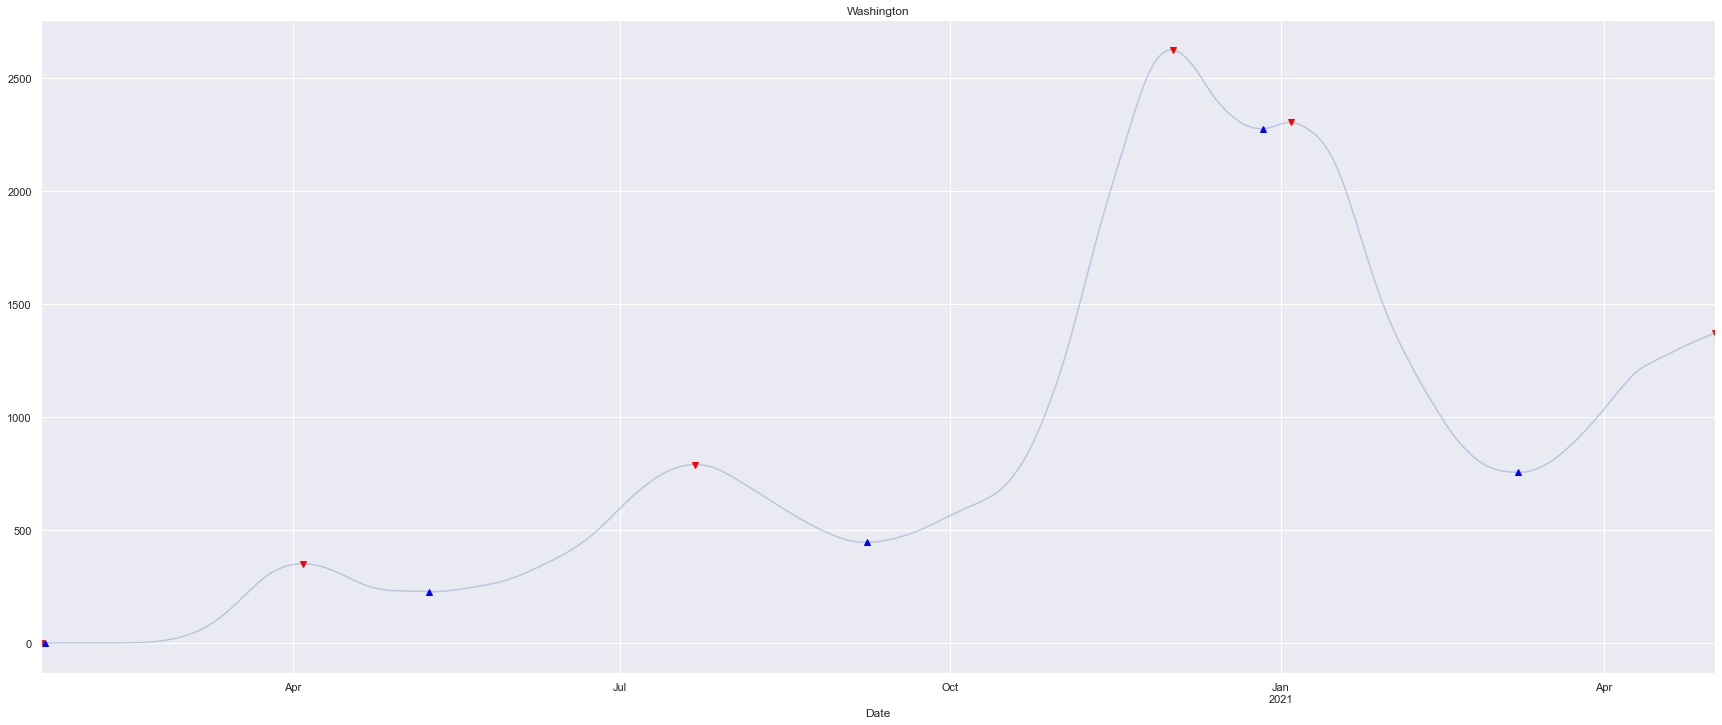

    index   test
0      32   50.0
1      -8   22.0
2       4   18.0
3       0    6.0
4       0    2.0
5       0    8.0
6      96   55.0
7      -5   11.0
8    1201  138.0
9   -1034   64.0
10    103   33.0
11    -27   27.0
             new_cases
Date                  
2020-02-23    0.000000
2020-05-05   23.790021
2020-05-29   28.602524
2020-06-08   28.384284
2020-08-13  119.589499
2021-03-03  287.015171
2021-05-02  363.151269
[ 32 104 128 138 204 406 466]
              new_cases
Date                   
2020-04-13    32.363781
2020-05-23    28.680163
2020-05-31    28.621310
2020-08-02   125.101974
2020-12-29  1321.512524
2021-04-05   390.206637
[ 82 122 130 193 342 439]


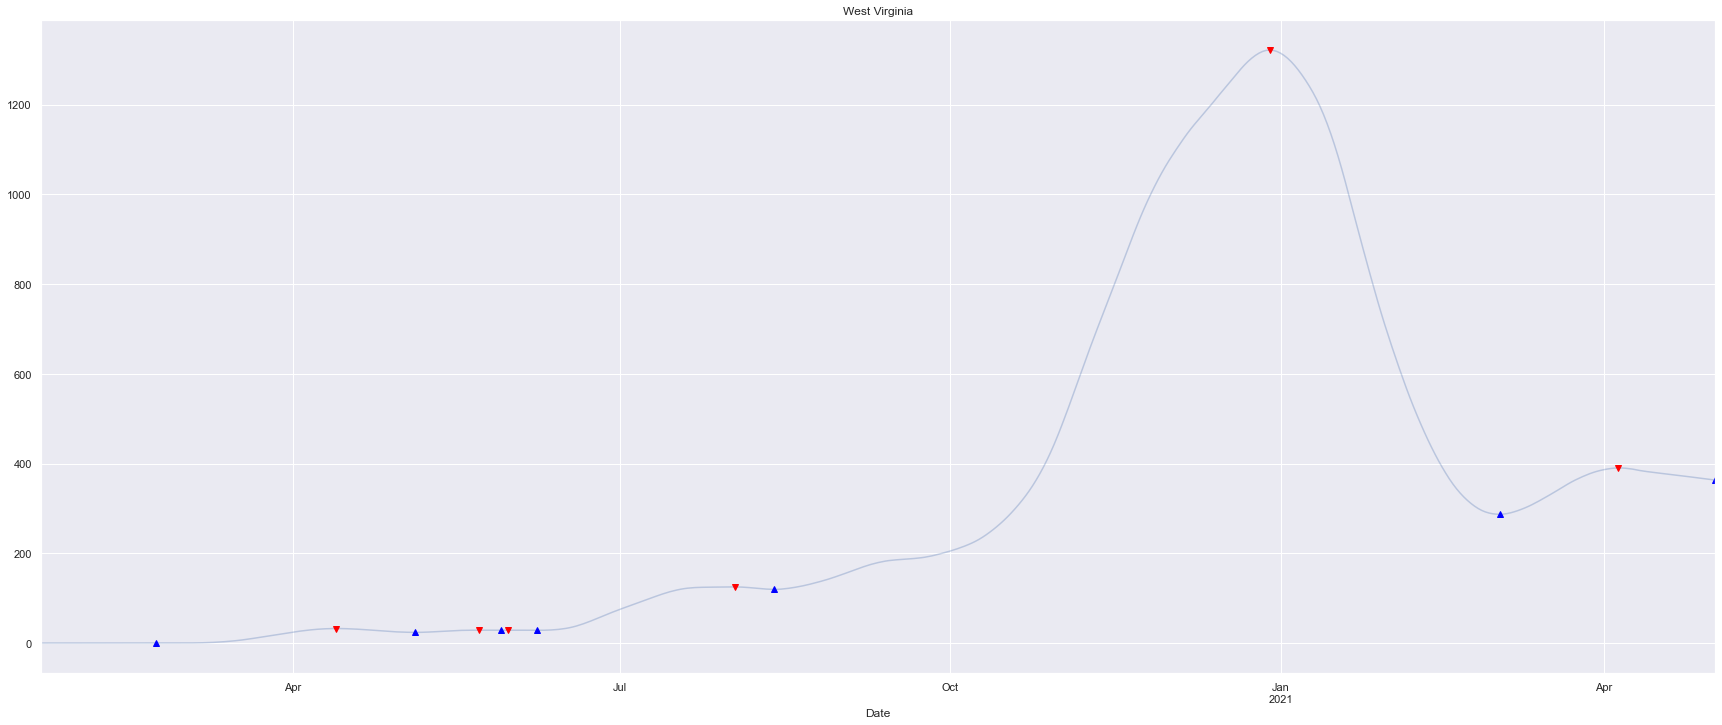

   index   test
0    376   99.0
1    -37   18.0
2    508   46.0
3   -111   24.0
4   5215   85.0
5  -5346  120.0
6    192   27.0
7    -63   23.0
             new_cases
Date                  
2020-02-15    0.000000
2020-06-11  339.521293
2020-08-20  736.721335
2021-03-13  606.262473
2021-05-02  735.263505
[ 24 141 211 416 466]
              new_cases
Date                   
2020-05-24   376.741562
2020-07-27   847.945011
2020-11-13  5952.521370
2021-04-09   798.582173
[123 187 296 443]


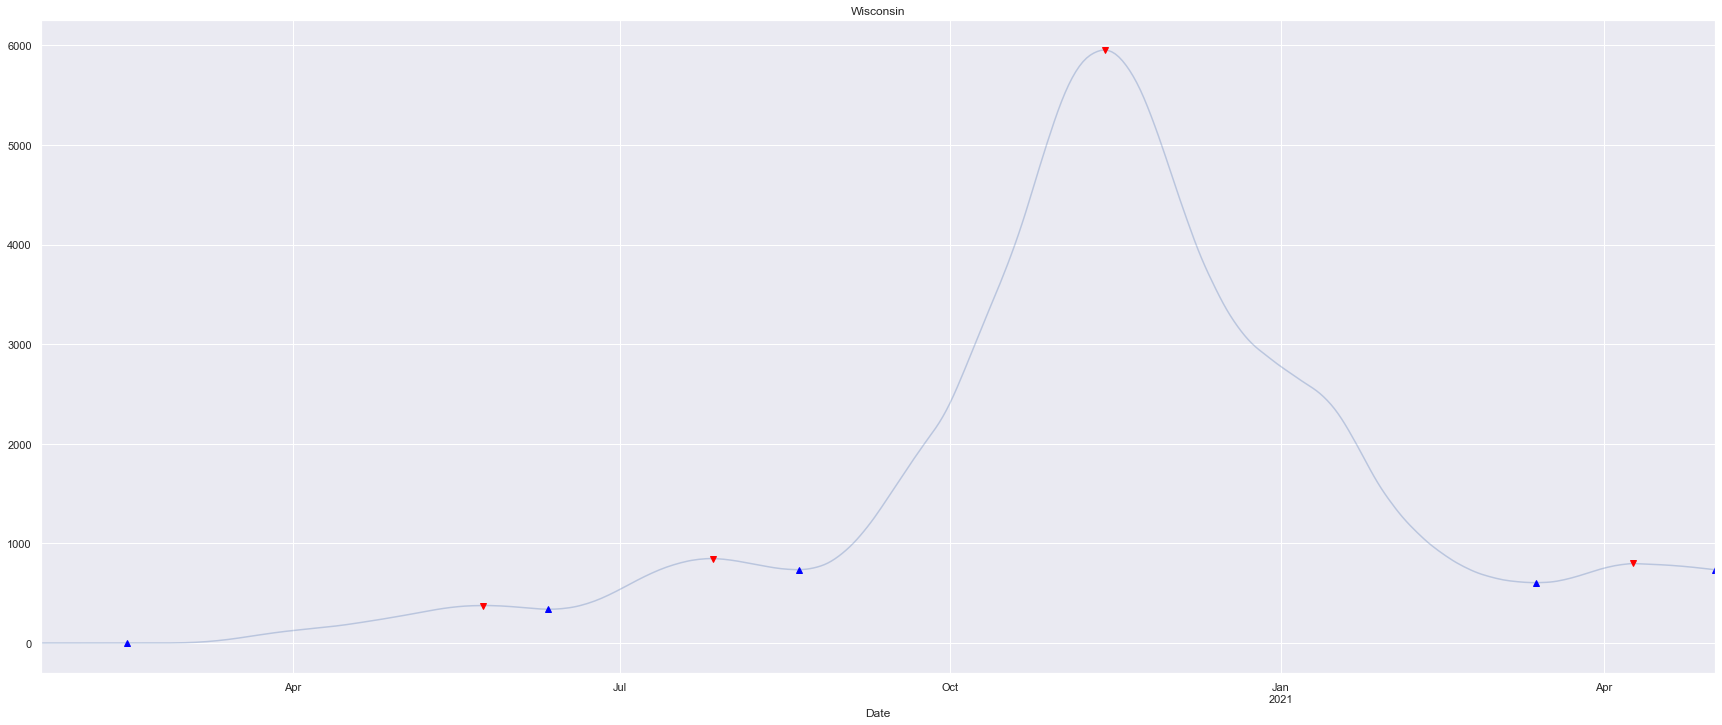

    index   test
0      14   60.0
1       0    7.0
2       0    4.0
3      -3   26.0
4      30   60.0
5      -5   29.0
6     640   90.0
7    -616  124.0
8       0    4.0
9       0   12.0
10      0    2.0
11     -5   22.0
            new_cases
Date                 
2020-02-17   0.000000
2020-04-24  14.242592
2020-05-24  10.604144
2020-08-21  36.038345
2021-03-23  60.143761
2021-04-08  59.517552
2021-05-02  54.094141
[ 26  93 123 212 426 442 466]
             new_cases
Date                  
2020-04-17   14.457268
2020-04-28   14.279866
2020-07-23   41.463517
2020-11-19  676.459560
2021-03-27   60.338950
2021-04-10   59.643326
[ 86  97 183 302 430 444]


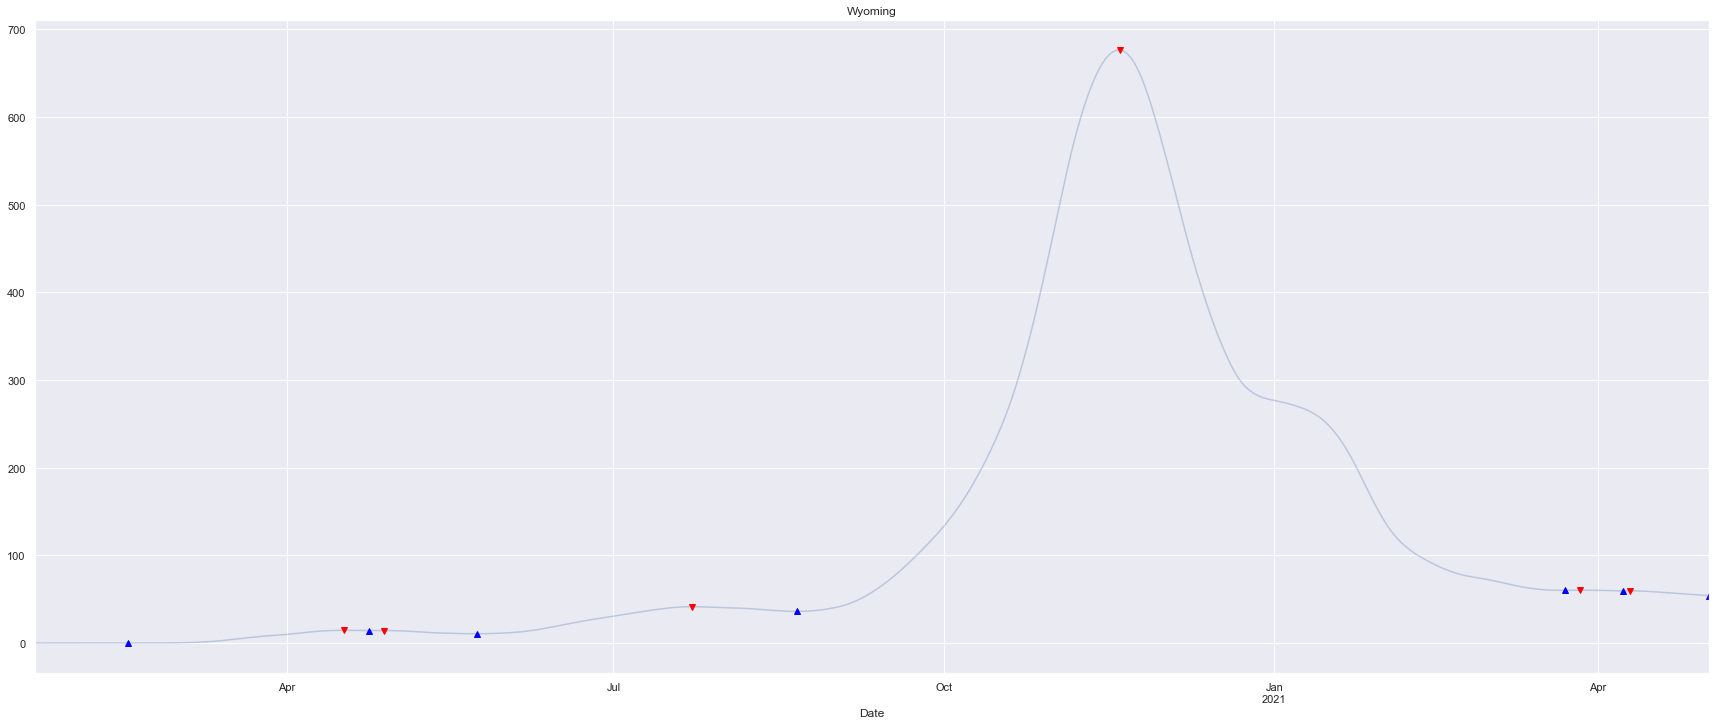

In [197]:
for state in us_states:
        StateTS(state).chart_peaks()